In [30]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
!pip install dataframe_image
import dataframe_image as dfi
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def build_df(file_id, file_name, index_col=None):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(file_name)
  if index_col is not None :
    return pd.read_csv(file_name, index_col=index_col)
  return pd.read_csv(file_name)

df = build_df('1LEbg13-KBZzHmIWAv9SnthGUzjvcbJuA','stylo-data.csv')
news_df = build_df('15zZXsks6cI0FY4vpL555lBQSBr1QyjT4', 'news-data.csv' )
varela_df = build_df('1JoC7GlAmdQO9WPZeJZKMbv4djyQzeezC',  'varela-stylo-data.csv')
varela_df.pop('Subject')

0       ASSUNTOS VARIADOS
1       ASSUNTOS VARIADOS
2       ASSUNTOS VARIADOS
3       ASSUNTOS VARIADOS
4       ASSUNTOS VARIADOS
              ...        
2995              TURISMO
2996              TURISMO
2997              TURISMO
2998              TURISMO
2999              TURISMO
Name: Subject, Length: 3000, dtype: object

In [2]:
#Some clean-up on line breaks
def clean_df(df):
  df = df.replace(to_replace ='\r', value = ' ', regex = True) 
  df = df.replace(to_replace ='\n ', value = '\n', regex = True) 
  df = df.replace(to_replace ='\n', value = ' ', regex = True)
  df = df.replace(to_replace ='\n{2,*}', value = ' ', regex = True)
  return df

#Read textual datasets
raw_df_test = build_df('1B-Ozck3R_cMeREw3yQQcODcz8UZ8Hvp7', 'raw_data.csv')
raw_df = clean_df(build_df('1B-Ozck3R_cMeREw3yQQcODcz8UZ8Hvp7', 'raw_data.csv'))
raw_news_df = clean_df(build_df('1P0UF5IRI3VNUuAulldEn84ntVfFLGiIq', 'raw_news_data.csv'))
raw_varela_df = clean_df(build_df('1s-qn2puLikOtN1YGOX2WZfZrNMxA6K4e', 'raw_varela_data.csv'))


stylo_classic_score_df = build_df('1g4zAbrxtVSqJ1GwwXKJufqMHXpWSrLsC', 'stylo_classic_score.csv', index_col=0)
tfidf_classic_score_df = build_df('17O4S-8P66KMzlKKReOcfsKO4LDDMSrYJ', 'idf_classic_score.csv', index_col=0)


stylo_nn_score_df = build_df('1YOawJZFxriWKrUaNVCIlfP5Do0XrTr-v', 'stylo_nn_score.csv', index_col=0)
tfidf_nn_score_df = build_df('1-zk7fcJKe_CVdAPuDWdNzC29ivKReE8R', 'idf_nn_score.csv', index_col=0)

raw_news_df.pop('Link')
raw_varela_df.pop('Subject')


def remove_varela_authors(df):
  regex_baleia = 'baleia - \d{1,2}\/\d{1,2}\/\d{2,4}'
  regex_ana = 'ana cristina cavalcante\s*\d{1,2} \w{1,4} \d{2,4} - \S{3,5}(min)*'
  regex_adriano = 'adriano gambarini - \d{1,2}\/\d{1,2}\/\d{2,4}'
  regex_ivolnildo = 'ivon(i)*l(d)*o lavôr(\s)*\d{1,2} \w{1,4} \d{2,4} - \S{4,5}(min)*'
  regex_mario = 'mário pinto(\s)*\d{1,2} \w{1,4} \d{2,4} - \S{4,5}(min)*'
  regex_julio = "mais sobr julio preuss - \d{1,2}\/\d{1,2}\/\d{2,4}(julio preussescreveu o livro 'fotografia digital: da compra da câmera à impressão das fotos)*"
  regex_roberto = 'roberto linsker - \d{1,2}\/\d{1,2}\/\d{2,4}'
  df['Text'] = df['Text'].str.replace(regex_baleia, ' ')
  df['Text'] = df['Text'].str.replace(regex_ana, ' ')
  df['Text'] = df['Text'].str.replace(regex_adriano, ' ')
  df['Text'] = df['Text'].str.replace(regex_ivolnildo, ' ')
  df['Text'] = df['Text'].str.replace(regex_mario, ' ')
  df['Text'] = df['Text'].str.replace(regex_julio, ' ')
  df['Text'] = df['Text'].str.replace(regex_roberto, ' ')
  return df

raw_varela_df = remove_varela_authors(raw_varela_df)


In [1]:
from __future__ import print_function
import time
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

!pip install scikit-fuzzy
import skfuzzy as fuzz
from sklearn.cluster import MiniBatchKMeans

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.cluster import KMeansClusterer
from sklearn import cluster, metrics
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score
from scipy import interp
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# clf = ExtraTreesClassifier(n_estimators=150)
import math
import tensorflow as tf


from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from matplotlib import rc
from matplotlib import font_manager as fm, rcParams 
import matplotlib.pyplot as plt 
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

#LatX fonts
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

     |████████████████████████████████| 1.0MB 12.6MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=1951305f75082122bd63f6d8378a663c44f99e0b058ea6138beb55020c5d151f
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  font

In [ ]:
# Remove few class entries (We need at least 3 samples of an author) and encode Author column 

def remove_entries(df, size):
  return df.groupby('Author').filter(lambda x: len(x) > size)

def encode_target_column(df, column):
  le = LabelEncoder()
  y = df.pop(column)
  encoded_Y = le.fit_transform(y)
  return encoded_Y

df = remove_entries(df, 2)
raw_df = remove_entries(raw_df, 2)

encoded_Y = encode_target_column(df, 'Author')
encoded_raw_Y  = encode_target_column(raw_df, 'Author')

encoded_Y_news  = encode_target_column(news_df, 'Author')
raw_news_df.pop('Author')

varela_Y_backup = varela_df['Author']
encoded_varela_Y = encode_target_column(varela_df, 'Author')
raw_varela_df.pop('Author')


corpus = raw_df['Text']
corpus_news = raw_news_df['Text']
corpus_varela = raw_varela_df['Text']

In [ ]:
#Visualize tokens by author

view_df = raw_df.copy()
view_df['Text'] = view_df['Text'].str.split(' ').apply(len)

view_df = view_df.groupby('Author').agg(['sum', 'count'])


ax = raw_df['Author'].value_counts().plot.bar()
fig = plt.gcf()
fig.set_size_inches(15, 12)

In [ ]:
#varela_df.drop('Subject', axis=1, inplace=True)
print(news_df.shape)
clf = ExtraTreesClassifier(n_estimators=150)
clf = clf.fit(news_df, encoded_Y_news)
model = SelectFromModel(clf, prefit=True)
new_X = model.transform(news_df)

In [ ]:
# Verification evaluation functions

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict


def classification_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df



In [ ]:
# Prepare our training and test sets
X_varela, X_varela_test, Y_varela, Y_varela_test = train_test_split(varela_df, encoded_varela_Y, random_state=7, test_size=0.3, stratify=encoded_varela_Y)
X_news, X_news_test, Y_news, Y_news_test = train_test_split(news_df, encoded_Y_news, random_state=7, test_size=0.3, stratify=encoded_Y_news)
X_student, X_student_test, Y_student, Y_student_test = train_test_split(df, encoded_Y, random_state=7, test_size=0.3, stratify=encoded_Y)

X_student_idf , X_student_idf_test, Y_student_idf, Y_student_idf_test = train_test_split(TfidfVectorizer().fit_transform(raw_df['Text']), encoded_Y, random_state=7, test_size=0.25, stratify=encoded_Y)
X_news_idf , X_news_idf_test, Y_news_idf, Y_news_idf_test = train_test_split(TfidfVectorizer().fit_transform(raw_news_df['Text']), encoded_Y_news, random_state=7, test_size=0.3, stratify=encoded_Y_news)
X_varela_idf , X_varela_idf_test, Y_varela_idf, Y_varela_idf_test = train_test_split(TfidfVectorizer().fit_transform(raw_varela_df['Text']), encoded_varela_Y, random_state=7, test_size=0.3, stratify=encoded_varela_Y)

df['Author'] = encoded_Y
news_df['Author'] = encoded_Y_news
varela_df['Author'] = encoded_varela_Y

In [ ]:
# Atribution evaluation functions

def binarize(df, author_value):
  copy_df = df.copy()
  copy_df['Author'] = copy_df['Author'].apply(lambda x: int(x == author_value))
  return copy_df

def calculate_rates(y_test, y_pred, verbose=False):
  tp, fp, fn, tn = metrics.confusion_matrix(y_test, y_pred).ravel()
  accuracy = metrics.accuracy_score(y_pred = y_pred, y_true = y_test)
  precision = metrics.precision_score(y_pred = y_pred, y_true = y_test)
  recall = metrics.recall_score(y_pred = y_pred, y_true = y_test)
  f1_score = 2 * precision * recall/(precision + recall)
  auc_roc = roc_auc_score(y_score = y_pred, y_true = y_test)
  if(verbose):
    print('acc, prec, recall, f1', accuracy, precision, recall, f1_score)
  return accuracy, precision, recall, f1_score, auc_roc

def authorship_verification(df, target_column):
  dfs = dict()
  results = dict()

  aucs = []
  accs = []
  f1s = []
  precisions = []
  recalls = []
  authors = set()
  for author in set(df[target_column]):
    authors.add(author)
    copy_df = df.copy()
    copy_df = binarize(copy_df, author)
    dfs[author] = copy_df
    
    Y = copy_df.pop(target_column)
    X, X_test, Y, Y_test = train_test_split(copy_df, Y, random_state=7, test_size=0.3, stratify=Y)
    clf = RandomForestClassifier(random_state=0, n_estimators=500).fit(X, Y)
    Y_pred_proba = clf.predict_proba(X_test)
    Y_pred = clf.predict(X_test)
    

    acc_, prec_, recall_, f1_, auc_ = calculate_rates(Y_test, Y_pred)

    precisions.append(prec_)
    recalls.append(recall_)
    f1s.append(f1_)  
    accs.append(acc_) 
    aucs.append(auc_)
    
    #TODO: Validar com cleber
    #roc_auc_score = metrics.roc_auc_score(Y_test,Y_pred_proba[:,1])
    #aucs.append(roc_auc_score)

  frame = {'acc': pd.Series(accs), 'AUC ROC': pd.Series(aucs), 
           'precisão': pd.Series(precisions), 'recall': pd.Series(recalls),
           'f1': pd.Series(f1s)}

  result_df = pd.DataFrame(frame, index=authors)
  result_df.fillna(0, inplace=True)
  result_df.loc['média'] = result_df['acc'].mean(), result_df['AUC ROC'].mean(), result_df['precisão'].mean(), result_df['recall'].mean(), result_df['f1'].mean()
  return result_df

# This needs Author column in the df  
#authorship_verification(news_df, 'Author')
# Display metrics

def train_and_report(classifier, X, X_test, Y, Y_test, dataset_name, average='macro', verbose=True):

  clf = classifier.fit(X, Y)
  y_pred = clf.predict(X_test)
  # report_with_auc = classification_report(
  #     y_true=Y_test, 
  #     y_pred=y_pred, 
  #     y_score=clf.predict_proba(X_test),
  #     average=average)
  
  print(dataset_name)
  acc = accuracy_score(Y_test, y_pred)
  print('ACCURACY:', acc)
  roc_auc_dict = roc_auc_score_multiclass(Y_test, y_pred, average=average)
  print('ROC AUC MEAN:', np.mean(list(roc_auc_dict.values())))

  if verbose:
    print('BLA')

  return _ , np.mean(list(roc_auc_dict.values())), acc


#train_and_report(RandomForestClassifier(random_state=0, n_estimators=500) , X_varela, X_varela_test, Y_varela, Y_varela_test, 'Base Varela', average="macro")
#train_and_report(RandomForestClassifier(random_state=0, n_estimators=500), X_news, X_news_test, Y_news, Y_news_test, 'Base de notícias', average="macro")
#train_and_report(RandomForestClassifier(random_state=0, n_estimators=500), X_student, X_student_test, Y_student, Y_student_test, 'Base de estudantes', average="macro")


In [ ]:

def build_metrics_df(model_names, metrics):
  rows = pd.Series(model_names)
  cols = pd.Series(metrics)
  return pd.DataFrame(index=rows, columns=cols)

model_names = ['RL', 'NB MN', 'NB Gaus', 'SVM Lin', 'SVM RBF', 'SVM Poli', 'RF',
              'Árvores Extra','GB', 'MLP']

metrics = ['acurácia', 'roc auc']  


In [ ]:
from sklearn.dummy import DummyClassifier

models = [LogisticRegression(random_state=0), MultinomialNB(), GaussianNB(), SVC(kernel='linear'),
          SVC(kernel='rbf'), SVC(kernel='poly'), 
          RandomForestClassifier(random_state=0), ExtraTreesClassifier(random_state=0), 
          GradientBoostingClassifier(random_state=0), MLPClassifier(random_state=0)]

model_names = ['RL', 'NB MN', 'NB Gaus', 'SVM Lin', 'SVM RBF', 'SVM Poli', 'RF',
              'Árvores Extra','GB', 'MLP']

metrics = ['acurácia', 'roc auc']  

def set_scores(df, model_name, acc, auc):
  df.loc[model_name]['acurácia'] = acc
  df.loc[model_name]['roc auc'] = auc


stylo_data = [
   [X_student, X_student_test, Y_student, Y_student_test],
   [X_news, X_news_test, Y_news, Y_news_test], 
   [X_varela, X_varela_test, Y_varela, Y_varela_test] ]


tfidf_data = [
   [X_student_idf.toarray(), X_student_idf_test.toarray(), Y_student_idf, Y_student_idf_test],
   [X_news_idf.toarray(), X_news_idf_test.toarray(), Y_news_idf, Y_news_idf_test], 
   [X_varela_idf.toarray(), X_varela_idf_test.toarray(), Y_varela_idf, Y_varela_idf_test] ]


def run_classic_models(data):
  student_stylo_acc_df = build_metrics_df(model_names, metrics)
  news_stylo_acc_df = student_stylo_acc_df.copy()
  varela_stylo_acc_df = student_stylo_acc_df.copy()
  for model, model_name in zip(models, model_names):
    _, auc, acc = train_and_report(model, data[0][0], data[0][1], data[0][2], data[0][3], 'Base de estudantes', average="macro", verbose=False)
    set_scores(student_stylo_acc_df, model_name, acc, auc)
    
    _, auc, acc = train_and_report(model, data[1][0], data[1][1], data[1][2], data[1][3], 'Base de notícias', average="macro", verbose=False)
    set_scores(news_stylo_acc_df, model_name, acc, auc)
      
    _, auc, acc = train_and_report(model, data[2][0], data[2][1], data[2][2], data[2][3], 'Base Varela', average="macro", verbose=False )
    set_scores(varela_stylo_acc_df, model_name, acc, auc)
  return student_stylo_acc_df, news_stylo_acc_df, varela_stylo_acc_df  


In [ ]:
#This takes a lot of time, gladly we saved the scores after training @ #stylo_classic_score_df #tfidf_classic_score_df
student_score_df , news_score_df , varela_score_df = run_classic_models(stylo_data)
studenttf_score_df , newstf_score_df , varelatf_score_df = run_classic_models(tfidf_data)

In [ ]:
def plot_metrics(dfs, metrics, title):
  fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(14, 8))

  plt.rc('xtick',labelsize=8)
  plt.rc('ytick',labelsize=8)
  fig.autofmt_xdate(rotation=45)
  fig.suptitle(title)
  for idx, ax in enumerate(axes):
    new_df = dfs[idx].copy()
    new_df['Modelo'] = new_df.index
    new_df.reset_index(drop=True, inplace=True)
    tidy = new_df.melt(id_vars='Modelo').rename(columns=str.title)
    tidy.rename(inplace=True,columns={"Variable": "Base", "Value": metrics[idx]} )
    
    sns.barplot(x='Modelo', y=metrics[idx], hue='Base', data=tidy, ax=ax)
    

In [122]:
#Plot AUC/ACC 
def merge_and_build_acc_df(students_df, news_df, varela_df):
    merged_df = students_df.merge(news_df, left_index=True, right_index=True, suffixes=('_estudantes', '_notícias')).merge(varela_df, left_index=True, right_index=True)
    return build_acc_df(merged_df)

def merge_and_build_auc_df(students_df, news_df, varela_df):
    merged_df = students_df.merge(news_df, left_index=True, right_index=True, suffixes=('_estudantes', '_notícias')).merge(varela_df, left_index=True, right_index=True)
    return build_auc_df(merged_df)

def build_acc_df(df, nn=False):
    merged_df = df.copy()
    merged_df.drop(columns='roc auc_estudantes', inplace=True)
    merged_df.drop(columns='roc auc_notícias', inplace=True)
    merged_df.drop(columns='roc auc', inplace=True)
    merged_df.rename(columns={'acurácia_estudantes': 'Estudantes', 'acurácia_notícias' : 'Notícias', 'acurácia':'Varela'}, inplace=True)
    if not nn:
      merged_df.index = ['RL', 'NB MN', 'NB Gau', 'SVM Lin', 'SVM RBF', 'SVM Poli', 'Random Forest',
              'Árvores Extra','Gradient Boosting', 'MLP']
    else:
      merged_df.index = ['Rede Neural Autoral']
    
    return merged_df

def build_auc_df(df, nn=False):
    merged_df = df.copy()
    merged_df.drop(columns='acurácia_estudantes', inplace=True)
    merged_df.drop(columns='acurácia_notícias', inplace=True)
    merged_df.drop(columns='acurácia', inplace=True)
    merged_df.rename(columns={'roc auc_estudantes': 'Estudantes', 'roc auc_notícias' : 'Notícias', 'roc auc':'Varela'}, inplace=True)
    if not nn:
      merged_df.index = ['RL', 'NB MN', 'NB Gau', 'SVM Lin', 'SVM RBF', 'SVM Poli', 'Random Forest',
                'Árvores Extra','Gradient Boosting', 'MLP']
    else:
      merged_df.index = ['Rede Neural Autoral']
    return merged_df


In [132]:
stylo_nn_score_df

,acurácia_estudantes,roc auc macro_estudantes,roc auc mic_estudantes,acurácia_notícias,roc auc macro_notícias,roc auc mic_notícias,acurácia,roc auc macro,roc auc mic
NN,0.095238,0.5,0.584127,0.12,0.570438,0.584889,0.009333,0.5,0.483165


In [133]:
stylo_nn['roc auc'] = 0.5

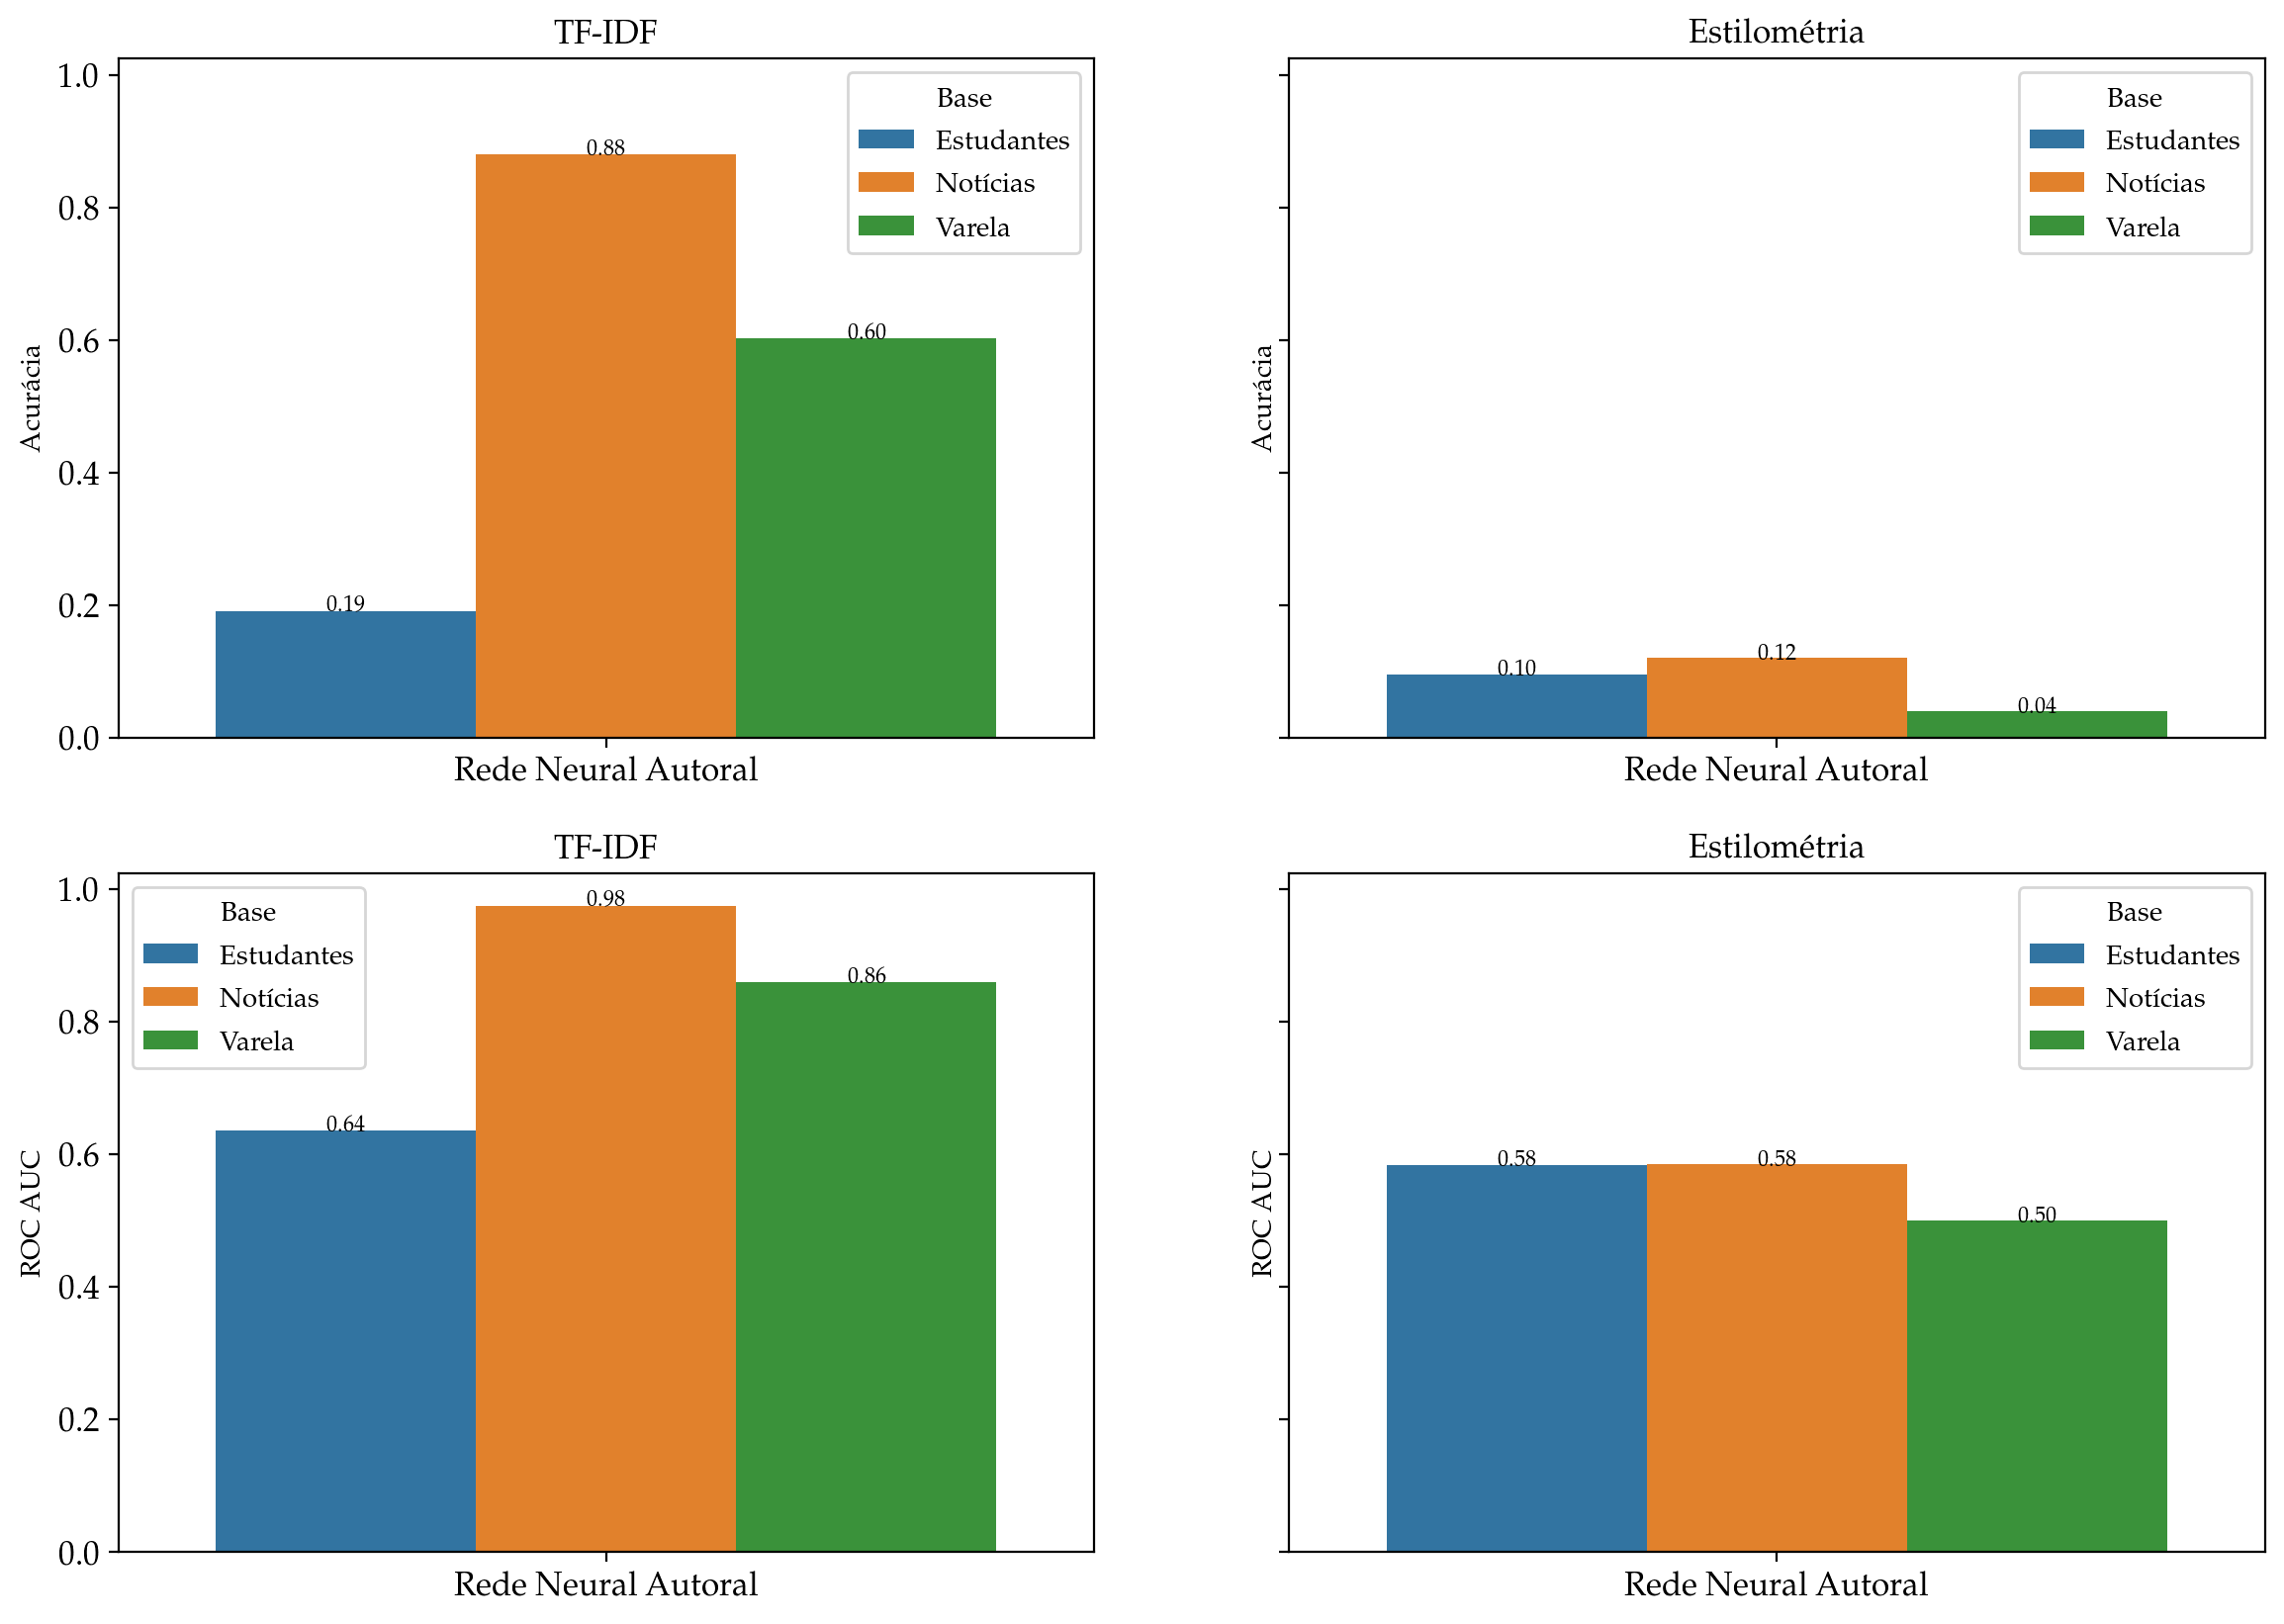

In [134]:
#stylo_nn_score_df
#plot_metrics([build_acc_df(stylo_nn, True), build_auc_df(stylo_nn, True)], ['Acurácia', 'ROC AUC'], 'Atribuição de Autoria - TF-IDF')

plot_metrics_large([
                    
                    build_acc_df(idf_nn, True),
                    build_acc_df(stylo_nn, True),
                    build_auc_df(idf_nn, True),
                    build_auc_df(stylo_nn, True),
                    
              ]
              , ['Acurácia', 'Acurácia', 'ROC AUC', 'ROC AUC'], 
             'Atribuição de Autoria', ['TF-IDF', 'Estilométria', 'TF-IDF', 'Estilométria'], rotate=False, sharey=True)


In [12]:
#TODO: Continue from here - Job is to plot the ACC and AUC of NN (IDF and Stylo in a single 2x2 grid)
def prepare_data(data):

  nn_idf_acc = data.copy()

  nn_idf_acc.rename(columns={"roc auc mic_estudantes": "roc auc_estudantes",
                                    "roc auc mic_notícias": "roc auc_notícias",
                                    "roc auc mic": "roc auc"
  }, inplace=True)


  nn_idf_acc.drop(columns=[
                      'roc auc macro_notícias',
                      'roc auc macro_estudantes',
                      'roc auc macro'
  ], inplace=True)

  nn_idf_acc['roc auc'] = 0.86
  return nn_idf_acc

idf_nn = prepare_data(tfidf_nn_score_df)
stylo_nn = prepare_data(stylo_nn_score_df)


In [ ]:
tfidf_nn_score_df

,acurácia_estudantes,roc auc macro_estudantes,roc auc mic_estudantes,acurácia_notícias,roc auc macro_notícias,roc auc mic_notícias,acurácia,roc auc macro,roc auc mic
NN,0.190476,0.720765,0.636886,0.88,0.98615,0.975467,0.602667,0.968836,0.96868


In [ ]:
idf_nn

,acurácia_estudantes,roc auc_estudantes,acurácia_notícias,roc auc_notícias,acurácia,roc auc
NN,0.190476,0.720765,0.88,0.98615,0.602667,0.968836


In [ ]:
build_acc_df(stylo_nn, True)

,Estudantes,Notícias,Varela
Rede Neural,0.095238,0.12,0.009333


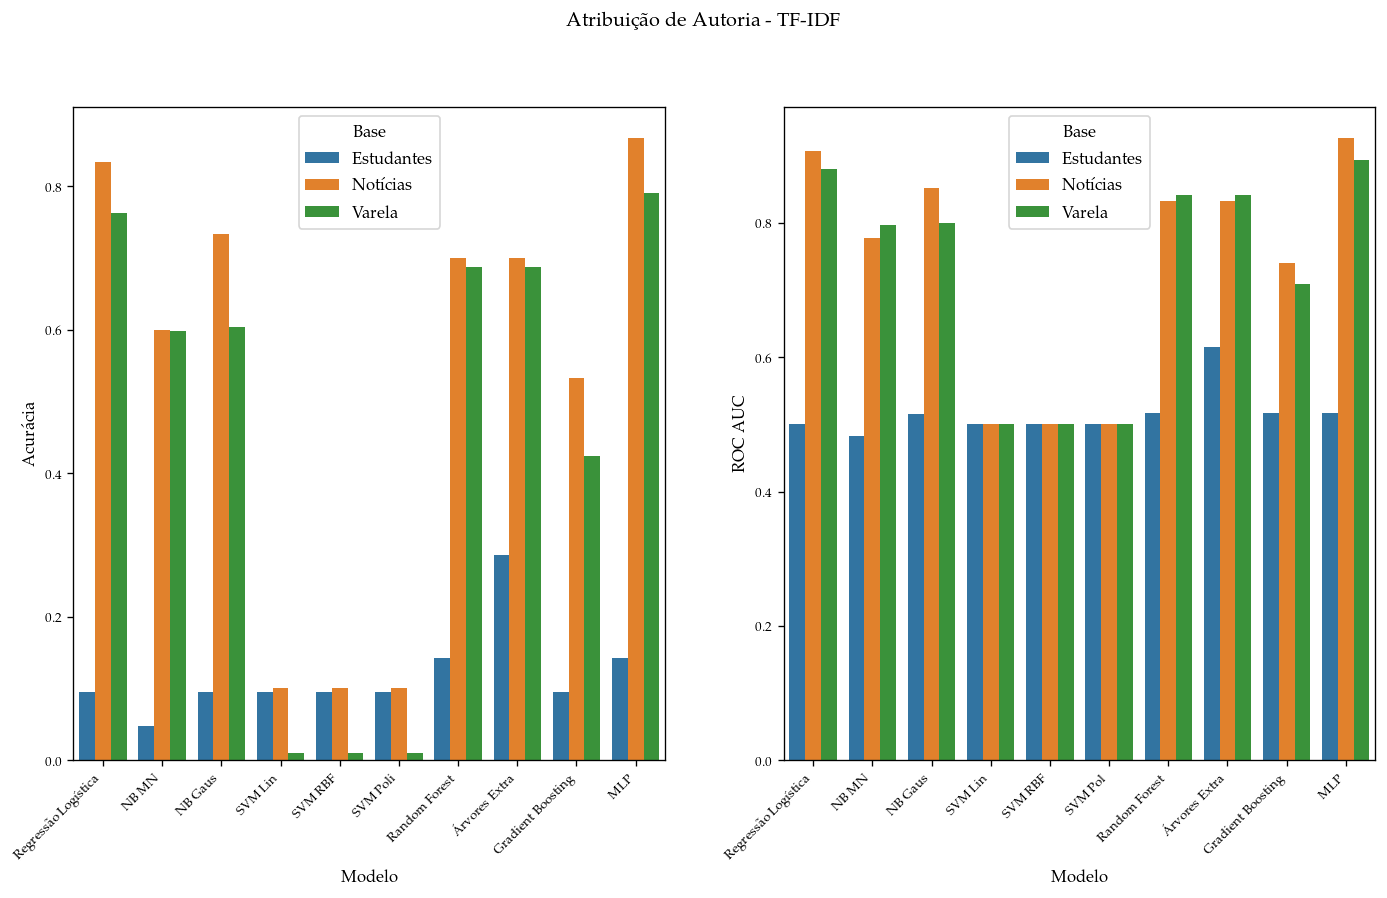

In [ ]:
plot_metrics([build_acc_df(studenttf_score_df , newstf_score_df , varelatf_score_df) , build_auc_df(studenttf_score_df , newstf_score_df , varelatf_score_df)], ['Acurácia', 'ROC AUC'], 'Atribuição de Autoria - TF-IDF')

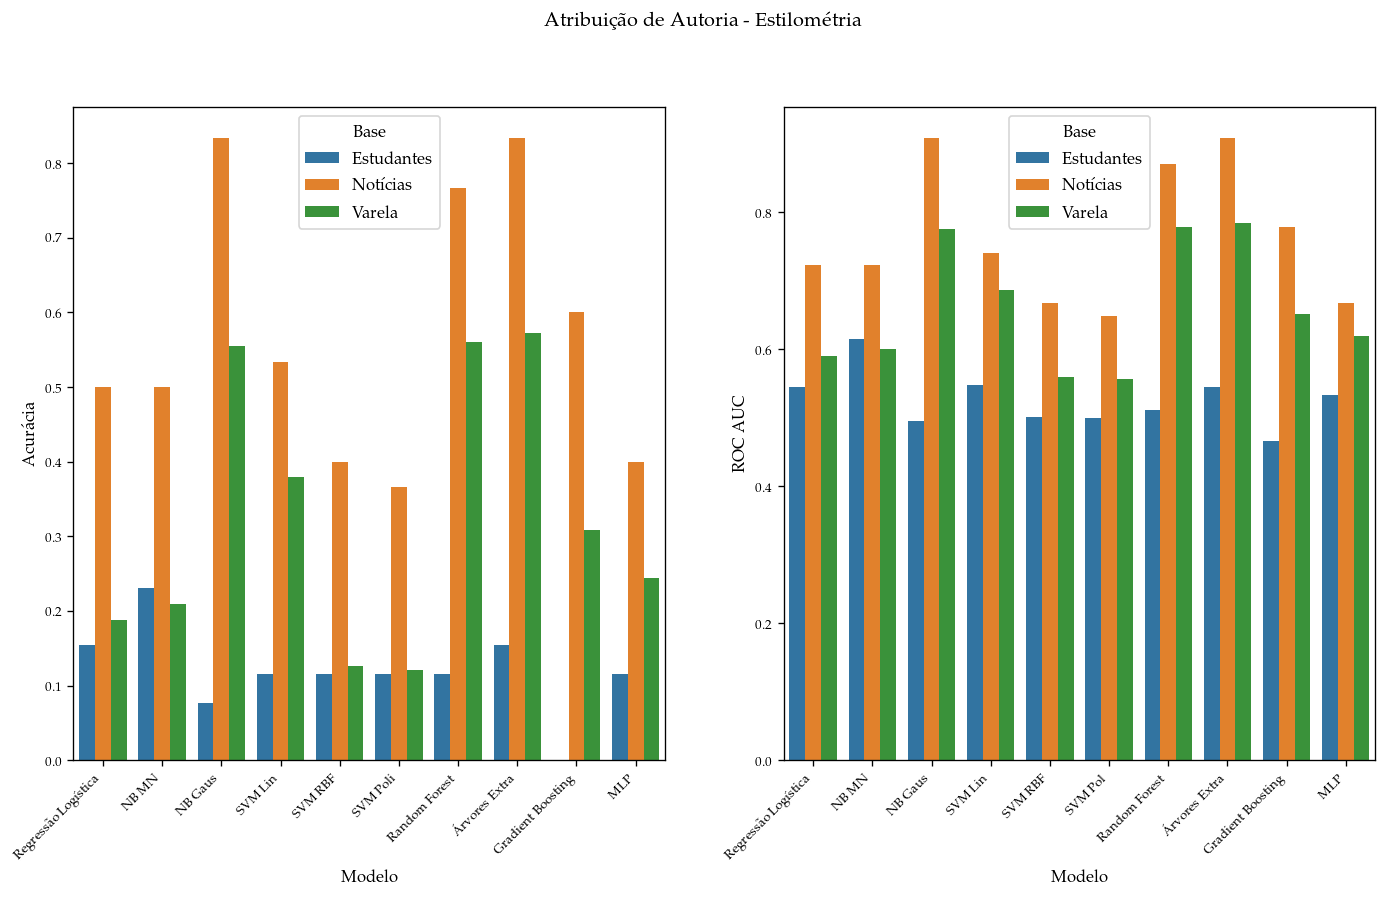

In [ ]:
plot_metrics([build_acc_df(student_score_df , news_score_df , varela_score_df) , build_auc_df(student_score_df , news_score_df , varela_score_df)], ['Acurácia', 'ROC AUC'], 'Atribuição de Autoria - Estilométria')

In [123]:
def plot_metrics_large(dfs, metrics, main_title, titles, rotate=True, sharey=False):
  plt.rcParams['figure.dpi'] = 200
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=sharey)
  #fig.tight_layout(h_pad=5, w_pad=5)

  plt.rc('xtick',labelsize=12)
  plt.rc('ytick',labelsize=12)
  
  #fig.suptitle(main_title)
  for idx, ax in enumerate(axes.flat):
    ax.set_title(titles[idx])
    new_df = dfs[idx].copy()
    new_df['Modelo'] = new_df.index
    new_df.reset_index(drop=True, inplace=True)
    tidy = new_df.melt(id_vars='Modelo').rename(columns=str.title)
    tidy.rename(inplace=True,columns={"Variable": "Base", "Value": metrics[idx]} )
    sns.barplot(x='Modelo', y=metrics[idx], hue='Base', data=tidy, ax=ax)
    if rotate:
      plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')
    anotatte_bars(ax)

def anotatte_bars(ax):
  for p in ax.patches:
    x = p.get_x() + (p.get_width()/2)
    y = p.get_height()
    ax.annotate("{:.2f}".format(p.get_height()), (x, y), ha='center', fontsize=8)

In [135]:
lstm_scores = [0.11538461595773697, 0.20000000298023224, 0.04444444552063942, 0.07692307978868484, 0.23333333432674408, 0.03888889029622078,0.11538461595773697, 0.2666666805744171, 0.06666667014360428,0.07692307978868484, 0.20000000298023224, 0.058888889849185944, 0.07692307978868484, 0.30000001192092896, 0.05444444343447685 ,  0.11538461595773697, 0.23333333432674408, 0.04555555433034897]

In [ ]:
lstm_types = ['GloVe 50d', 'GloVe 100d', 'Word2vec cbow 50d', 'Word2vec cbow 100d', 'FastText skipgram 50d', 'FastText skipgram 100d']

In [136]:
lstm_df = pd.DataFrame(index=['Estudantes', 'Notícias', 'Varela'])


for idx, legend in enumerate(lstm_types):
  cur_idx = idx * 3
  lstm_df[legend] = lstm_scores[cur_idx : cur_idx+3]


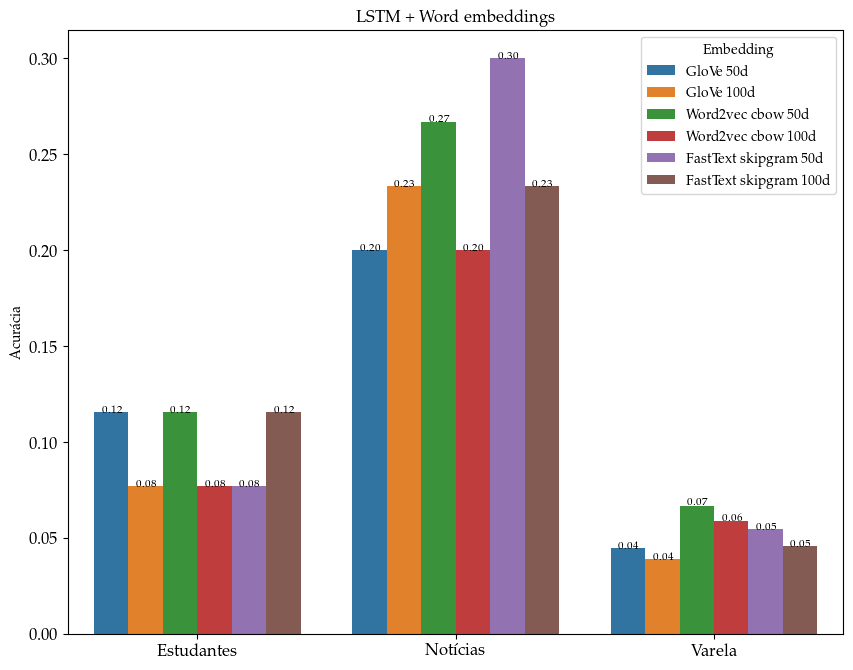

In [137]:
plt.rcParams['figure.dpi'] = 100

plt.figure(1, figsize=(10,8))
ax = plt.gca()
ax.set_title('LSTM + Word embeddings')
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

new_df = lstm_df.copy()
new_df['Modelo'] = new_df.index
new_df.reset_index(drop=True, inplace=True)
tidy = new_df.melt(id_vars='Modelo').rename(columns=str.title)
tidy.rename(inplace=True,columns={"Variable": "Embedding", "Value": "Acurácia"} )
sns.barplot(x='Modelo', y="Acurácia", hue='Embedding', data=tidy, ax=ax)

#plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
anotatte_bars(ax)  


In [25]:
def build_selected_models(df, nn_df):
  df.drop(index=['SVM Lin','SVM RBF', 'SVM Poli', 'GB', 'NB MN'], inplace=True)
  idf_nn = prepare_data(nn_df)
  df = df.append(idf_nn)
  return df


stylo_nn_score_df = build_df('1YOawJZFxriWKrUaNVCIlfP5Do0XrTr-v', 'stylo_nn_score.csv', index_col=0)
tfidf_nn_score_df = build_df('1-zk7fcJKe_CVdAPuDWdNzC29ivKReE8R', 'idf_nn_score.csv', index_col=0)

stylo_classic_score_df = build_df('1g4zAbrxtVSqJ1GwwXKJufqMHXpWSrLsC', 'stylo_classic_score.csv', index_col=0)
tfidf_classic_score_df = build_df('17O4S-8P66KMzlKKReOcfsKO4LDDMSrYJ', 'idf_classic_score.csv', index_col=0)

stylo_df = build_selected_models(stylo_classic_score_df, stylo_nn_score_df)
idf_df = build_selected_models(tfidf_classic_score_df, tfidf_nn_score_df)


In [29]:
idf_df.to_csv('selected-idf-scores.csv')
stylo_df.to_csv('selected-stylo-scores.csv')


In [24]:
idf_df

,acurácia_estudantes,roc auc_estudantes,acurácia_notícias,roc auc_notícias,acurácia,roc auc
RL,0.095238,0.500000,0.833333,0.907407,0.762222,0.879910
NB Gaus,0.095238,0.516201,0.733333,0.851852,0.604444,0.800224
RF,0.142857,0.517270,0.700000,0.833333,0.687778,0.842312
Árvores Extra,0.285714,0.615954,0.700000,0.833333,0.687778,0.842312
MLP,0.142857,0.517434,0.866667,0.925926,0.790000,0.893939


In [18]:
stylo_classic_score_df.append(prepare_data(stylo_nn_score_df))

,acurácia_estudantes,roc auc_estudantes,acurácia_notícias,roc auc_notícias,acurácia,roc auc
RL,0.153846,0.544461,0.500000,0.722222,0.187778,0.589787
NB Gaus,0.076923,0.494552,0.833333,0.907407,0.555556,0.775533
RF,0.115385,0.511313,0.766667,0.870370,0.561111,0.778339
Árvores Extra,0.153846,0.543918,0.833333,0.907407,0.572222,0.783951
MLP,0.115385,0.532751,0.400000,0.666667,0.244444,0.618406
NN,0.095238,0.584127,0.120000,0.584889,0.009333,0.860000


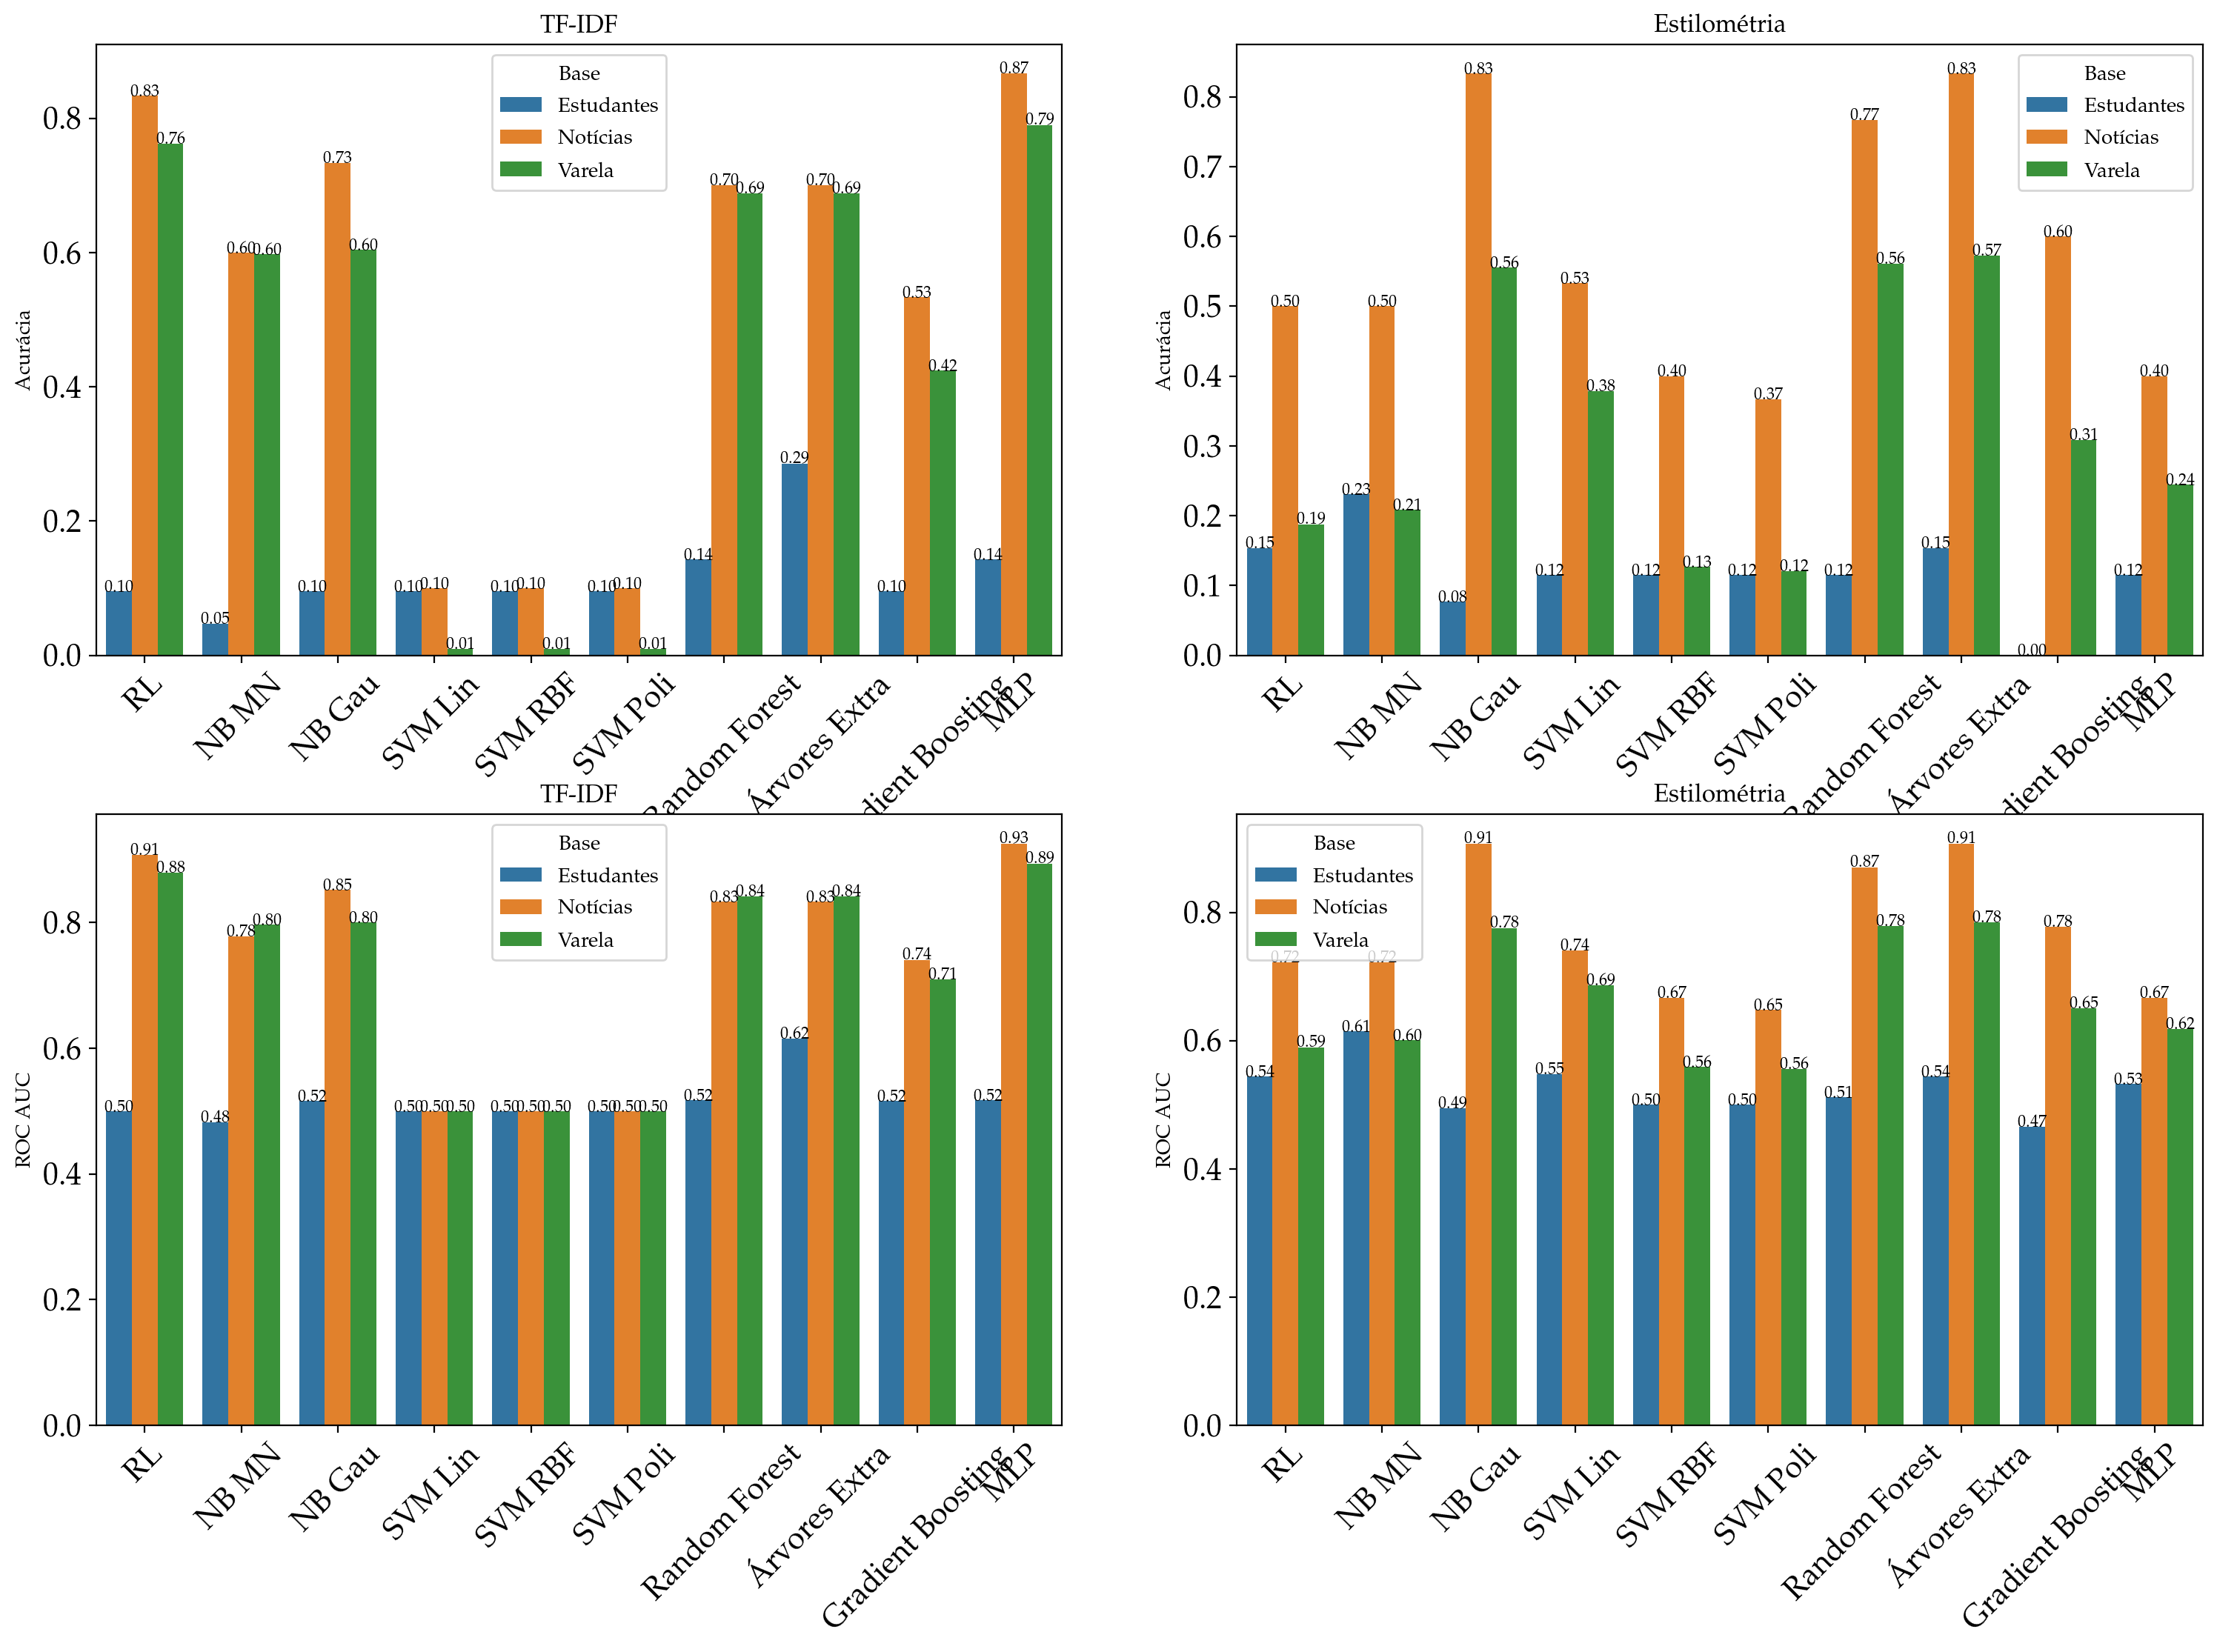

In [ ]:
plot_metrics_large([build_acc_df(tfidf_classic_score_df),
                    build_acc_df(stylo_classic_score_df),        
                    build_auc_df(tfidf_classic_score_df),
                    build_auc_df(stylo_classic_score_df)
              ]
              , ['Acurácia', 'Acurácia', 'ROC AUC', 'ROC AUC'], 
             'Atribuição de Autoria', ['TF-IDF', 'Estilométria', 'TF-IDF', 'Estilométria'])

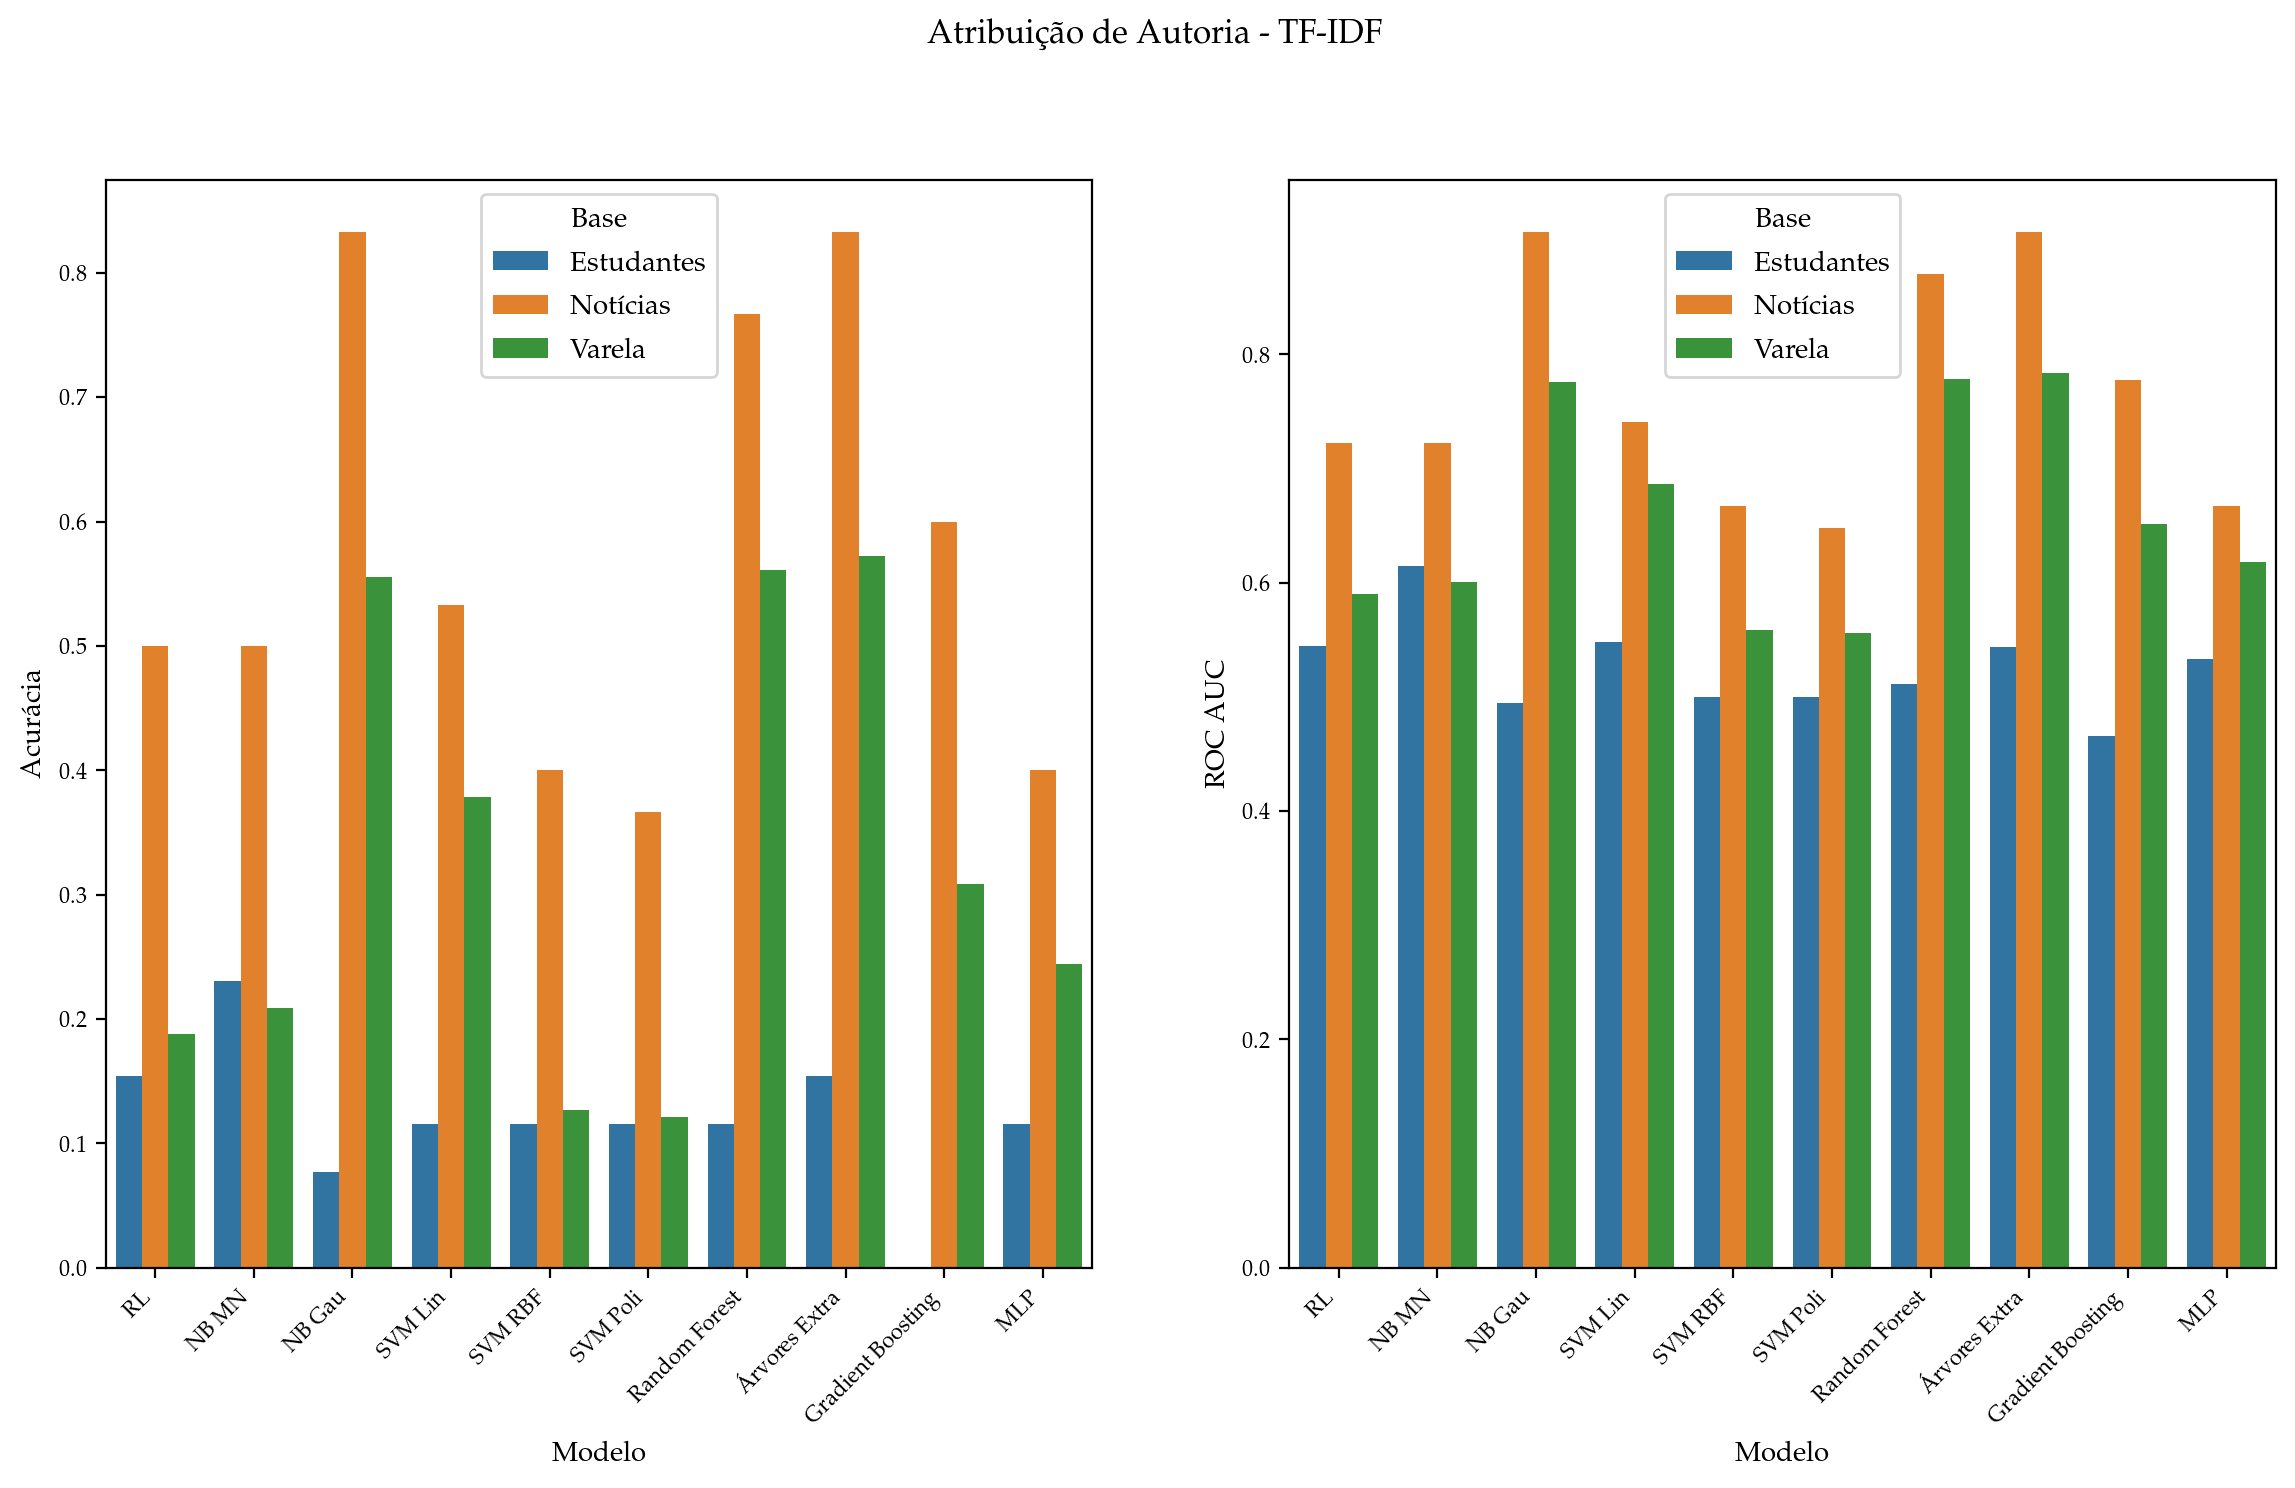

In [ ]:
# This should work with the saved datasets
plot_metrics([build_acc_df(pd.read_csv('stylo-score.csv', index_col=0)) , build_auc_df(pd.read_csv('stylo-score.csv', index_col=0))], ['Acurácia', 'ROC AUC'], 'Atribuição de Autoria - TF-IDF')

In [ ]:
#DL Models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, Dropout
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

def build_and_train(X, X_test, Y,  Y_test, input_size, epochs=300):
  nn = build_nn(input_size, len(set(Y)))
  print('nn built')
  hist = train_nn(nn, X, X_test, Y,  Y_test, epochs)
  print('nn trained')
  print('train accuracy{}'.format(hist.history['accuracy'][-1]))
  return hist

def split_build_and_train(df, y, input_size, epochs=300):
  X, X_test, Y, Y_test = train_test_split(df, y, random_state=0, test_size=0.3, stratify=y)
  return build_and_train(X, X_test, Y, Y_test, input_size, epochs)

def build_large_nn(input_size, num_of_classes):
    print('input size:{}, num of classes:{}'.format(input_size, num_of_classes))
    model = Sequential()
    model.add(Dense(160, input_dim=input_size, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def build_small_nn(input_size, num_of_classes):
    print('input size:{}, num of classes:{}'.format(input_size, num_of_classes))
    model = Sequential()
    model.add(Dense(64, input_dim=input_size, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(num_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_nn(model, X, X_test, Y, Y_test, epochs=300): 
  Y_cat = tf.keras.utils.to_categorical(Y, num_classes=len(set(Y)))
  Y_cat_test = tf.keras.utils.to_categorical(Y_test, num_classes=len(set(Y)))
  return model.fit(X, Y_cat, validation_data=(X_test, Y_cat_test), epochs=epochs, verbose=0)

def build_lstm():
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model


# nn = build_nn(len(X_varela.columns), len(set(Y_varela)))
# train_nn(nn, X_varela, Y_varela, X_varela_test, Y_varela_test)

# nn = build_nn(len(X_student.columns), len(set(Y_student)))
# train_nn(nn, X_student, Y_student, X_student_test, Y_student_test)


#student_nn = build_and_train(X_news, Y_news, X_news_test, Y_news_test, 800)
#news_nn = build_and_train(X_news, Y_news, X_news_test, Y_news_test, 800)
#varela_nn = build_and_train(X_varela, Y_varela, X_varela_test, Y_varela_test, 800)
# nn = build_nn(len(X_news.columns), len(set(Y_news)))
# history = train_nn(nn, X_news, Y_news, X_news_test, Y_news_test)

# print('Student NN ACC')
# print(student_nn.history['accuracy'][-1])

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelBinarizer

def roc_auc_multiclass_nn(X, Y, epochs, columns=True):
    # Plot linewidth.
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    acc = 0
    roc_auc = dict()

    lb = LabelBinarizer()
    print(Y.shape) #(84,)
    y = lb.fit_transform(Y)
    print(y.shape)#(84, 16)

    # y_train = np_utils.to_categorical(y_train)
    # y_test = lb.fit_transform(Y_student_idf_test)
    # y_test = np_utils.to_categorical(y_test)
    
    n_classes = y.shape[1]

    #X = tfidf.fit_transform(X_student_idf).astype('float16')
    #X_test = tfidf.transform(X_student_idf_test).astype('float16')        
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0, test_size=0.25, stratify=y)

    if columns:
      nn_input_size = len(X_train.columns)
      estimator = build_small_nn(nn_input_size, len(set(Y)))
    else:
      nn_input_size = X_train.shape[1]
      estimator = build_large_nn(nn_input_size, len(set(Y)))
      
    #estimator = KerasClassifier(build_fn=build_nn, input_size=nn_input_size, num_of_classes=len(set(Y)),  epochs=200, batch_size=128)
    
    hist = estimator.fit(X_train, Y_train, verbose=0, epochs=epochs, validation_data=(X_test, Y_test))

    print('finished training')
    y_pred_keras = estimator.predict(X_test)

    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_keras[:, i])
      
      if (np.isnan(sum(tpr[i]))):
        tpr[i] = [0.5] * len(tpr[i])

      if (np.isnan(sum(fpr[i]))):
        fpr[i] = [0.5] * len(fpr[i])
      
      roc_auc[i] = auc(fpr[i], tpr[i])
      # Compute micro-average ROC curve and ROC area
      fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_keras.ravel())
      roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    print(roc_auc)
    return roc_auc, tpr, fpr, hist


#roc_auc_multiclass_nn(df, encoded_Y, 100)
#roc_auc_multiclass_nn(news_df, encoded_Y_news, 200)
#_ = roc_auc_multiclass_nn(varela_df, encoded_varela_Y, 500)

#roc_auc_multiclass_nn(TfidfVectorizer().fit_transform(raw_df['Text']).toarray(), encoded_Y, 200, False)
#roc_auc_multiclass_nn(TfidfVectorizer().fit_transform(raw_news_df['Text']).toarray(), encoded_Y_news, 200, False)
#roc_auc_multiclass_nn(TfidfVectorizer().fit_transform(raw_varela_df['Text']).toarray(), encoded_varela_Y, 200, False)

In [ ]:
plt.figure(1, figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
map = generate_colormap(n_classes)
for idx in range(n_classes):
    plt.plot(fpr[idx], tpr[idx], color=map.colors[idx], lw=lw, label='Curva ROC classe {0} (area = {1:0.2f})'
             ''.format(idx, roc_auc[idx]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC multi-class')
plt.legend(loc="lower right")


# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")

In [ ]:
deep_model_names = ['NN']
#TODO: Create a 'run_deep_models' method for the DL models (NN/LSTM)
#TODO: Perform the same experiment using gloVe

metrics = ['acurácia', 'roc auc macro', 'roc auc mic']  

def set_scores(df, model_name, acc, roc_auc_mac, roc_auc_mic):
  df.loc[model_name]['acurácia'] = acc
  df.loc[model_name]['roc auc macro'] = roc_auc_mac
  df.loc[model_name]['roc auc mic'] = roc_auc_mic


def run_deep_models(data, cols=True):
  student_stylo_acc_df = build_metrics_df(deep_model_names, metrics)
  news_stylo_acc_df = student_stylo_acc_df.copy()
  varela_stylo_acc_df = student_stylo_acc_df.copy()
  
  #student_scores = split_build_and_train(data[0][0],data[0][1], data[0][0].shape[1], epochs=300)
  
  roc, _, _, hist_s = roc_auc_multiclass_nn(data[0][0], data[0][1], 200, cols)
  
  set_scores(student_stylo_acc_df, 'NN', hist_s.history['val_accuracy'][-1], roc["macro"], roc["micro"])

  roc, _, _, hist_n = roc_auc_multiclass_nn(data[1][0], data[1][1], 200, cols)
  set_scores(news_stylo_acc_df, 'NN', hist_n.history['val_accuracy'][-1], roc["macro"], roc["micro"])
  
  #news_score = split_build_and_train(data[1][0],data[1][1], data[1][0].shape[1], epochs=300)
  #news_stylo_acc_df['acurácia'] = news_score.history['accuracy'][-1]

  roc, _, _, hist_v = roc_auc_multiclass_nn(data[2][0], data[2][1], 300, cols)
  set_scores(varela_stylo_acc_df, 'NN', hist_v.history['val_accuracy'][-1], roc["macro"], roc["micro"])

  #varela_scores = split_build_and_train(data[2][0],data[2][1], data[2][0].shape[1], epochs=300)
  #varela_stylo_acc_df.loc['acurácia'] = varela_scores.history['accuracy'][-1]

  return student_stylo_acc_df, news_stylo_acc_df, varela_stylo_acc_df, hist_s, hist_n, hist_v

nn_stylo_data = [
           [df, encoded_Y],
           [news_df, encoded_Y_news],
           [varela_df, encoded_varela_Y]
]


nn_tfidf_data = [
   [TfidfVectorizer(binary=True).fit_transform(raw_df['Text']).toarray(), encoded_Y],
   [TfidfVectorizer(binary=True).fit_transform(raw_news_df['Text']).toarray(), encoded_Y_news], 
   [TfidfVectorizer(binary=True).fit_transform(raw_varela_df['Text']).toarray(), encoded_varela_Y]
]


std, news, var, hs, hn, hv = run_deep_models(nn_stylo_data, True)
#std_idf, news_idf, var_idf, hs_idf, hn_idf, hv_idf = run_deep_models(nn_tfidf_data, False)

finished training
{0: 0.5, 'micro': 0.48316498316498324, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5, 7: 0.5, 8: 0.5, 9: 0.5, 10: 0.5, 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.5, 17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5, 21: 0.5, 22: 0.5, 23: 0.5, 24: 0.5, 25: 0.5, 26: 0.5, 27: 0.5, 28: 0.5, 29: 0.5, 30: 0.5, 31: 0.5, 32: 0.5, 33: 0.5, 34: 0.5, 35: 0.5, 36: 0.5, 37: 0.5, 38: 0.5, 39: 0.5, 40: 0.5, 41: 0.5, 42: 0.5, 43: 0.5, 44: 0.5, 45: 0.5, 46: 0.5, 47: 0.5, 48: 0.5, 49: 0.5, 50: 0.5, 51: 0.5, 52: 0.5, 53: 0.5, 54: 0.5, 55: 0.5, 56: 0.5, 57: 0.5, 58: 0.5, 59: 0.5, 60: 0.5, 61: 0.5, 62: 0.5, 63: 0.5, 64: 0.5, 65: 0.5, 66: 0.5, 67: 0.5, 68: 0.5, 69: 0.5, 70: 0.5, 71: 0.5, 72: 0.5, 73: 0.5, 74: 0.5, 75: 0.5, 76: 0.5, 77: 0.5, 78: 0.5, 79: 0.5, 80: 0.5, 81: 0.5, 82: 0.5, 83: 0.5, 84: 0.5, 85: 0.5, 86: 0.5, 87: 0.5, 88: 0.5, 89: 0.5, 90: 0.5, 91: 0.5, 92: 0.5, 93: 0.5, 94: 0.5, 95: 0.5, 96: 0.5, 97: 0.5, 98: 0.5, 99: 0.5, 'macro': 0.5}


In [ ]:
std.merge(news, left_index=True, right_index=True, suffixes=('_estudantes', '_notícias')).merge(var, left_index=True, right_index=True)

,acurácia_estudantes,roc auc macro_estudantes,roc auc mic_estudantes,acurácia_notícias,roc auc macro_notícias,roc auc mic_notícias,acurácia,roc auc macro,roc auc mic
NN,0.0952381,0.5,0.584127,0.12,0.570438,0.584889,0.00933333,0.5,0.483165


In [ ]:
std_idf.merge(news_idf, left_index=True, right_index=True, suffixes=('_estudantes', '_notícias')).merge(var_idf, left_index=True, right_index=True)

,acurácia_estudantes,roc auc macro_estudantes,roc auc mic_estudantes,acurácia_notícias,roc auc macro_notícias,roc auc mic_notícias,acurácia,roc auc macro,roc auc mic
NN,0.190476,0.720765,0.636886,0.88,0.98615,0.975467,0.602667,0.968836,0.96868


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils


X_student_idf , X_student_idf_test, Y_student_idf, Y_student_idf_test = train_test_split(raw_df['Text'], encoded_Y, random_state=7, test_size=0.25, stratify=encoded_Y)

#X , X_test, Y_student_idf, Y_student_idf_test = train_test_split(news_df, encoded_Y_news, random_state=7, test_size=0.25, stratify=encoded_Y_news)
#X_student_idf , X_student_idf_test, Y_student_idf, Y_student_idf_test = train_test_split(raw_df['Text'], encoded_Y, random_state=7, test_size=0.25, stratify=encoded_Y)
#std_size = 4325
#std_output = 16

#news_size = 9467
#news_output = 10

tfidf = TfidfVectorizer(binary=True)
X = tfidf.fit_transform(X_student_idf).astype('float16')
X_test = tfidf.transform(X_student_idf_test).astype('float16')

# Label Encoding - Target 
print ("Label Encode the Target Variable ... ")
lb = LabelEncoder()
y_train = lb.fit_transform(Y_student_idf)
y_train = np_utils.to_categorical(y_train)

y_test = lb.fit_transform(Y_student_idf_test)
y_test = np_utils.to_categorical(y_test)


# Model Training 
print ("Create model ... ")

def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(160, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

estimator = KerasClassifier(build_fn=build_model, input_dim=4325,  output_dim=16, epochs=200, batch_size=128, verbose=0)


print(X.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
hist = estimator.fit(X, y_train, validation_data=(X_test, y_test))


Label Encode the Target Variable ... 
Create model ... 
(63, 4325)
(21, 4325)
(63, 16)
(21, 16)
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_346 (Dense)            (None, 160)               692160    
_________________________________________________________________
dropout_220 (Dropout)        (None, 160)               0         
_________________________________________________________________
dense_347 (Dense)            (None, 100)               16100     
_________________________________________________________________
dropout_221 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_348 (Dense)            (None, 80)                8080      
_________________________________________________________________
dropout_222 (Dropout)        (None, 80)                0         
_______________________

In [ ]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
type(2)

int

In [ ]:
hist.history['val_accuracy']

[0.07999999821186066,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.11999999731779099,
 0.1599999964237213,
 0.1599999964237213,
 0.1599999964237213,
 0.20000000298023224,
 0.2800000011920929,
 0.2800000011920929,
 0.36000001430511475,
 0.4000000059604645,
 0.4000000059604645,
 0.4000000059604645,
 0.4000000059604645,
 0.4000000059604645,
 0.36000001430511475,
 0.36000001430511475,
 0.4000000059604645,
 0.5600000023841858,
 0.5600000023841858,
 0.6800000071525574,
 0.6399999856948853,
 0.7200000286102295,
 0.7

In [ ]:
hv.history['val_accuracy']

In [ ]:
var.merge(news, left_index=True, right_index=True, suffixes=('_x'))

,acurácia_,roc auc macro_,roc auc mic_,acuráciax,roc auc macrox,roc auc micx
NN,0.00333333,0.496638,0.426012,0.0333333,0.5,0.374074


In [ ]:
#TODO: Continue from here, understand better the metrics and define a single strategy for decisions

In [ ]:
hist = build_and_train(stylo_data[0][0], stylo_data[0][1], stylo_data[0][2], stylo_data[0][3], stylo_data[0][0].shape[1], epochs=300)

In [ ]:
hist.history['val_categorical_accuracy'][-1]

0.11538461595773697

In [ ]:
varela_nn_idf = build_and_train(X_varela_idf, Y_varela, X_varela_idf_test, Y_varela_test, X_varela_idf.shape[1], 800)

print('Varela NN ACC')
varela_nn.history['categorical_accuracy'][-1]

In [ ]:
build_and_train(X_varela, Y_varela, X_varela_test, Y_varela_test, 800)

0.2985714375972748


In [ ]:
#cnn.layers[0]
cnn.fit(X_varela, Y_varela, validation_data=(X_varela_test, Y_varela_test), epochs=3)

In [ ]:
df.shape = (84, 74)


(84, 74)

In [ ]:
df.values.reshape(df.shape[0],df.shape[1], 1).shape

(84, 74, 1)

In [ ]:
#authorship_verification(varela_df, 'Author')

In [ ]:
#authorship_verification(df, 'Author')

In [ ]:



#SelectFromModel will select those features which importance is greater than the mean importance of all the features by default
# print(varela_df.shape)
# clf = ExtraTreesClassifier(n_estimators=150)
# clf = clf.fit(varela_df, encoded_varela_Y)
# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(varela_df)
             
# print(X_new.shape)
# X_2, X_2_test, Y_2, y_2_test = train_test_split(news_df, encoded_Y_news, random_state=7, test_size=0.3, stratify=encoded_Y_news)

clf1 = RandomForestClassifier(random_state=0, n_estimators=250).fit(X, Y)
#clf2 = RandomForestClassifier(random_state=0, n_estimators=250).fit(X_2, Y_2)
#clf1 = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_estimators=250)).fit(X, Y)

y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

#print(cnf_matrix)

print('Test ACC:', accuracy_score(y_test, y_pred))
roc_auc_score_multiclass(y_test, y_pred)


#y_pred_2 = clf2.predict(X_2_test)
#fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=2)
#fpr_2, tpr_2, thresholds = metrics.roc_curve(y_2_test, y_pred_2, pos_label=2)

#y_pred_val = clf1.predict(X_val)
#y_pred_2 = clf2.predict(X_2_test)

#fpr_val, tpr_val, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=2)



#metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

#print('Test AUC:', metrics.auc(fpr, tpr))

#print('Val ACC:', accuracy_score(y_test, y_pred_val))
#print('Val AUC:', metrics.auc(fpr_val, tpr_val))

#print('ACC:', accuracy_score(y_2_test, y_pred_2))
#print('AUC:', metrics.auc(fpr_2, tpr_2))

# y_pred_1 = clf1.predict(X_test)



In [ ]:
tagged_documents = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(raw_df['Text'])]

#print (tagged_documents)

model = Doc2Vec(tagged_documents, vector_size=30, min_count=1, workers=4)

documents = [doc.words for doc in tagged_documents]
#print(documents)

In [ ]:
# Create a wordcloud for each one of the authors

stopwords = set(nltk.corpus.stopwords.words('portuguese'))

def get_words(text):
  words = ' '.join(text)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  embedded_tokens = [token for token in tokens]
  #embedded_tokens = [token for token in tokens if token.lower() in word_embedding_dict.keys()]
  return " ".join(embedded_tokens)

def build_wordcloud(words, stopwords):
  return WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=500,
                      height=500
                     ).generate(get_words(words))

# wcs = []
# for i in range(0,11):
#   wcs.append(build_wordcloud(raw_df.loc[raw_df['Author'] == i]['Text'], stopwords))

In [ ]:
# Display Wordclouds
fig = plt.figure()
fig.set_figheight(100)
for idx, i  in enumerate(wcs):
    ax = fig.add_subplot(len(wcs),1,idx+1)
    wordcloud = i
    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
raw_df['size'] = raw_df['Text'].str.split(' ').apply(len)
max(raw_df['size'])

#25876 tokens divididos entre 84 trabalhos = 

In [ ]:
# Amount of works and valid tokens 

authors = {}
for i in range(0,16):
  author_texts = raw_df.loc[raw_df['Author'] == i]['Text']
  words = get_words(author_texts)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  #tokens = [w for w in tokens if w.lower() not in stopwords]
  authors[le.inverse_transform([i])[0]] = (len(author_texts), len(tokens)) 

authors



In [ ]:
#Plot author works and the number of valid tokens

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

word_count = [size[1] for size in authors.values()]
X = authors.keys()
works_count =  [size[0] for size in authors.values()]
axes[0].bar(X,works_count)

plt.ylabel('Total de tokens (palavras)')
plt.xlabel('Autores')
plt.bar(X, word_count)


#axes[1].bar(X,word_count)
figure = plt.gcf()
figure.set_size_inches(15, 12)


In [ ]:
#TODO : Verificar o tamanho correto dos datasets e adicionar no texto
#TODO: Existem várias palavras com \n, talvez o metodo de limpeza esteja bugado
print(len(((''.join(raw_df['Text']).split(' ')))))
print(len(set((''.join(raw_df['Text']).split(' ')))))


print(len(((''.join(raw_news_df['Text']).split(' ')))))
print(len(set((''.join(raw_news_df['Text']).split(' ')))))

print(len(((''.join(raw_varela_df['Text']).split(' ')))))
print(len(set((''.join(raw_varela_df['Text']).split(' ')))))

# vocab sizes atm: 

# students = 8390
# news = 16081
# varela = 147131

In [ ]:
# Scale our stylometric datasets

scaled_features_news = PowerTransformer().fit_transform(news_df.values)
news_df = pd.DataFrame(scaled_features_news, index=news_df.index, columns=news_df.columns)

scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [ ]:
# Plotting helper functions

def set_title_and_labels(ax, reduction_name, dataset_name, label_name='', size=12, is_3d=False, stylo=True, title=True, rotation=0):
  if title:
    if stylo:
      current_title = 'Features estilométricas ' + '({})'.format(reduction_name) + ' - ' + dataset_name  
    else:
      current_title = 'Representação textual' + '({})'.format(reduction_name) + ' - ' + dataset_name
  else:
    current_title = '{}'.format(dataset_name)
      
  ax.set_title(current_title, fontdict={'fontsize': size}, rotation=rotation)
  ax.set_xlabel(label_name)
  ax.set_ylabel(label_name)
  if is_3d:
    ax.set_zlabel(label_name)


# Custom colormap function
def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [ ]:
def clear_columns(dataframes, column_name, size):
  for df in dataframes:
    for i in range(0, size):
      current_col = '{}-{}'.format(column_name, i)
      df.pop(current_col)

def build_components(dataframe, strategy, size, n_iter=1000):
  df = pd.DataFrame()
  if strategy == 'PCA':
    reduction = PCA(n_components=size, random_state=0).fit_transform(dataframe)
  else:
    reduction = TSNE(n_components=size, random_state=0, init='pca', perplexity=20, n_iter=n_iter).fit_transform(dataframe)

  for i in range(0, size):
    column = "{}-{}".format(strategy, i+1)
    df[column] = reduction[:,i]
  return df

df_pca_50D = build_components(df,'PCA', 50)
news_pca_50D = build_components(news_df, 'PCA', 50)
varela_pca_50D = build_components(varela_df,'PCA', 50)

df_pca_2D = build_components(df,'PCA', 2)
news_pca_2D = build_components(news_df, 'PCA', 2)
varela_pca_2D = build_components(varela_df,'PCA', 2)

df_pca_3D = build_components(df,'PCA', 3)
news_pca_3D = build_components(news_df, 'PCA', 3)
varela_pca_3D = build_components(varela_df,'PCA', 3)

df_tsne_2D = build_components(df, 'TSNE', 2, 4000)
news_tsne_2D = build_components(news_df, 'TSNE', 2, 4000)
varela_tsne_2D =  build_components(varela_df, 'TSNE', 2, 4000)

df_tsne_3D = build_components(df, 'TSNE', 3, 4000)
news_tsne_3D = build_components(news_df, 'TSNE', 3, 4000)
varela_tsne_3D =  build_components(varela_df, 'TSNE', 3, 4000)

df_tsne_pca_2D = build_components(df_pca_50D, 'TSNE', 2, 4000)
news_tsne_pca_2D = build_components(news_pca_50D, 'TSNE', 2, 4000)
varela_tsne_pca_2D =  build_components(varela_pca_50D, 'TSNE', 2, 4000)

df_tsne_pca_3D = build_components(df_pca_50D, 'TSNE', 3, 4000)
news_tsne_pca_3D = build_components(news_pca_50D, 'TSNE', 3, 4000)
varela_tsne_pca_3D =  build_components(varela_pca_50D, 'TSNE', 3, 4000)

In [ ]:
pca = PCA(n_components=50, random_state=7)
pca.fit_transform(news_df).shape

(100, 50)

In [ ]:
def binarize_Y(author, Y):
  new_Y = Y.copy()
  for idx, i in enumerate(new_Y):
    if i == author:
      new_Y[idx] = 1
    else:
      new_Y[idx] = 0
  return new_Y

binarize_Y(0, encoded_raw_Y)

<Figure size 432x288 with 0 Axes>

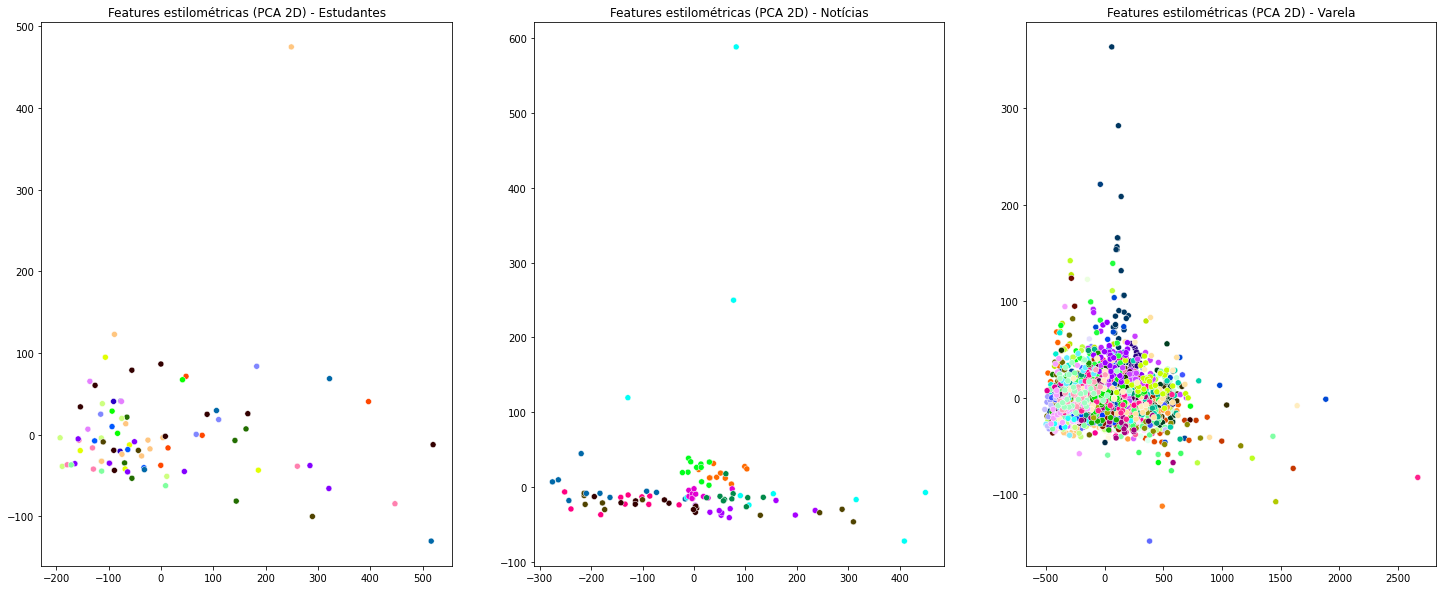

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot stylometric data on PCA + TSNE
#clear_columns([df, news_df, varela_df], 'TSNE-2d')
#clear_columns([df, news_df, varela_df], 'PCA')

# Feature reduction PCA d=2

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(25, 10)

sns.scatterplot(
    x="PCA-1", y="PCA-2",
    hue=encoded_Y,
    palette = generate_colormap(16),
    data=df_pca_2D,
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x="PCA-1", y="PCA-2",
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    data=news_pca_2D,
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x="PCA-1", y="PCA-2",
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    data=varela_pca_2D,
    legend=False,
    ax=ax3
)


set_title_and_labels(ax1, 'PCA 2D', 'Estudantes')
set_title_and_labels(ax2, 'PCA 2D', 'Notícias')
set_title_and_labels(ax3, 'PCA 2D', 'Varela')

plt.figure()

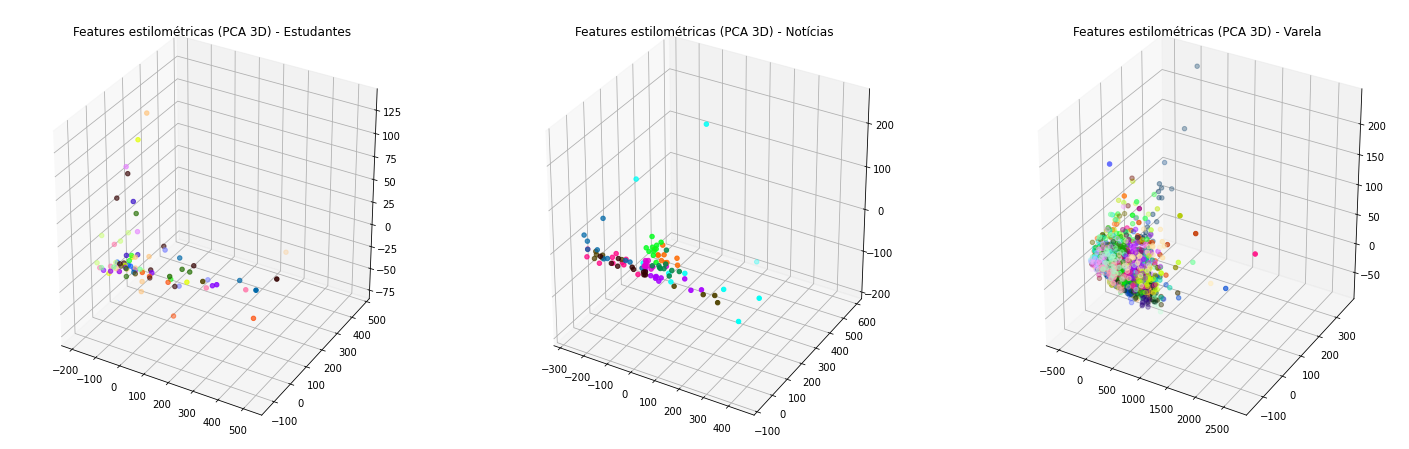

In [ ]:
# Plot stylometric data on PCA-3D
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(
    xs=df_pca_3D.loc[:]["PCA-1"], 
    ys=df_pca_3D.loc[:]["PCA-2"], 
    zs=df_pca_3D.loc[:]["PCA-3"], 
    c=encoded_Y, 
    cmap=generate_colormap(16),
)

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.scatter(
    xs=news_pca_3D.loc[:]["PCA-1"], 
    ys=news_pca_3D.loc[:]["PCA-2"], 
    zs=news_pca_3D.loc[:]["PCA-3"], 
    c=encoded_Y_news, 
    cmap=generate_colormap(10)
)

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.scatter(
    xs=varela_pca_3D.loc[:]["PCA-1"], 
    ys=varela_pca_3D.loc[:]["PCA-2"], 
    zs=varela_pca_3D.loc[:]["PCA-3"], 
    c=encoded_varela_Y, 
    cmap=generate_colormap(100)
)

set_title_and_labels(ax, 'PCA 3D', 'Estudantes', is_3d=True)
set_title_and_labels(ax1, 'PCA 3D', 'Notícias', is_3d=True)
set_title_and_labels(ax2, 'PCA 3D', 'Varela', is_3d=True)


fig.set_size_inches(25, 8)
plt.show()



<Figure size 432x288 with 0 Axes>

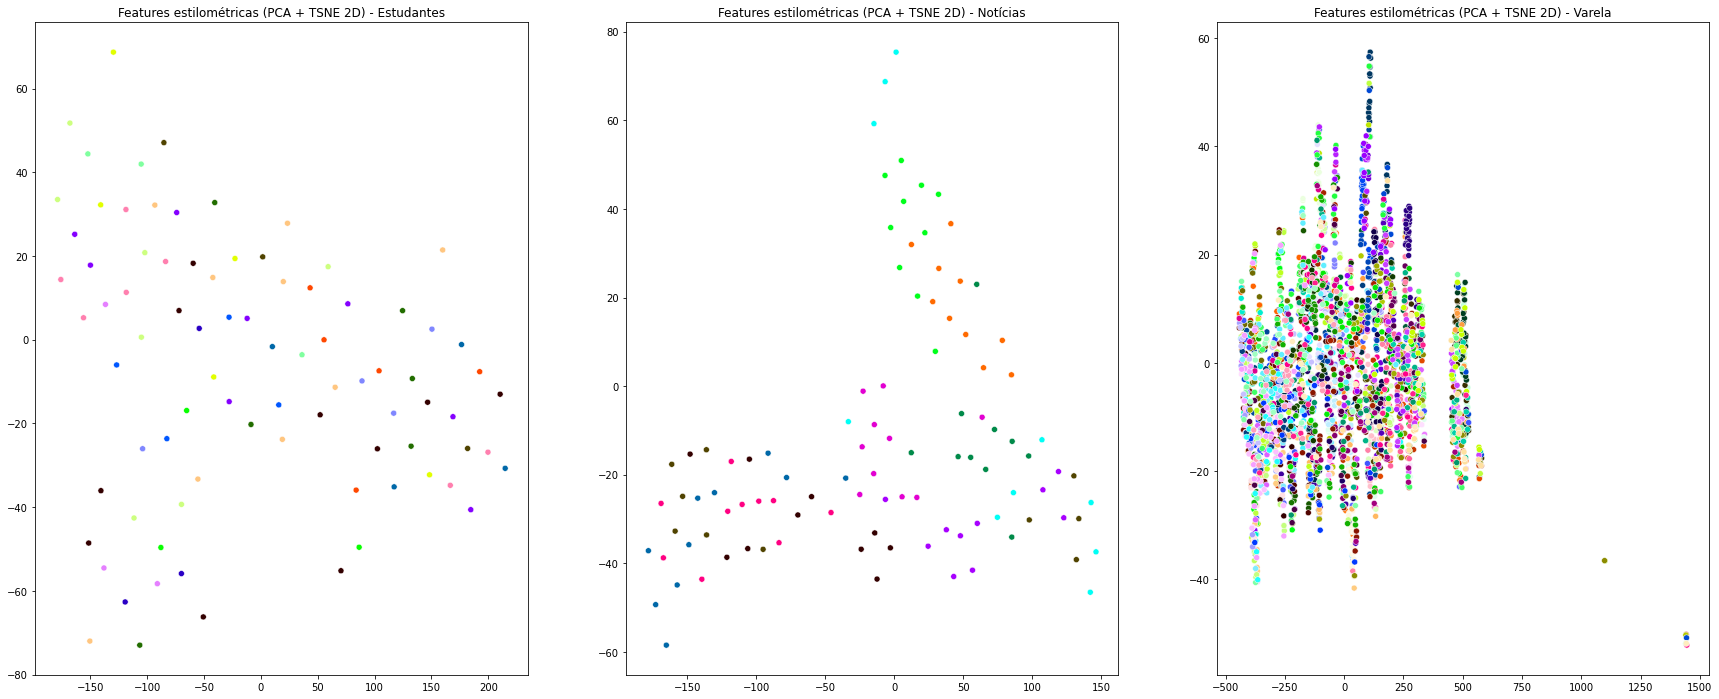

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot stylometric data on PCA-50D + TSNE-2D

#sharex='all', sharey='all'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(30, 12)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_Y,
    palette=generate_colormap(16),
    data=df_tsne_pca_2D,
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_Y_news,
    palette=generate_colormap(10),
    data=news_tsne_pca_2D,
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_varela_Y,
    palette=generate_colormap(100),
    data=varela_tsne_pca_2D,
    legend=False,
    ax=ax3
)

set_title_and_labels(ax1, 'PCA + TSNE 2D', 'Estudantes')
set_title_and_labels(ax2, 'PCA + TSNE 2D', 'Notícias')
set_title_and_labels(ax3, 'PCA + TSNE 2D', 'Varela')

plt.figure()
#TODO : Investigate Varela visualization - looking odd -.-'

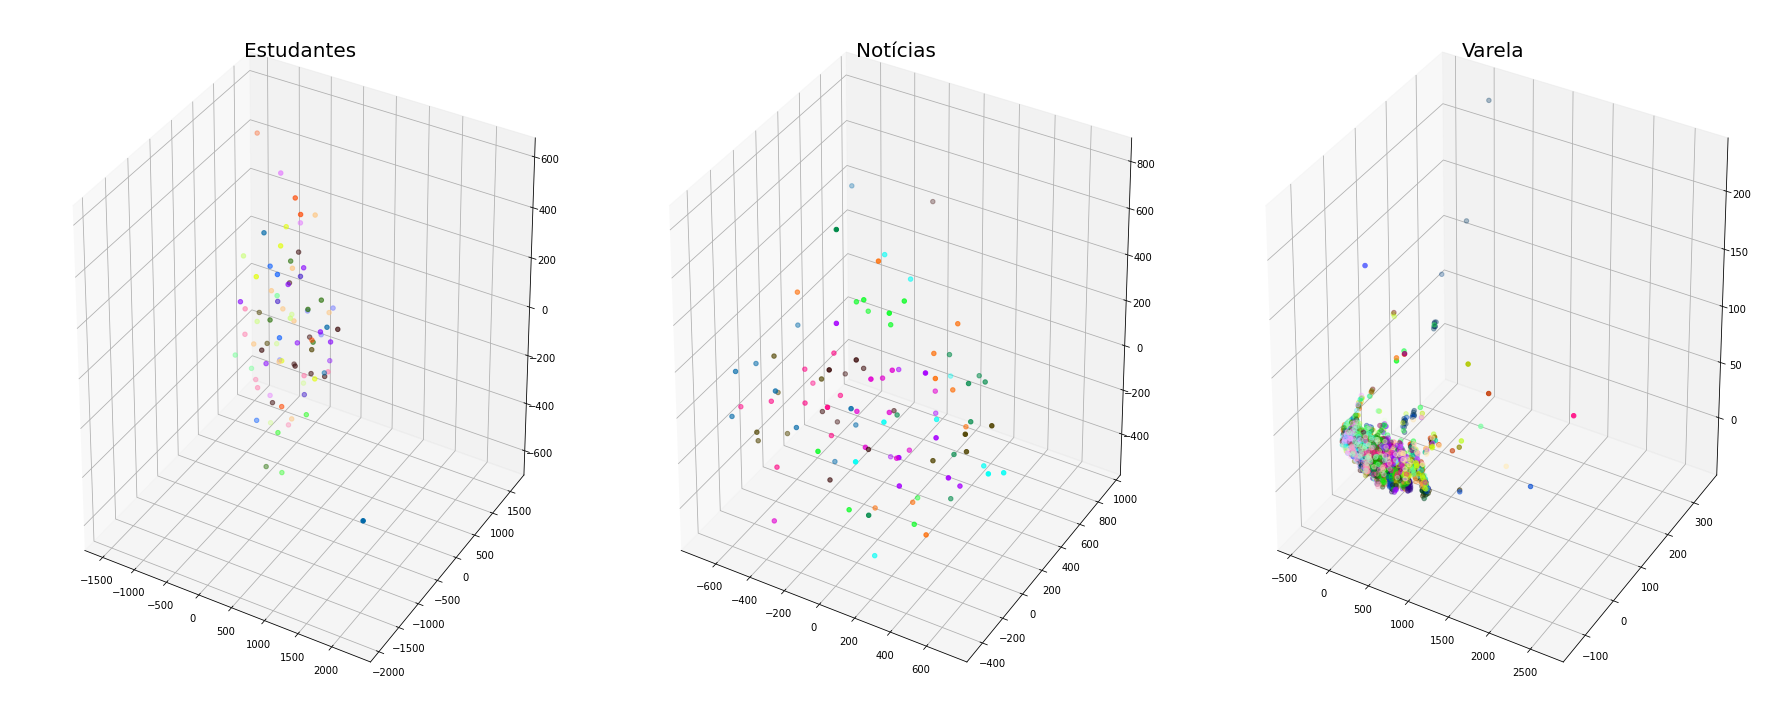

In [ ]:
# Plot stylometric data on PCA-50D + TSNE 3D
fig = plt.figure(figsize=(25,10))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(
    xs=df_tsne_pca_3D.loc[:]["TSNE-1"], 
    ys=df_tsne_pca_3D.loc[:]["TSNE-2"], 
    zs=df_tsne_pca_3D.loc[:]["TSNE-3"], 
    c=encoded_Y, 
    cmap=generate_colormap(16),
)

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.scatter(
    xs=news_tsne_pca_3D.loc[:]["TSNE-1"], 
    ys=news_tsne_pca_3D.loc[:]["TSNE-2"], 
    zs=news_tsne_pca_3D.loc[:]["TSNE-3"], 
    c=encoded_Y_news, 
    cmap=generate_colormap(10)
)

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.scatter(
    xs=varela_tsne_pca_3D.loc[:]["TSNE-1"], 
    ys=varela_tsne_pca_3D.loc[:]["TSNE-2"], 
    zs=varela_tsne_pca_3D.loc[:]["TSNE-3"], 
    c=encoded_varela_Y, 
    cmap=generate_colormap(100)
)

set_title_and_labels(ax, '', 'Estudantes', size=20, is_3d=True, title=False)
set_title_and_labels(ax1, '', 'Notícias', size=20, is_3d=True, title=False)
set_title_and_labels(ax2, '', 'Varela', size=20, is_3d=True, title=False)

plt.tight_layout()
#plt.show()



In [ ]:
# Train model for TNSE reduction and Scaled features

def build_tsne(dataframe, size):
  tsne = TSNE(n_components=size, verbose=1, perplexity=20, random_state=0, n_iter=3000)
  tsne_results = tsne.fit_transform(dataframe)
  dataframe['TSNE-2d-one'] = tsne_results[:,0]
  dataframe['TSNE-2d-two'] = tsne_results[:,1]
  dataframe['TSNE-2d-three'] = tsne_results[:,2]


In [ ]:
df_tsne_2D = build_components(df, 'TSNE', 2, 5000)
news_tsne_2D = build_components(news_df, 'TSNE', 2, 5000)
varela_tsne_2D =  build_components(varela_df, 'TSNE', 2, 5000)

df_tsne_3D = build_components(df, 'TSNE', 3, 5000)
news_tsne_3D = build_components(news_df, 'TSNE', 3, 5000)
varela_tsne_3D =  build_components(varela_df, 'TSNE', 3, 5000)

In [ ]:
df_tsne_2D

<Figure size 432x288 with 0 Axes>

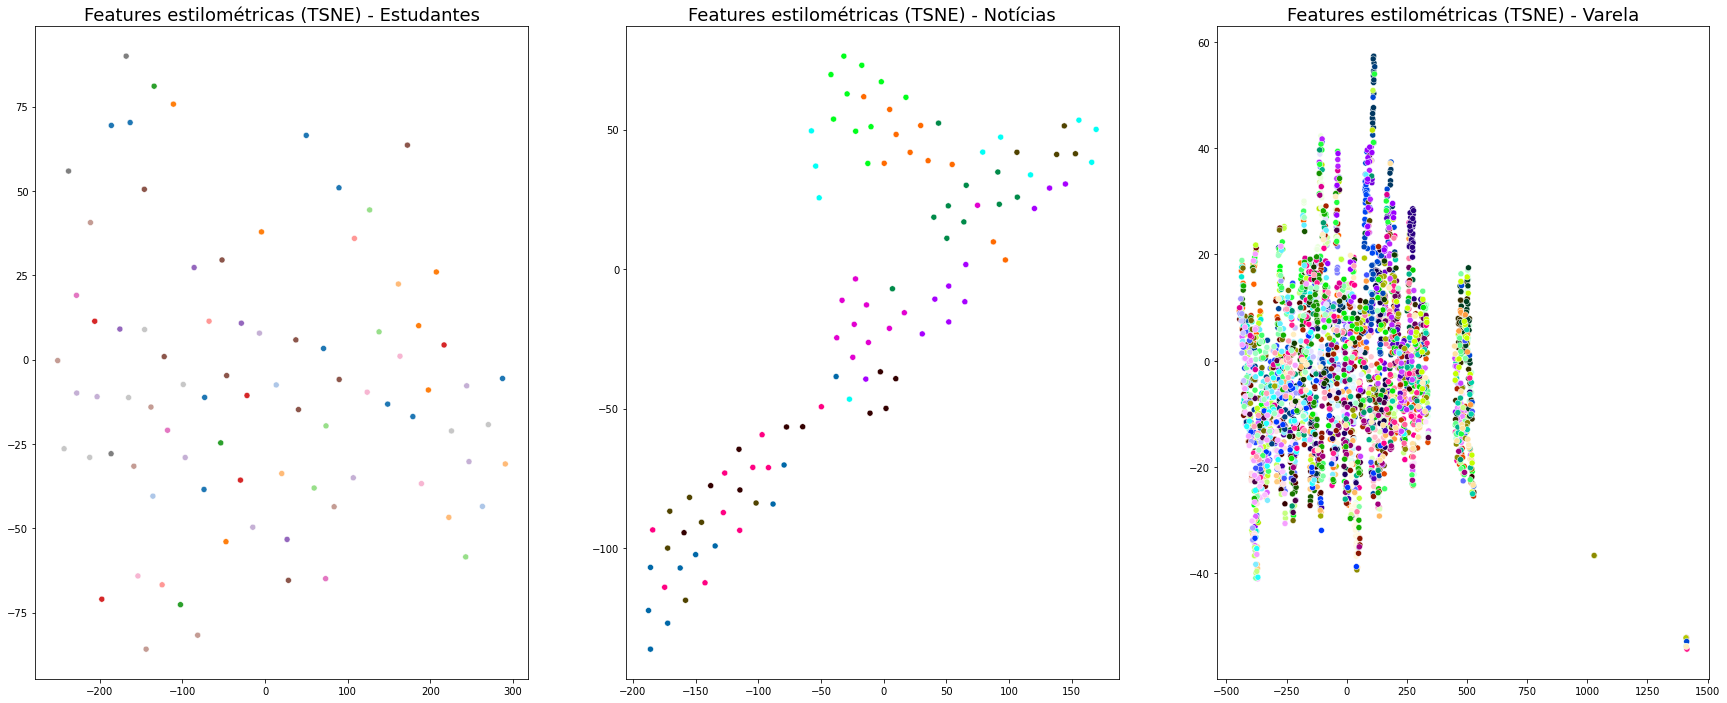

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot stylometric data on TSNE-2D

#sharex='all', sharey='all'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3 )
fig.set_size_inches(30, 12)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_Y,
    palette=sns.color_palette("tab20", 16),
    data=df_tsne_2D,
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_Y_news,
    palette=generate_colormap(10),
    data=news_tsne_2D,
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x="TSNE-1", y="TSNE-2",
    hue=encoded_varela_Y,
    palette=generate_colormap(100),
    data=varela_tsne_2D,
    legend=False,
    ax=ax3
)

set_title_and_labels(ax1, 'TSNE', 'Estudantes', size=18)
set_title_and_labels(ax2, 'TSNE', 'Notícias', size=18)
set_title_and_labels(ax3, 'TSNE', 'Varela', size=18)


plt.figure()
#clear_columns([df, news_df, varela_df], 'TSNE', size)
#TODO : Investigate Varela visualization - looking odd -.-'

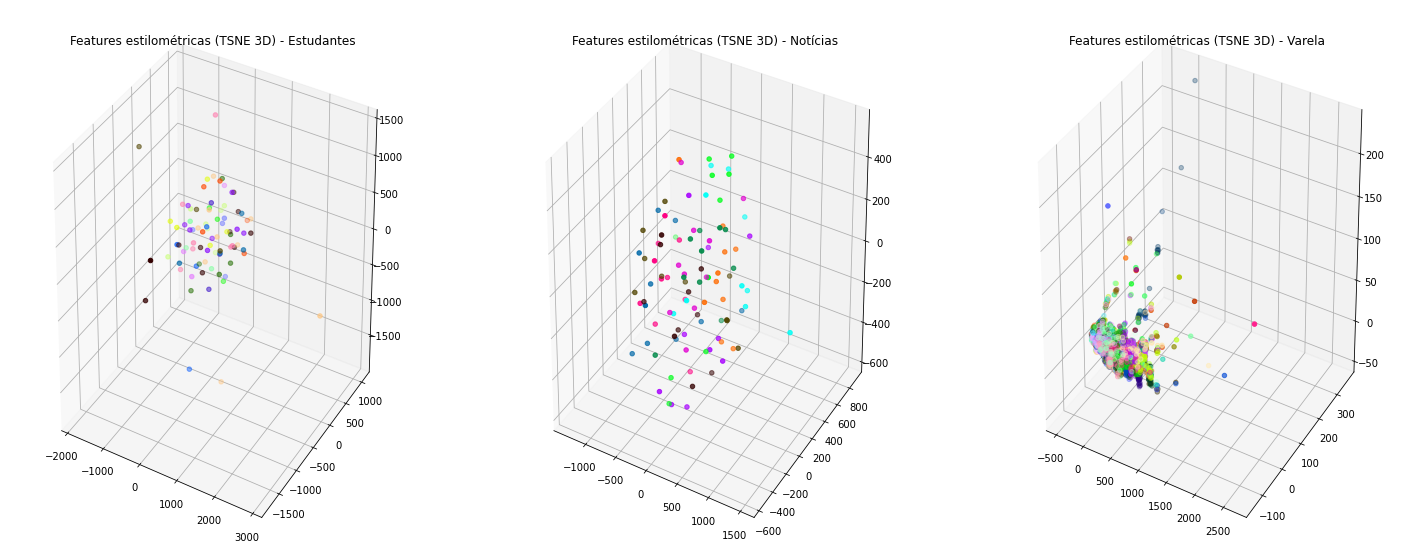

In [ ]:
# Plot stylometric data on TSNE-3D 

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(
    xs=df_tsne_3D.loc[:]["TSNE-1"], 
    ys=df_tsne_3D.loc[:]["TSNE-2"], 
    zs=df_tsne_3D.loc[:]["TSNE-3"], 
    c=encoded_Y, 
    cmap=generate_colormap(16),
)

ax1 = fig.add_subplot(1, 3, 2, projection='3d')

ax1.scatter(
    xs=news_tsne_3D.loc[:]["TSNE-1"], 
    ys=news_tsne_3D.loc[:]["TSNE-2"], 
    zs=news_tsne_3D.loc[:]["TSNE-3"], 
    c=encoded_Y_news, 
    cmap=generate_colormap(10)
)

ax2 = fig.add_subplot(1, 3, 3, projection='3d')

ax2.scatter(
    xs=varela_tsne_3D.loc[:]["TSNE-1"], 
    ys=varela_tsne_3D.loc[:]["TSNE-2"], 
    zs=varela_tsne_3D.loc[:]["TSNE-3"], 
    c=encoded_varela_Y, 
    cmap=generate_colormap(100)
)


set_title_and_labels(ax, 'TSNE 3D', 'Estudantes', is_3d=True)
set_title_and_labels(ax1, 'TSNE 3D', 'Notícias', is_3d=True)
set_title_and_labels(ax2, 'TSNE 3D', 'Varela', is_3d=True)

plt.show()

In [ ]:
#Prepare data for TF-IDF visualization
def red_dimen_with_idf(series, n_components=3):
  X_tfidf = TfidfVectorizer().fit_transform(series)
  return TruncatedSVD(n_components=n_components, random_state=42).fit_transform(X_tfidf) 

raw_student_3d  = red_dimen_with_idf(raw_df['Text'])
raw_news_3d  = red_dimen_with_idf(raw_news_df['Text'])
raw_varela_3d  = red_dimen_with_idf(raw_varela_df['Text'])

raw_student_2d = red_dimen_with_idf(raw_df['Text'],n_components=2)
raw_news_2d  = red_dimen_with_idf(raw_news_df['Text'], n_components=2)
raw_varela_2d  = red_dimen_with_idf(raw_varela_df['Text'], n_components=2)

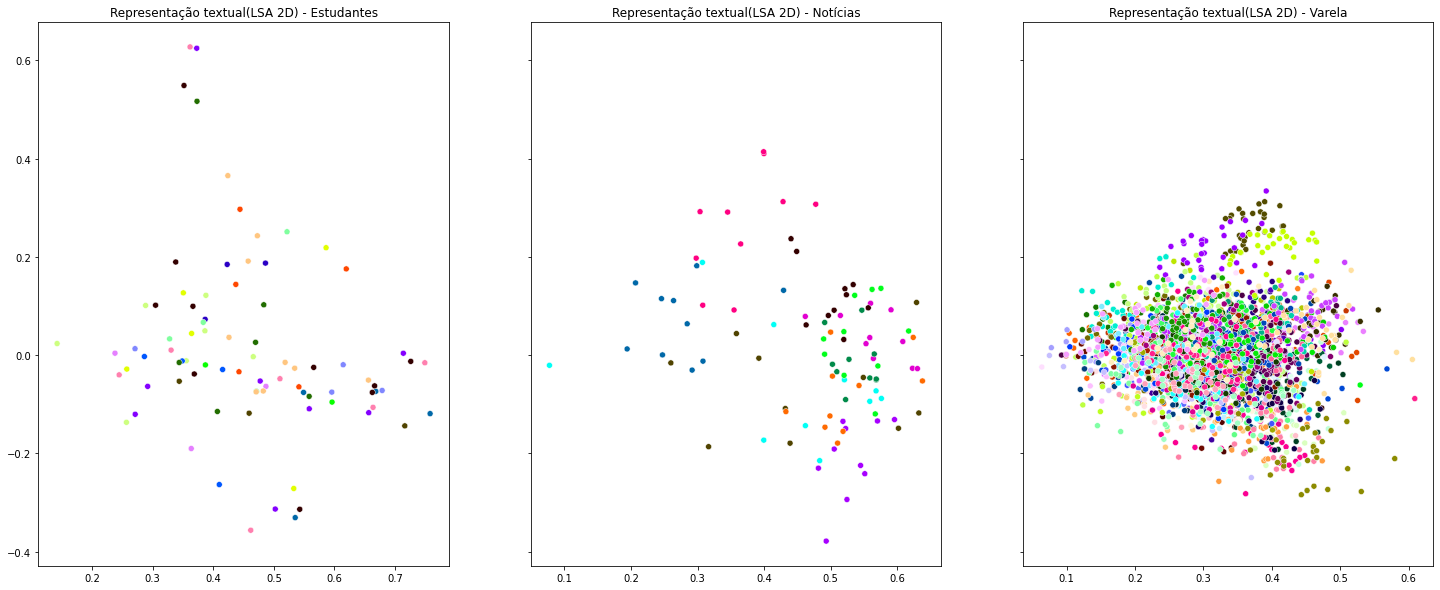

<Figure size 432x288 with 0 Axes>

In [ ]:
#TF-IDF LSA 2D

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all')
fig.set_size_inches(25, 10)

sns.scatterplot(
    x=raw_student_2d[:,0],
    y=raw_student_2d[:,1],
    hue=encoded_raw_Y,
    palette = generate_colormap(16),
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x=raw_news_2d[:,0], 
    y=raw_news_2d[:,1],
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x=raw_varela_2d[:,0],
    y=raw_varela_2d[:,1],
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    legend=False,
    ax=ax3
)

plt.figure()

set_title_and_labels(ax1, 'LSA 2D', 'Estudantes', stylo=False)
set_title_and_labels(ax2, 'LSA 2D', 'Notícias' , stylo=False)
set_title_and_labels(ax3, 'LSA 2D', 'Varela' , stylo=False)

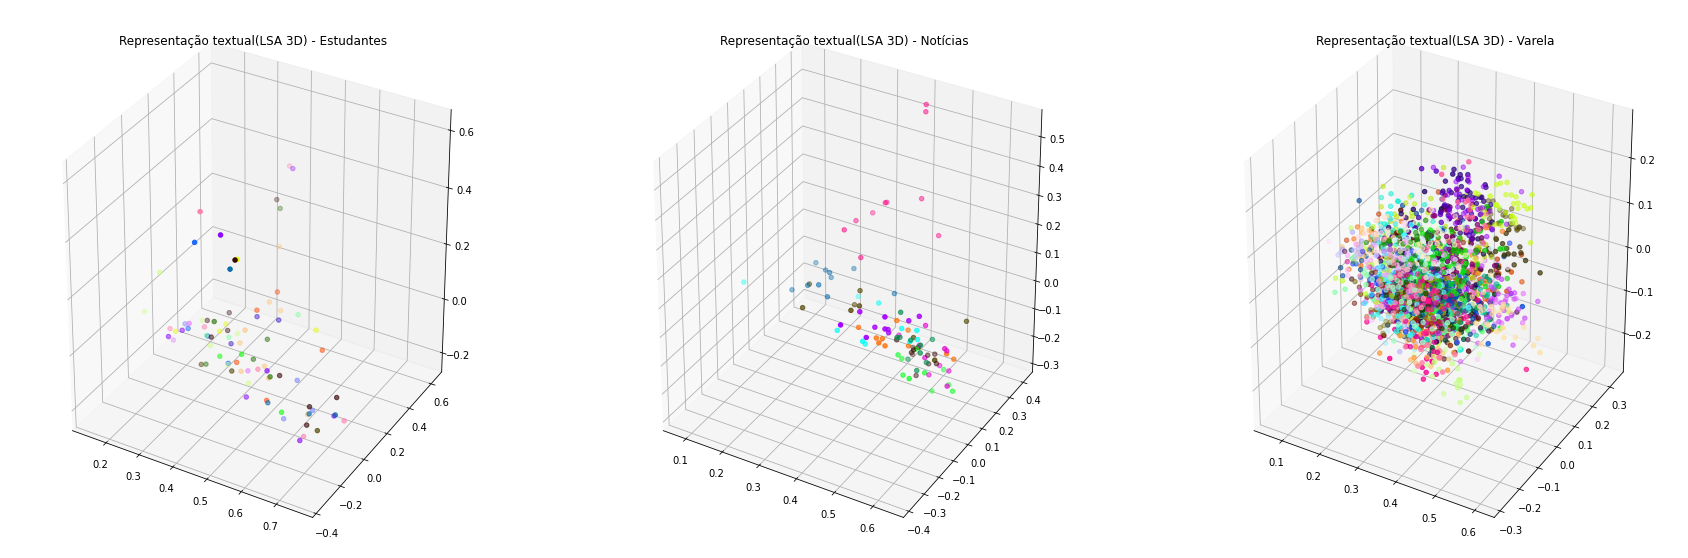

In [ ]:
#TF-IDF LSA 3D
def scatter_3d(ax, X, y, size):
  ax.scatter(
      xs=X[:, 0], 
      ys=X[:, 1], 
      zs=X[:, 2], 
      c=y, 
      cmap=generate_colormap(size)  
  )

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

scatter_3d(ax, raw_student_3d, encoded_raw_Y, 16)
scatter_3d(ax1, raw_news_3d, encoded_Y_news, 10)
scatter_3d(ax2, raw_varela_3d, encoded_varela_Y, 100)

set_title_and_labels(ax, 'LSA 3D', 'Estudantes', is_3d=True, stylo=False)
set_title_and_labels(ax1, 'LSA 3D', 'Notícias', is_3d=True, stylo=False)
set_title_and_labels(ax2, 'LSA 3D', 'Varela', is_3d=True, stylo=False)

plt.show()

In [ ]:
# Plot word-embedding visualization
# Download gloVe word embedding for portuguese-BR (100-dimensions)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

fluff, id = glove_50_link.split('=')
glove_file_name = 'glove_s50.txt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(glove_file_name)
glove_file_name

# Load the embedding into a dictionary (eg: {'oi' : n1, n2, ..., n100})
word_embedding_dict = {}
with open(glove_file_name, 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)  
    coefs = np.fromstring(coefs, 'f', sep=' ')
    word_embedding_dict[word] = coefs

In [ ]:
def build_matrix(corpus, dim_size, word_dict):
  tokenizer = Tokenizer(num_words=140000)
  tokenizer.fit_on_texts(corpus)
  # Convert strings to their corresponding integer value created by the Tokenizer
  embedded_sentences = tokenizer.texts_to_sequences(corpus)
  max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
  max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
  padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')
  vocab_len = len(tokenizer.word_index) + 1

  # Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
  # In the end we will have a matrix of all our vocabulary x 50 dimensions (size of glove dim)

  # initialize with all zeros
  embedding_matrix = np.zeros((vocab_len, dim_size))
  for word, index in tokenizer.word_index.items():
    embedding_vector = word_dict.get(word)
    # if the word is in gloVe, we will use its weigths 
    if embedding_vector is not None and embedding_vector.any():
      embedding_matrix[index] = embedding_vector[:dim_size]
  return embedding_matrix, 


# Those matrixes are not necessary for visualization
student_glove_50 = build_matrix(corpus, 50, word_embedding_dict)
news_glove_50 = build_matrix(corpus_news, 50, word_embedding_dict)
varela_glove_50 = build_matrix(corpus_varela, 50, word_embedding_dict)


In [ ]:
def convert_docs_to_embeddings(corpus, word_dict, dim_size):
  tokenizer = Tokenizer(num_words=40000)
  tokenizer.fit_on_texts(corpus)
  
  max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
  max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
  vocab_len = len(tokenizer.word_index) + 1

  docs = np.zeros((len(corpus), vocab_len, dim_size))
  
  for index, doc in enumerate(corpus):
    current_doc = np.zeros((vocab_len, dim_size))
    # NOTE: I realized that nltk.word_tokenize has a different behavior than split ''
    for word in doc.split(' '):
      embedding_vector = word_dict.get(word)
      if word.isalnum() and embedding_vector is not None and embedding_vector.any():
        idx = tokenizer.word_index[word]
        current_doc[idx] = embedding_vector[:dim_size]
    docs[index] = current_doc
  return docs
    

student_embedded_docs = convert_docs_to_embeddings(corpus, word_embedding_dict, 50)
#news_embedded_docs = convert_docs_to_embeddings(corpus_news, word_embedding_dict, 50)

# Crashing out of RAM
#varela_embedded_docs = convert_docs_to_embeddings(corpus_varela_sw, word_embedding_dict, 50)

In [ ]:
# cleaning up stopwords from Varela to see if memory can handle now
corpus_varela.shape

corpus_varela_sw = corpus_varela.apply(lambda x: [str(item) for item in x.split(' ') if item not in stopwords])
corpus_varela_sw = corpus_varela_sw.apply(lambda x: ' '.join(x))
corpus_varela_sw

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


def build_doc2vec(corpus, vec_size, epochs=100):
  tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]
  
  max_epochs = 100
  alpha = 0.025

  model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

  model.build_vocab(tagged_data)

  print('start training Doc2Vec')
  for epoch in range(max_epochs):
    model.train(tagged_data,total_examples=model.corpus_count,epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
  return model


student_d2vec_model = build_doc2vec(corpus, 80, 50)
news_d2vec_model = build_doc2vec(corpus_news, 80, 50)
varela_d2vec_model = build_doc2vec(corpus_varela, 80, 40)

start training Doc2Vec


In [ ]:
varela_d2vec_model = build_doc2vec(corpus_varela, 100, 40)

start training Doc2Vec


In [ ]:
student_doc2vec_2d = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(student_d2vec_model.docvecs.vectors_docs))
news_doc2vec_2d = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(news_d2vec_model.docvecs.vectors_docs))
varela_doc2vec_2d = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(varela_d2vec_model.docvecs.vectors_docs))

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 10.850708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.145096
[t-SNE] KL divergence after 3250 iterations: 0.491894
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 10.582199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.896729
[t-SNE] KL divergence after 4000 iterations: 0.569353
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.024s...
[t-SNE] Computed neighbors for 3000 samples in 1.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000


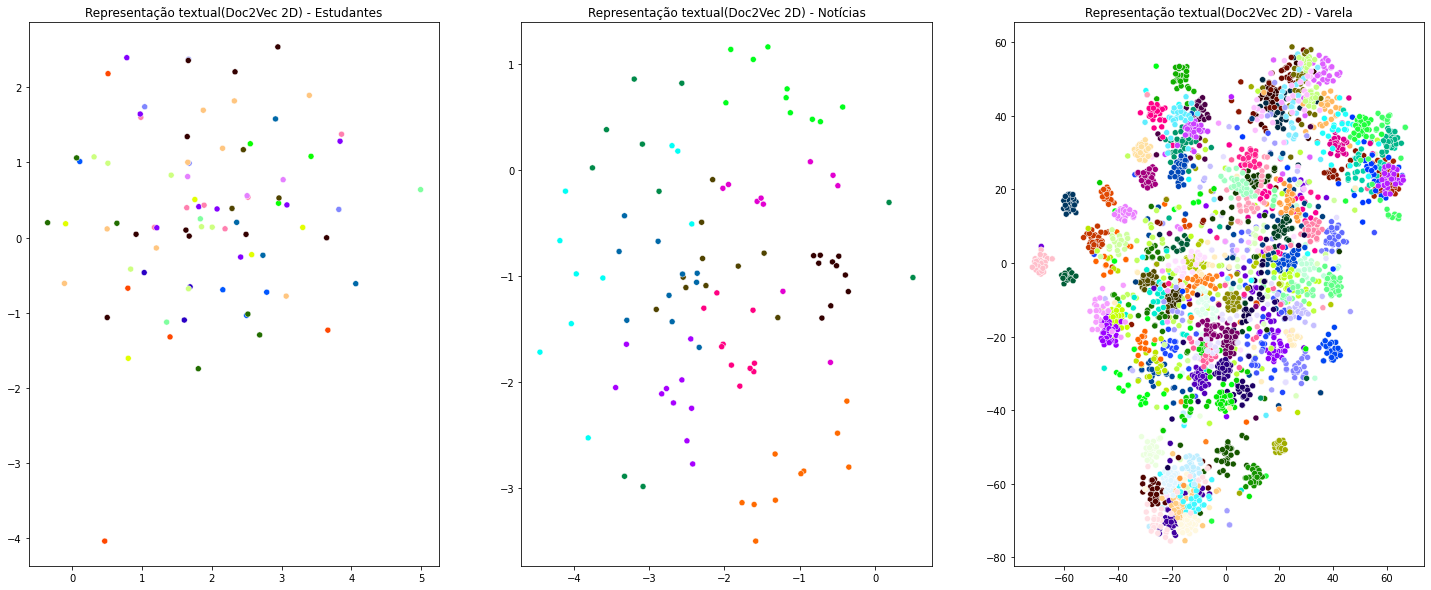

<Figure size 432x288 with 0 Axes>

In [ ]:
#Doc2Vec PCA+TSNE 2D
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(25, 10)

sns.scatterplot(
    x=student_doc2vec_2d[:,0],
    y=student_doc2vec_2d[:,1],
    hue=encoded_raw_Y,
    palette = generate_colormap(16),
    legend=False,
    ax=ax1
)


sns.scatterplot(
    x=news_doc2vec_2d[:,0], 
    y=news_doc2vec_2d[:,1],
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x=varela_doc2vec_2d[:,0],
    y=varela_doc2vec_2d[:,1],
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    legend=False,
    ax=ax3
)

plt.figure()

set_title_and_labels(ax1, 'Doc2Vec 2D', 'Estudantes',stylo=False)
set_title_and_labels(ax2, 'Doc2Vec 2D', 'Notícias',stylo=False )
set_title_and_labels(ax3, 'Doc2Vec 2D', 'Varela',stylo=False)


In [ ]:
student_doc2vec_3d = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(student_d2vec_model.docvecs.vectors_docs))
news_doc2vec_3d = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(news_d2vec_model.docvecs.vectors_docs))
varela_doc2vec_3d = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=4000).fit_transform(PCA(n_components=50, random_state=0).fit_transform(varela_d2vec_model.docvecs.vectors_docs))

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.001s...
[t-SNE] Computed neighbors for 84 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 11.864953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 162.616150
[t-SNE] KL divergence after 4000 iterations: 1.092188
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 14.638328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 167.133209
[t-SNE] KL divergence after 4000 iterations: 1.224346
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.030s...
[t-SNE] Computed neighbors for 3000 samples in 1.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 300

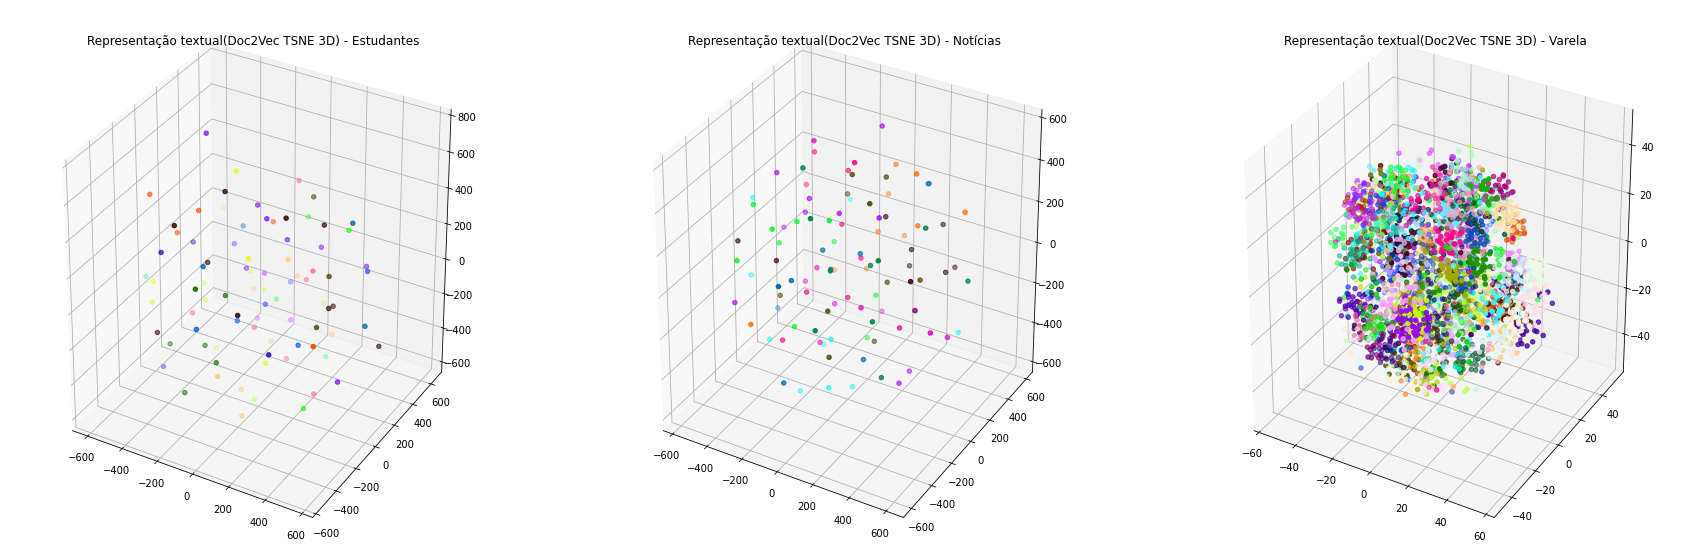

In [ ]:
#Doc2Vec PCA+ TSNE 3D

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

scatter_3d(ax, student_doc2vec_3d, encoded_raw_Y, 16)
scatter_3d(ax1, news_doc2vec_3d, encoded_Y_news, 10)
scatter_3d(ax2, varela_doc2vec_3d, encoded_varela_Y, 100)


set_title_and_labels(ax, 'Doc2Vec TSNE 3D', 'Estudantes', is_3d=True, stylo=False)
set_title_and_labels(ax1, 'Doc2Vec TSNE 3D', 'Notícias', is_3d=True, stylo=False)
set_title_and_labels(ax2, 'Doc2Vec TSNE 3D', 'Varela', is_3d=True, stylo=False)

plt.show()

In [ ]:
# Train model for TNSE reduction and Scaled features

def build_tsne_for_embeddings(embedded, size):
  return TSNE(n_components=size, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(embedded)

student_glove_tsne = build_tsne_for_embeddings(student_glove_50, 3)
#build_tsne(news_df, 3)
#build_tsne(varela_df, 3)



In [ ]:
student_d2vec_model.docvecs.doctag_syn0

array([[ 1.7835715 , 15.866274  , -1.6302868 , ..., -0.7584589 ,
         2.929148  , -7.7762284 ],
       [ 2.7615895 ,  3.8477573 ,  0.28176612, ..., -7.4455457 ,
        -5.0023375 , -5.023767  ],
       [ 3.2457333 ,  1.9612633 , -1.2996215 , ..., -1.4965936 ,
        -2.7861054 , -4.277899  ],
       ...,
       [ 6.252587  ,  1.9413368 , -4.7684855 , ..., -1.5421988 ,
        -0.33577758, -3.823419  ],
       [-2.80423   ,  3.0020366 ,  0.27886695, ..., -5.9081845 ,
        -2.5413854 , -7.030723  ],
       [-1.9090767 ,  4.29356   , -2.8759527 , ..., -0.46316764,
        -3.6423473 , -7.7221537 ]], dtype=float32)

In [ ]:
#student_d2vec_model

kclusterer = KMeansClusterer(2, distance=nltk.cluster.util.cosine_distance, repeats=100)
assigned_clusters_student = kclusterer.cluster(student_d2vec_model.docvecs.doctag_syn0, assign_clusters=True)

# kclusterer = KMeansClusterer(3, distance=nltk.cluster.util.cosine_distance, repeats=100)
# assigned_clusters_news = kclusterer.cluster(news_d2vec_model.docvecs.doctag_syn0, assign_clusters=True)

# kclusterer = KMeansClusterer(2, distance=nltk.cluster.util.cosine_distance, repeats=100)
# assigned_clusters_varela = kclusterer.cluster(varela_d2vec_model.docvecs.doctag_syn0, assign_clusters=True)

In [ ]:
kclusterer = KMeansClusterer(2, distance=nltk.cluster.util.euclidean_distance, repeats=100)
assigned_clusters_student_stylo = kclusterer.cluster(df.values, assign_clusters=True)

kclusterer = KMeansClusterer(2, distance=nltk.cluster.util.euclidean_distance, repeats=100)
assigned_clusters_news_stylo = kclusterer.cluster(news_df.values, assign_clusters=True)

kclusterer = KMeansClusterer(10, distance=nltk.cluster.util.euclidean_distance, repeats=100)
assigned_clusters_varela_stylo = kclusterer.cluster(varela_df.values, assign_clusters=True)

In [ ]:
print(assigned_clusters_student)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


In [ ]:
print(assigned_clusters_news_stylo)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(assigned_clusters_varela_stylo)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 7, 7, 1, 4, 6, 4, 6, 5, 2, 4, 7, 1, 3, 6, 1, 6, 4, 7, 2, 7, 3, 5, 0, 4, 2, 7, 1, 7, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 4, 5, 6, 6, 3, 4, 4, 4, 5, 7, 6, 7, 5, 6, 4, 5, 4, 6, 5, 6, 5, 5, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 7, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 4, 2, 2, 2, 2, 4, 2, 1, 4, 2, 1, 3, 4, 1, 2, 2, 3, 2, 2, 2, 7, 4, 4, 2, 3, 1, 2, 2, 2, 1, 2, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 2, 

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df.values.T, 16, 2, error=0.005, maxiter=1000, init=None)
assigned_clusters_student_stylo = np.argmax(u, axis=0)

84

In [ ]:
len(np.argmax(u, axis=0))

80

In [ ]:
# cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(student_d2vec_model.docvecs.doctag_syn0.T, 2, 2, error=0.005, maxiter=1000, init=None)
# assigned_clusters_student = np.argmax(u, axis=0)
# print(assigned_clusters_student)

# cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(news_d2vec_model.docvecs.doctag_syn0.T, 2, 2, error=0.005, maxiter=1000, init=None)
# assigned_clusters_news = np.argmax(u, axis=0)
# print(assigned_clusters_news)


cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df.values.T, 8, 2, error=0.005, maxiter=1000, init=None)
assigned_clusters_student_stylo = np.argmax(u, axis=0)
print(assigned_clusters_student_stylo)

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(news_df.values.T, 7, 2, error=0.005, maxiter=1000, init=None)
assigned_clusters_news_stylo = np.argmax(u, axis=0)
print(assigned_clusters_news_stylo)

[3 5 7 3 1 4 4 7 4 5 5 1 4 7 4 5 0 0 7 5 4 5 0 3 3 3 3 0 7 1 3 7 5 5 7 3 3
 1 0 0 2 1 7 1 5 3 1 1 2 2 2 0 7 7 7 5 1 5 6 2 1 0 0 1 3 7 3 3 3 3 3 7 7 1
 6 3 0 0 7 1 7 7 6 2]
[2 2 0 4 4 4 4 4 2 0 1 5 1 0 1 5 5 5 5 5 1 1 1 1 1 2 6 6 6 5 5 0 1 1 1 1 5
 5 1 1 3 4 3 3 4 3 4 3 3 4 6 6 6 2 3 5 4 4 3 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0
 0 0 4 0 0 0 5 5 0 0 5 0 1 0 5 0 0 4 4 4 4 4 2 4 4 4]


In [ ]:
assigned_clusters_student

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
assigned_clusters_news_stylo

array([7, 1, 6, 4, 4, 4, 4, 4, 1, 6, 0, 9, 2, 6, 2, 5, 5, 9, 9, 5, 2, 2,
       2, 2, 2, 1, 7, 7, 7, 5, 5, 6, 2, 0, 2, 0, 9, 5, 0, 0, 8, 4, 8, 8,
       4, 8, 4, 8, 8, 1, 3, 7, 3, 1, 8, 9, 1, 4, 8, 6, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 9, 9, 6, 5, 5, 6, 2, 6,
       9, 6, 6, 4, 4, 4, 4, 1, 1, 1, 4, 4])

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(varela_d2vec_model.docvecs.doctag_syn0.T, 2, 2, error=0.005, maxiter=1000, init=None)
assigned_clusters_varela = np.argmax(u, axis=0)
with np.printoptions(threshold=np.inf):
    print(assigned_clusters_varela)

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0
 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0
 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(varela_df.values.T, 72, 2, error=0.005, maxiter=1000, init=None)
assigned_clusters_varela_stylo = np.argmax(u, axis=0)
with np.printoptions(threshold=np.inf):
    print(assigned_clusters_varela_stylo)

[67 10 10 22 23 59  5 17 17 64 27 10  5 22 22 59  5  5  2  5 67 10 22 67
  5 22  5  5 59 53 28 16  6 68 39 28 13 16 42 67  3 16 42 65  4 52 26 51
 31 13 32 13 70 59 69 28 47  6 54  6 67 67 27 27 27 27 27 67 27 27  5 27
 27 67 27  2 27 27 27 27 27 27 27 27 27 27 27 27 27 67 53 22 23 38 12 53
 17 59 18 59 38 53 46  8 31  9 59 71 42 71 53 38  9 59 21 40 17 38 17  5
 61 15 54 43 57 30 43 15 43 65 13 32 30 15 39 39 54 34 30 62 26 65 26 32
 34 39  3 41 54 16 47 47 62 47 16 32 30 18 15 54 19  9 30 15 47 70 47 47
 66 55 18  9 47  4 30 62 15 15 54 15  8 60 58 61 19 61 58 61 70 25 25 61
 25 70 58 61 58 58 58  4 61 58 28 58  8 61 60  8  8 61 50 68 35 50 50 36
  6 11 50 50 50 44 11 50  6 50 11 36 50 50 68 35 36 48 35  7 36 44 35 36
  2 23 59 59 59 53  5 60 17  9 59 17 52 59 53 23 17 23 22 10 17 12 23 17
 12 53 22 53 38 38  5 24  2 10 17 17 10 10 10 10 17 24 10 24 17 17 10 59
 10 10 17  2 10 10 10 10 17  2  2  2 64 27 64 64 27 27 64 64 64 64 64 27
 64 64  2  2 64 22 64 27 27 27 64 64 27 27  2 27 27

In [ ]:
assigned_fuzzy_clusters_varela = [19 ,86 ,67 ,91 ,91 ,76 ,19 ,19 ,72 ,72 ,62 ,22 ,76 ,62 ,76 ,67 ,67 ,22 ,91 ,98 ,72 ,67 ,91 ,72
, 14 ,72 ,98 ,91 ,76 ,76 ,91 ,90 ,91 ,58 ,10 ,91 ,70 ,91 ,40 ,91 ,91 ,91 ,71 ,71 ,31 ,19 ,70 ,91
, 91 ,70 ,40 ,19 ,91 ,91 ,70 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,31 ,31 ,14 ,58 , 8 ,72 ,26 ,14 ,31 ,14
, 51 ,31 ,51 ,72 ,19 ,14 ,51 ,19 ,31 ,19 ,22 ,31 ,31 ,31 ,31 ,70 , 8 ,70 ,72 ,72 ,76 ,76 ,72 ,76
, 72 ,72 ,72 ,76 ,72 ,76 ,76 ,76 ,72 ,76 ,98 ,72 ,76 ,72 ,72 ,76 ,72 ,72 ,72 ,91 ,72 ,72 ,76 ,76
, 70 ,14 ,70 ,14 ,70 ,70 ,70 ,70 ,14 ,51 ,14 ,70 ,58 ,14 ,70 ,14 ,70 ,70 ,62 ,51 ,70 ,14 ,67 ,14
, 14 ,14 ,70 ,70 ,88 ,70 ,98 ,98 ,72 ,98 ,98 ,72 ,31 ,31 ,91 ,98 ,98 ,31 ,72 ,98 ,98 ,98 ,57 ,98
, 98 ,62 ,98 ,57 ,72 ,76 ,72 ,31 ,98 ,98 ,98 ,72 ,98 ,98 ,72 ,76 ,91 ,70 ,91 ,19 ,72 ,58 ,72 ,70
, 19 ,72 ,19 ,19 ,98 ,91 ,91 ,70 ,91 ,91 ,70 ,58 ,91 ,58 ,19 ,91 ,98 ,19 ,76 ,91 ,91 ,91 ,98 ,15
, 91 ,70 ,67 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,76 ,76 ,91 ,91 ,67 ,91 ,91 ,91 ,91 ,76 ,91 ,91 ,91 ,91
, 91 ,91 ,91 ,91 ,71 ,14 ,91 ,91 ,91 ,91 ,76 ,20 ,91 ,98 ,76 ,76 ,78 ,91 ,91 ,91 ,76 ,91 ,94 ,91
, 91 ,91 ,91 ,91 ,78 ,72 ,72 ,72 ,76 ,72 ,76 ,72 ,72 ,72 ,76 ,76 ,76 ,72 ,72 ,72 ,31 ,76 ,57 ,72
, 19 ,72 ,72 ,31 ,72 ,31 ,57 ,72 ,72 ,31 ,31 ,72 ,31 ,31 ,67 ,14 ,31 ,31 ,86 ,31 ,31 ,31 ,67 ,31
, 72 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,14 ,14 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,75 ,67 ,89 ,75 ,75 ,76
, 34 ,67 ,26 ,75 ,90 ,75 ,26 ,75 ,70 ,14 ,75 ,90 ,14 ,75 ,90 ,31 ,14 ,14 ,89 ,70 ,31 ,14 ,90 , 8
, 14 ,14 ,67 ,14 ,14 ,67 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14
, 14 ,34 ,14 ,14 ,14 ,14 ,67 ,31 ,67 ,75 ,67 ,31 ,31 ,34 ,31 ,14 ,14 ,14 ,14 ,14 ,26 ,67 ,67 ,67
, 75 ,14 ,67 ,14 ,67 ,67 ,14 ,31 ,67 ,67 ,14 ,67 ,14 ,75 ,31 ,75 ,67 ,15 ,14 ,75 ,14 ,70 ,14 ,14
, 14 ,14 ,14 ,62 ,70 ,14 ,70 ,14 ,67 ,19 ,14 ,75 ,58 ,31 ,14 ,75 ,14 ,75 ,70 ,14 ,14 ,23 ,75 ,67
, 70 ,76 ,76 ,23 ,34 ,76 ,76 ,34 ,14 ,75 ,90 ,76 ,56 ,76 ,76 ,67 ,67 ,14 ,14 ,67 ,14 ,67 ,14 ,67
, 90 ,67 ,31 ,75 ,26 ,75 ,75 ,26 ,34 ,26 ,67 ,75 ,75 ,75 ,34 ,90 ,90 ,90 ,67 ,90 ,78 ,70 ,86 ,14
, 14 ,26 ,26 ,40 ,34 ,89 ,67 ,23 ,14 ,54 ,23 ,67 ,74 ,23 ,14 ,48 ,14 ,67 ,40 ,74 ,58 ,76 ,76 ,89
, 78 ,50 ,67 ,14 ,58 ,34 ,89 ,48 ,54 ,14 ,89 ,23 ,14 ,86 ,26 ,67 ,27 ,14 ,26 ,26 ,14 ,27 ,86 ,26
, 14 ,23 ,26 ,31 ,23 ,34 ,34 ,34 ,14 ,26 ,72 ,34 ,40 ,34 ,86 ,86 ,14 ,34 ,34 ,14 ,31 ,31 ,14 ,98
, 75 ,31 ,31 ,14 ,57 ,20 ,31 ,70 ,34 ,14 ,31 ,31 ,75 ,14 ,31 ,14 ,14 ,14 ,14 ,76 ,31 ,31 ,26 ,14
, 67 ,14 ,14 ,14 ,14 ,78 ,54 ,54 ,54 ,14 ,54 ,54 ,14 ,14 ,54 ,14 ,54 ,54 ,78 ,48 ,14 ,54 ,14 ,67
, 14 ,14 ,14 ,14 ,14 ,14 ,16 ,26 ,54 ,14 ,16 ,26 ,54 ,54 ,14 ,23 ,14 ,48 ,23 ,14 ,54 ,54 ,14 ,16
, 54 ,14 ,54 ,23 ,54 ,54 ,16 ,27 ,54 ,54 ,16 ,27 ,14 ,14 ,80 ,78 ,14 ,91 ,91 ,14 ,72 ,14 ,76 ,31
, 31 ,31 ,91 ,77 ,78 ,70 ,31 ,31 ,31 ,76 ,57 ,23 ,18 ,26 ,14 ,57 ,31 ,57 ,78 ,54 ,23 ,56 ,78 ,54
, 26 ,14 ,54 ,54 ,23 ,78 ,14 ,48 ,78 ,14 ,23 ,48 ,54 ,54 ,14 ,23 ,23 ,14 ,75 ,54 ,54 ,41 ,54 ,54
, 14 ,10 ,58 ,67 ,80 ,67 ,91 ,14 ,80 ,14 ,14 ,74 ,14 ,91 ,10 ,14 ,14 ,10 ,78 ,91 ,14 ,14 ,14 ,80
, 14 ,14 ,74 ,19 ,14 ,14 ,54 ,54 ,14 ,54 ,78 ,54 ,14 ,16 ,48 ,14 ,14 ,54 ,15 ,40 ,14 ,78 ,75 ,14
, 75 ,14 ,14 ,78 ,14 ,54 ,14 ,16 ,78 ,54 ,54 ,54 ,20 ,54 ,70 ,14 ,78 ,98 ,48 ,78 ,91 ,78 ,54 ,54
, 14 ,15 ,58 ,14 ,14 ,78 ,58 ,67 ,14 ,54 ,54 ,54 ,54 ,14 ,54 ,54 ,78 ,58 ,14 ,14 ,48 ,78 ,76 ,91
, 54 ,14 ,76 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,91 ,70 ,78 ,70 ,14 ,14 ,14 ,54 ,91 ,76 ,76 ,49 ,86 ,14
, 14 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,15 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,14 ,14 ,14 ,14 ,67 ,54 ,14 ,14
, 14 ,14 ,14 ,14 ,14 ,14 ,80 ,14 ,14 ,67 ,48 ,14 ,67 ,48 ,14 ,67 ,14 ,14 ,14 ,14 ,48 ,91 ,14 ,54
, 67 ,28 ,67 ,48 ,91 ,91 ,14 ,14 ,67 ,67 ,13 ,14 ,78 ,78 ,78 ,78 ,91 ,78 ,78 ,78 ,78 ,78 ,78 ,78
, 78 ,78 ,78 ,91 ,78 ,78 ,91 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,49 ,78 ,40 ,20 ,20 ,78 ,70 ,78
, 78 ,70 ,78 ,78 ,78 ,78 ,70 ,78 ,70 ,78 ,78 ,40 ,70 ,78 ,78 ,90 ,70 ,78 ,78 ,78 ,78 ,78 ,28 ,20
, 20 ,20 ,40 ,78 ,78 ,71 ,20 ,78 ,28 ,20 ,56 ,56 ,28 ,56 ,78 ,78 ,70 ,78 ,28 ,20 ,56 ,56 ,56 ,20
, 78 ,78 ,20 ,78 ,78 ,78 ,78 ,78 ,20 ,56 ,78 ,78 ,78 ,78 ,40 ,78 ,78 ,78 ,56 ,56 ,78 ,78 ,78 ,78
, 78 ,56 ,56 ,56 ,78 ,56 ,78 ,56 ,78 ,20 ,78 ,78 ,20 ,78 ,56 ,78 ,78 ,78 ,78 ,78 ,78 ,56 ,78 ,78
, 78 ,78 ,78 ,20 ,56 ,56 ,56 ,78 ,56 ,56 ,20 ,78 ,78 ,20 ,78 ,78 ,78 ,78 ,40 ,78 ,78 ,78 ,78 ,78
, 78 ,78 ,78 ,78 ,70 ,40 ,40 ,56 ,78 ,78 ,78 ,78 ,56 ,78 ,91 ,78 ,40 ,78 ,78 ,78 ,20 ,56 ,40 ,78
, 78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,56 ,78 ,78 ,78 ,78 ,56 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,91
, 71 ,78 ,56 ,78 ,78 ,78 ,56 ,56 ,78 ,70 ,75 ,56 ,70 ,40 ,40 ,56 ,40 , 2 ,40 ,40 ,40 ,40 ,78 , 2
, 40 ,40 ,40 ,78 ,40 ,56 ,40 ,56 ,70 ,75 ,40 ,40 ,20 ,78 ,78 ,78 ,70 ,78 ,78 ,20 ,40 ,20 ,70 ,20
, 40 ,20 ,28 ,78 ,78 ,78 ,91 ,28 ,78 ,71 ,71 ,78 ,78 ,20 ,78 ,28 ,28 ,70 ,78 ,78 ,78 ,78 ,78 ,78
, 40 ,40 ,40 ,28 ,56 ,56 ,20 ,71 ,56 ,20 ,70 ,28 ,78 ,40 ,56 ,56 ,71 ,70 ,40 ,71 , 2 ,40 ,56 ,56
, 76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,78 ,78 ,76 ,76 ,78 ,54 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,94 ,78 ,76 ,76
, 78 ,76 ,76 ,63 ,76 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,54 ,76 ,78 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,78 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,89 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,98 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,23 ,23 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,18 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,94 ,76 ,76
, 76 ,48 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 , 7 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 78 ,78 ,94 ,78 ,76 ,91 ,54 ,14 ,78 ,69 ,76 ,76 ,98 ,78 ,76 ,78 ,78 ,91 ,78 ,48 ,78 ,94 ,23 ,76
, 41 ,54 ,76 ,76 ,78 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,54 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,80 ,76 ,76 ,76 ,76 ,76 ,54 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91
, 91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,98 ,91 ,72 ,91 ,91 ,91 ,91 ,91 ,91 ,98 ,20 ,91 ,76 ,91 ,76
, 76 ,76 ,98 ,91 ,91 ,28 ,72 ,76 ,91 ,91 ,91 ,72 ,91 ,91 ,91 ,67 ,76 ,72 ,76 ,76 ,91 ,76 ,91 ,91
, 72 ,72 ,91 ,91 ,91 ,72 ,91 ,20 ,91 ,72 ,72 ,72 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,72 ,72 ,72
, 72 ,91 ,91 ,98 ,91 ,72 ,91 ,76 ,76 ,76 ,76 ,72 ,72 ,72 ,20 ,91 ,72 ,91 ,98 ,72 ,76 ,76 ,91 ,76
, 76 ,91 ,76 ,91 ,91 ,91 ,78 ,76 ,91 ,91 ,76 ,72 ,91 ,57 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,76 ,91 ,91
, 91 ,72 ,91 ,91 ,76 ,76 ,72 ,72 ,91 ,91 ,72 ,91 ,76 ,72 ,57 ,91 ,91 ,91 ,98 ,91 ,20 ,72 ,91 ,98
, 91 ,91 ,98 ,98 ,72 ,72 ,91 ,91 ,98 ,98 ,91 ,91 ,91 ,98 ,98 ,98 ,98 ,98 ,76 ,91 ,91 ,98 ,20 ,76
, 72 ,91 ,76 ,90 ,14 ,67 ,91 ,67 ,91 ,72 ,76 ,91 ,31 ,72 ,91 ,82 ,91 ,14 ,91 ,67 ,91 ,76 ,31 ,91
, 91 ,67 ,14 ,67 ,72 ,14 ,98 ,57 ,91 ,76 ,76 ,76 ,85 ,57 ,91 ,76 ,57 ,98 ,72 ,72 ,57 ,91 ,91 ,76
, 91 ,98 ,91 ,91 ,91 ,91 ,72 ,91 ,31 ,76 ,76 ,91 ,98 ,72 ,98 ,72 ,76 ,91 ,91 ,91 ,72 ,57 ,98 ,91
, 72 ,98 ,98 ,72 ,91 ,91 ,91 ,91 ,72 ,72 ,72 ,91 ,72 ,57 ,57 ,91 ,91 ,72 ,31 ,91 ,23 ,28 ,49 ,28
, 78 ,76 ,76 ,78 ,49 ,76 ,91 ,49 ,49 ,91 ,91 ,31 ,41 ,91 ,89 ,80 ,23 ,90 ,76 ,67 ,91 ,78 ,67 ,76
, 91 ,72 ,91 ,91 ,91 ,15 ,14 ,98 ,70 ,67 ,91 ,70 ,98 ,14 ,70 ,20 ,19 ,98 ,15 ,91 ,91 ,70 ,91 ,70
, 91 ,19 ,67 ,91 ,91 ,91 ,14 ,91 ,91 ,90 ,14 ,70 ,14 ,67 ,78 ,70 ,70 ,67 ,14 ,91 ,70 ,70 ,70 ,91
, 70 ,91 ,14 ,14 ,14 ,14 ,90 ,90 ,75 ,70 ,70 ,67 ,70 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,15 ,15
, 14 ,15 ,14 ,14 ,14 ,14 ,15 ,15 ,15 ,15 ,75 ,15 ,15 ,14 ,15 ,14 ,58 ,58 ,15 ,15 ,15 ,15 ,71 ,15
, 15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,67 ,71 ,15 ,15 ,15 ,15 ,14 ,14 ,15 ,14 ,14 ,15 ,15 ,15 ,15 ,15
, 87 ,14 ,14 ,67 ,14 ,67 ,14 ,87 ,67 ,14 ,14 ,90 ,14 ,14 ,87 ,14 ,14 ,87 ,14 ,70 ,87 ,14 ,14 ,87
, 87 ,87 ,14 ,14 ,67 ,14 ,67 ,67 ,67 ,70 ,67 ,67 ,70 ,67 ,67 ,67 ,67 ,67 ,67 ,15 ,67 ,67 ,67 ,67
, 98 ,67 ,67 ,67 ,67 ,67 ,67 ,67 ,67 ,91 ,67 ,15 ,14 ,70 ,70 ,14 ,15 ,75 ,70 ,14 ,14 ,70 ,14 ,75
, 87 ,70 ,90 ,75 ,15 ,70 ,62 ,14 ,14 ,70 ,14 ,14 ,70 ,14 ,14 ,16 ,14 ,75 ,14 ,14 ,70 ,70 ,90 ,90
, 40 ,14 ,14 ,40 ,90 ,14 ,70 ,14 ,70 ,14 ,14 ,14 ,14 ,87 ,67 ,14 ,70 ,14 ,40 ,14 ,15 ,67 ,70 ,70
, 14 , 8 ,14 ,31 ,14 ,14 ,14 ,91 ,14 ,14 ,87 ,14 ,14 ,14 ,15 ,14 ,14 ,15 ,14 ,14 ,91 ,71 ,14 ,14
, 19 ,14 ,14 ,26 ,14 ,87 ,14 ,91 ,14 ,70 ,31 ,70 ,68 ,15 , 8 ,20 ,14 ,14 ,14 ,15 ,70 ,57 ,70 ,14
, 14 ,58 ,51 ,72 ,15 ,14 ,14 ,70 ,70 ,14 ,14 ,14 ,54 ,76 ,76 ,76 ,54 ,76 ,76 ,54 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,41 ,76 ,26 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,72
, 76 ,76 ,76 ,76 ,76 ,76 ,26 ,76 ,76 ,26 ,76 ,76 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,45 ,76 ,76 ,76 ,76
, 56 ,72 ,26 ,76 ,76 ,76 ,26 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,72 ,76 ,19 ,19 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,26 ,41 , 9 ,26 ,76 ,26 ,41 ,76 ,19 , 9 , 9 ,41 , 9 , 9 ,76 ,76 , 9 ,41
, 41 ,26 ,76 ,87 ,41 ,41 , 9 ,41 , 9 ,41 , 9 ,41 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 , 9
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,56 ,76 ,76 ,76 ,76 ,26 ,76 ,76 ,76 ,76
, 67 ,76 ,48 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,34 ,76
, 76 ,76 ,76 , 9 ,76 ,76 ,76 ,76 ,76 , 9 ,76 ,76 ,76 , 9 ,76 ,76 ,45 ,27 ,19 ,76 ,26 ,27 ,76 ,76
, 76 ,45 ,76 ,76 ,26 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,27 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,27 ,76 ,48 ,76 ,23 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,41 ,76 ,76 ,76 , 9 ,76 , 9 ,76 ,76
, 18 , 9 ,76 ,76 ,27 , 9 ,76 ,76 ,76 ,76 ,18 ,76 ,28 ,76 ,76 , 9 ,76 ,76 ,27 ,76 , 9 , 9 ,76 , 9
, 78 ,76 ,76 ,78 ,78 ,76 ,76 ,78 ,23 ,23 ,23 ,23 ,91 ,21 ,21 ,23 ,78 ,76 ,76 ,23 ,76 ,23 ,23 ,50
, 78 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,76 ,78
, 26 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,82 ,76 ,76 ,76 ,23 ,76 ,41 ,34 ,76 ,23 ,41 ,23 , 9 ,23
, 23 ,23 ,41 ,41 ,21 ,82 ,23 ,23 ,76 ,23 ,76 ,23 ,76 ,41 ,27 ,23 ,23 ,23 ,23 ,54 ,23 ,78 ,23 ,23
, 81 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,27 ,27 ,23 ,23 ,23 ,23 ,23 ,16 ,23 ,23 ,16 ,23 ,23 ,23 ,23 ,23
, 76 ,49 ,49 ,49 ,28 ,54 ,63 ,49 ,49 ,41 ,82 ,78 ,76 ,82 ,78 ,82 ,82 ,78 ,82 ,78 ,78 ,49 ,40 ,78
, 78 ,49 ,78 ,78 ,76 ,78 ,23 ,18 ,78 ,23 ,14 ,23 ,78 ,14 ,78 ,23 ,23 ,85 ,14 ,23 ,78 ,23 ,80 ,23
, 14 ,81 ,78 ,23 ,76 , 8 ,78 ,23 ,14 ,78 ,86 ,23 ,76 ,78 ,78 ,23 ,23 , 8 ,23 ,23 ,48 ,23 ,23 ,23
, 23 ,23 ,49 ,49 ,85 ,23 ,23 ,23 ,23 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,90 ,23 ,23 ,23 ,23
, 23 ,23 ,23 ,14 ,78 ,23 ,67 ,14 ,23 ,73 ,90 ,23 ,78 ,23 ,14 ,23 ,78 ,23 ,78 ,21 ,23 ,23 ,90 ,23
, 50 ,78 ,23 ,23 ,78 ,78 ,23 ,23 ,23 , 9 ,23 ,78 ,78 ,78 ,78 ,23 ,23 ,23 ,90 ,89 ,89 ,76 ,23 ,23
, 23 ,76 ,78 ,76 ,23 ,78 ,23 ,14 ,34 ,23 ,23 ,14 ,14 ,23 ,41 ,23 ,14 ,34 ,14 ,21 ,14 ,23 ,23 ,23
, 23 ,14 ,23 ,23 ,14 ,14 ,23 , 8 ,23 ,14 ,34 ,67 ,74 ,76 ,91 ,76 ,76 ,98 ,98 ,76 ,91 ,76 ,91 ,72
, 72 ,91 ,91 ,76 ,98 ,76 ,74 ,14 ,72 ,91 ,98 ,91 ,76 ,76 ,98 ,98 ,98 ,76 ,44 ,90 ,49 ,49 ,78 ,49
, 49 ,78 ,49 ,49 ,49 ,78 ,88 ,78 ,78 ,56 ,78 ,56 ,78 ,56 ,56 ,56 ,49 ,78 ,49 ,56 ,78 ,78 ,56 ,49
, 14 ,78 ,91 ,78 ,14 ,67 ,78 ,49 ,14 ,67 ,49 ,14 ,91 ,70 ,67 ,70 ,14 ,48 ,91 ,49 ,70 ,67 ,67 ,70
, 14 ,14 ,67 ,70 ,67 ,14 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,16 ,54 ,54 ,54 ,54 ,54
, 54 ,54 ,15 ,54 ,54 ,54 ,54 ,54 ,94 ,54 ,54 ,54 ,51 ,48 ,58 ,54 ,54 ,54 ,94 ,54 ,41 ,16 ,16 ,54
, 54 ,54 ,54 ,54 ,54 ,16 ,54 ,54 ,54 ,54 ,58 ,54 ,76 ,54 ,54 ,62 ,54 ,94 ,72 ,72 ,72 ,76 ,76 ,76
, 74 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,48 ,67 ,76 ,98 ,76 ,72 ,91 ,76 ,76 ,76 ,76 ,72 ,91 ,76 ,76 ,72
, 91 ,91 ,91 ,71 ,14 ,91 ,14 ,14 ,91 ,19 ,70 ,14 ,14 ,78 ,91 ,49 ,54 ,91 ,87 ,14 ,14 ,54 ,80 ,91
, 91 ,91 ,91 ,71 ,48 ,71 ,27 ,54 ,76 ,76 ,54 ,54 ,78 ,54 ,76 ,76 ,54 ,76 ,76 ,76 ,54 ,54 ,76 ,54
, 76 ,76 ,76 ,54 ,76 ,54 ,23 ,76 ,49 ,48 ,23 ,54 ,91 ,76 ,98 ,76 ,72 ,91 ,76 ,72 ,91 ,91 ,72 ,98
, 72 ,72 ,91 ,76 ,72 ,76 ,85 ,72 ,72 ,91 ,76 ,72 ,72 ,76 ,76 ,98 ,91 ,72 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,72 ,76 ,76 ,76 ,76 ,76 ,98 ,76 ,76 ,98 ,72 ,76 ,76 ,72 ,76 ,76 ,85 ,76 ,76 ,72 ,12 ,72 ,76]


In [ ]:
#stylo clusters
kclusterer = KMeansClusterer(16, distance=nltk.cluster.util.cosine_distance, repeats=30)
assigned_clusters_student_stylo = kclusterer.cluster(df_tsne_pca_2D.values, assign_clusters=True)

kclusterer = KMeansClusterer(10, distance=nltk.cluster.util.cosine_distance, repeats=30)
assigned_clusters_news_stylo = kclusterer.cluster(news_tsne_pca_2D.values, assign_clusters=True)

kclusterer = KMeansClusterer(100, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=20)
assigned_clusters_varela_stylo = kclusterer.cluster(varela_tsne_pca_2D.values, assign_clusters=True, avoid_empty_clusters=True)


In [ ]:
kclusterer = KMeansClusterer(100, distance=nltk.cluster.util.cosine_distance,  repeats=20)
assigned_clusters_varela_stylo = kclusterer.cluster(varela_tsne_pca_2D.values, assign_clusters=True)

In [ ]:
#student_d2vec_model.docvecs.doctag_syn0
df_tsne_pca_2D.values

In [ ]:
# K-means clusters
print(assigned_clusters_student)
print(assigned_clusters_news)
print(assigned_clusters_varela)

print(assigned_clusters_student_stylo)
print(assigned_clusters_news_stylo)
print(assigned_clusters_varela_stylo)

[ 3 11 12 12 11  5  3  3 11 13 12 11  3 11 12  3  3  3 12 12  5  2 11 12
 11 12 12 11 12 12 12  3 12 12 12 13 13  1 10 12 12 10  3 12 11 12 12 10
 12 12  3  5 12  5 13 12  3 12 12  2 12 12 13  3 12 12 13 13 12 11 11 11
 12 10  9  3 13 12 12 12]
[1 3 8 6 3 3 3 2 3 6 3 1 3 4 5 6 1 4 5 5 8 3 2 5 4 8 7 5 2 6 5 3 4 4 3 5 6
 8 3 6 6 3 6 2 6 3 1 3 5 8 5 6 4 2 5 5 7 2 1 6 3 2 5 3 3 3 2 0 0 3 5 2 3 4
 8 3 1 0 4 5]
[15 20 81 20 30 20 13 13 26 13 27 20 20 20 13 87 20 13 13 13 13 20 20 13
 13 13 81 13 13 13 13 20 13 84 15 20  8 45 20 13 13 20 41 13 17 13 20 20
 13 13 13 67 13 13 13 13 87 81 13 84 84 13 13 84 20 20 13 20 20 20 20 20
 20 13 13 57 20 20 13 33]
[ 4 15  2  7 11  3 13 13 10 13  1  0 13  5 13 13 13 13 13 13 13 13 13 13
 13 13  5 13  5 13 13 13 13 13 13  5 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 14  5  6 10 12 13  5 13  5 13 13 13  5  8 13 13 13  9 13
 13 13]
[1 7 2 8 9 6 3 3 3 3 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 3 4 3 5 3

In [ ]:
# K means clusters (best K per silhouete) 

assigned_clusters_student = [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


assigned_clusters_student_stylo = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]

assigned_clusters_news = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2]

assigned_clusters_news_stylo = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


assigned_clusters_varela = [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]



assigned_clusters_varela_stylo = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 7, 7, 1, 4, 6, 4, 6, 5, 2, 4, 7, 1, 3, 6, 1, 6, 4, 7, 2, 7, 3, 5, 0, 4, 2, 7, 1, 7, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 4, 5, 6, 6, 3, 4, 4, 4, 5, 7, 6, 7, 5, 6, 4, 5, 4, 6, 5, 6, 5, 5, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 7, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 4, 2, 2, 2, 2, 4, 2, 1, 4, 2, 1, 3, 4, 1, 2, 2, 3, 2, 2, 2, 7, 4, 4, 2, 3, 1, 2, 2, 2, 1, 2, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 2, 6, 4, 1, 0, 3, 5, 2, 1, 8, 1, 0, 2, 2, 1, 1, 0, 2, 3, 0, 4, 4, 3, 0, 5, 1, 5, 0, 7, 8, 7, 7, 8, 7, 5, 5, 8, 5, 7, 8, 6, 7, 5, 6, 7, 6, 5, 6, 6, 7, 6, 7, 6, 6, 8, 8, 7, 7, 2, 8, 6, 7, 8, 5, 6, 1, 0, 5, 5, 8, 8, 4, 3, 1, 7, 0, 1, 0, 0, 8, 9, 2, 2, 2, 6, 5, 6, 7, 3, 4, 5, 3, 0, 1, 1, 0, 2, 1, 3, 2, 6, 1, 1, 7, 2, 5, 2, 5, 7, 4, 3, 0, 3, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 4, 0, 1, 4, 5, 2, 3, 1, 0, 2, 1, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 8, 0, 3, 2, 1, 1, 8, 2, 0, 2, 2, 7, 2, 0, 2, 4, 3, 3, 2, 1, 4, 2, 2, 1, 2, 0, 2, 0, 8, 2, 2, 0, 1, 3, 2, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 7, 6, 6, 6, 6, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 8, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 7, 7, 8, 8, 8, 7, 7, 7, 8, 8, 8, 8, 7, 7, 8, 8, 7, 7, 7, 7, 7, 7, 8, 6, 6, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 4, 6, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 4, 5, 5, 3, 4, 5, 5, 5, 5, 6, 5, 5, 4, 4, 4, 5, 6, 5, 3, 6, 6, 7, 5, 5, 5, 5, 7, 5, 7, 7, 4, 6, 6, 6, 6, 3, 2, 4, 2, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 3, 2, 3, 4, 2, 2, 3, 2, 1, 2, 0, 3, 0, 2, 0, 0, 4, 5, 6, 4, 6, 4, 6, 3, 6, 6, 4, 5, 3, 6, 5, 7, 6, 6, 4, 8, 5, 9, 4, 5, 4, 5, 4, 4, 5, 4, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 3, 4, 3, 3, 3, 3, 4, 8, 8, 2, 0, 0, 3, 1, 1, 2, 1, 1, 4, 8, 8, 4, 4, 1, 7, 2, 0, 1, 5, 1, 1, 2, 2, 0, 6, 1, 4, 3, 3, 4, 3, 6, 4, 5, 4, 4, 5, 4, 3, 5, 7, 4, 3, 4, 5, 3, 4, 3, 3, 3, 5, 3, 6, 3, 4, 4, 7, 2, 7, 2, 2, 2, 3, 7, 2, 4, 7, 3, 2, 2, 4, 1, 1, 2, 2, 3, 6, 0, 3, 2, 0, 0, 4, 1, 1, 4, 0, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 4, 3, 2, 3, 2, 3, 4, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 4, 2, 5, 2, 3, 4, 2, 4, 2, 1, 2, 4, 3, 2, 3, 2, 3, 3, 3, 3, 2, 4, 3, 0, 0, 0, 1, 1, 1, 3, 1, 1, 2, 4, 0, 3, 4, 2, 3, 0, 3, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 4, 3, 3, 2, 2, 3, 2, 3, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, 0, 1, 1, 3, 2, 3, 1, 3, 0, 2, 3, 1, 2, 2, 2, 1, 0, 2, 2, 5, 3, 2, 2, 3, 0, 2, 3, 6, 6, 4, 5, 3, 3, 8, 0, 2, 6, 6, 3, 7, 7, 4, 2, 2, 4, 4, 5, 7, 2, 3, 1, 4, 2, 3, 5, 3, 4, 4, 3, 2, 4, 2, 1, 4, 4, 2, 4, 5, 6, 4, 3, 3, 2, 2, 2, 1, 2, 3, 3, 2, 1, 0, 6, 3, 1, 3, 1, 2, 5, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 2, 2, 4, 6, 1, 1, 4, 3, 3, 3, 1, 4, 3, 1, 4, 4, 2, 3, 4, 4, 3, 3, 4, 3, 4, 6, 3, 1, 2, 5, 5, 3, 3, 0, 1, 2, 6, 6, 3, 1, 2, 1, 3, 7, 0, 1, 0, 1, 7, 0, 1, 0, 0, 1, 0, 0, 1, 7, 5, 3, 6, 4, 4, 2, 2, 2, 2, 2, 3, 4, 0, 1, 3, 1, 0, 5, 1, 4, 1, 3, 1, 1, 2, 2, 0, 0, 4, 3, 1, 2, 1, 7, 1, 5, 6, 2, 1, 7, 0, 1, 2, 4, 7, 0, 2, 5, 4, 2, 6, 7, 6, 0, 7, 6, 6, 2, 5, 6, 1, 2, 5, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 3, 2, 1, 0, 4, 3, 1, 0, 0, 5, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 3, 0, 1, 0, 3, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 8, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 7, 8, 8, 7, 8, 8, 8, 8, 8, 7, 7, 8, 7, 8, 8, 8, 7, 7, 8, 4, 1, 1, 5, 5, 4, 4, 2, 3, 5, 0, 0, 5, 2, 2, 3, 2, 2, 5, 3, 2, 1, 0, 2, 2, 2, 0, 1, 4, 6, 4, 8, 9, 7, 8, 5, 5, 5, 7, 3, 5, 3, 5, 2, 8, 5, 8, 4, 5, 5, 5, 5, 3, 3, 3, 5, 2, 0, 0, 0, 7, 5, 4, 6, 7, 5, 7, 7, 6, 3, 5, 7, 6, 8, 4, 6, 4, 7, 7, 6, 8, 7, 6, 7, 8, 6, 8, 6, 6, 6, 1, 1, 4, 2, 6, 3, 5, 6, 1, 5, 4, 2, 1, 5, 1, 3, 5, 9, 2, 1, 3, 3, 2, 1, 0, 2, 1, 5, 4, 3, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 4, 2, 0, 1, 1, 2, 4, 2, 5, 1, 2, 8, 6, 3, 0, 5, 8, 2, 5, 7, 0, 3, 3, 5, 6, 5, 0, 0, 0, 2, 8, 4, 3, 1, 3, 1, 0, 2, 5, 6, 9, 1, 2, 8, 4, 6, 7, 3, 1, 5, 3, 3, 4, 2, 3, 1, 0, 0, 0, 0, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 4, 6, 4, 6, 6, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 4, 4, 5, 6, 6, 1, 4, 1, 2, 2, 4, 2, 8, 1, 0, 2, 3, 3, 2, 2, 3, 4, 0, 0, 3, 1, 4, 0, 3, 1, 0, 3, 0, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 8, 2, 2, 3, 3, 5, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 5, 3, 3, 3, 5, 4, 3, 5, 5, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 7, 5, 6, 6, 6, 5, 6, 6, 7, 6, 6, 6, 5, 6, 6, 7, 6, 7, 6, 6, 5, 7, 5, 7, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 7, 7, 6, 7, 9, 6, 8, 8, 7, 4, 8, 6, 6, 7, 6, 6, 5, 4, 6, 7, 8, 4, 4, 4, 6, 6, 5, 5, 3, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 5, 6, 6, 5, 5, 3, 5, 6, 5, 4, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 3, 3, 3, 4, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 4, 3, 4, 4, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4, 5, 5, 1, 3, 4, 4, 3, 4, 4, 5, 3, 7, 6, 3, 3, 3, 6, 6, 4, 2, 6, 4, 2, 3, 5, 3, 4, 6, 6, 5, 8, 6, 8, 7, 6, 5, 7, 7, 7, 7, 5, 7, 8, 8, 6, 6, 5, 8, 8, 7, 4, 7, 6, 2, 7, 6, 6, 6, 6, 3, 7, 2, 6, 4, 8, 1, 7, 4, 4, 7, 6, 6, 6, 5, 6, 6, 5, 3, 2, 5, 6, 5, 7, 6, 8, 2, 6, 7, 3, 3, 3, 3, 1, 2, 5, 2, 2, 4, 0, 0, 1, 3, 3, 0, 4, 5, 4, 4, 4, 5, 0, 5, 4, 5, 4, 3, 4, 3, 4, 3, 2, 2, 2, 1, 1, 3, 0, 1, 2, 5, 2, 0, 4, 5, 3, 3, 3, 3, 1, 2, 3, 3, 0, 2, 2, 2, 3, 2, 4, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 6, 3, 2, 3, 2, 1, 8, 6, 8, 3, 6, 5, 3, 2, 6, 4, 6, 6, 5, 5, 5, 4, 5, 5, 3, 3, 4, 4, 6, 3, 5, 4, 4, 4, 6, 5, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 3, 1, 1, 1, 3, 2, 0, 2, 2, 1, 2, 4, 2, 2, 1, 2, 1, 1, 3, 3, 1, 1, 0, 0, 0, 3, 0, 1, 0, 3, 3, 2, 2, 2, 3, 4, 4, 7, 5, 5, 5, 5, 5, 3, 4, 4, 3, 3, 4, 5, 3, 4, 4, 4, 4, 4, 3, 4, 3, 6, 6, 5, 4, 6, 4, 4, 5, 6, 7, 5, 4, 4, 4, 3, 4, 4, 4, 3, 6, 5, 4, 2, 2, 1, 0, 1, 0, 1, 0, 5, 5, 3, 3, 3, 5, 4, 2, 6, 2, 4, 2, 3, 4, 5, 3, 3, 5, 2, 3, 2, 4, 2, 5, 3, 3, 7, 5, 5, 6, 3, 6, 5, 4, 8, 5, 4, 7, 4, 5, 5, 6, 4, 4, 5, 5, 3, 5, 3, 2, 4, 4, 5, 3, 4, 7, 4, 6, 2, 3, 3, 3, 4, 4, 4, 4, 4, 3, 2, 4, 5, 4, 4, 3, 3, 4, 4, 2, 4, 4, 2, 2, 3, 2, 0, 1, 3, 1, 0, 0, 5, 5, 6, 5, 5, 0, 6, 6, 5, 1, 5, 6, 3, 5, 2, 5, 4, 3, 5, 5, 4, 6, 0, 5, 2, 4, 5, 4, 2, 3, 5, 3, 5, 5, 5, 5, 5, 5, 4, 3, 3, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 6, 6, 4, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 4, 3, 7, 3, 4, 3, 4, 3, 5, 5, 4, 4, 3, 3, 3, 2, 6, 4, 6, 6, 6, 6, 6, 6, 8, 8, 7, 7, 6, 7, 6, 6, 7, 7, 4, 6, 6, 6, 6, 7, 7, 6, 5, 5, 7, 5, 2, 3, 0, 2, 1, 3, 2, 2, 2, 1, 2, 6, 6, 4, 5, 4, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 1, 0, 2, 1, 8, 5, 6, 4, 5, 5, 7, 7, 7, 5, 7, 6, 6, 7, 4, 6, 6, 6, 8, 8, 7, 5, 8, 5, 7, 5, 6, 8, 7, 6, 1, 6, 3, 3, 4, 3, 4, 2, 4, 2, 2, 5, 3, 3, 3, 5, 5, 3, 2, 4, 2, 3, 3, 4, 5, 3, 3, 0, 4, 6, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 5, 3, 5, 3, 5, 4, 4, 5, 2, 4, 4, 4, 3, 4, 4, 7, 5, 4, 4, 5, 5, 6, 7, 4, 5, 4, 3, 3, 6, 7, 6, 6, 6, 7, 7, 7, 7, 8, 7, 7, 6, 6, 8, 7, 7, 7, 5, 6, 8, 7, 8, 8, 8, 7, 7, 8, 8, 7, 6, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 4, 4, 5, 6, 4, 4, 3, 5, 6, 6, 6, 8, 2, 0, 9, 2, 3, 2, 4, 2, 6, 5, 5, 4, 3, 2, 3, 2, 2, 5, 3, 1, 2, 2, 5, 3, 5, 2, 7, 4, 2, 1, 4, 6, 5, 1, 8, 6, 4, 3, 7, 7, 4, 5, 2, 3, 3, 2, 3, 4, 2, 3, 5, 2, 9, 3, 2, 2, 0, 6, 1, 1, 0, 0, 0, 1, 1, 3, 0, 0, 0, 1, 2, 3, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 1, 3, 2, 2, 1, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 4, 0, 2, 4, 1, 1, 2, 2, 2, 1, 2, 0, 1, 3, 1, 2, 5, 1, 3, 2, 1, 1, 1, 0, 1, 1, 3, 4, 3, 2, 1, 3, 1, 0, 1, 1, 4, 2, 2, 2, 2, 0, 0, 6]



In [ ]:
# student  RT 53 x 31
# student RE 66 x 18

# news RT 35 x 29 x 36
# news RE 31 X 69

#varela 1432 x 1568
#varela 232, 284, 374, 468, 480, 480, 333, 214, 126, 8
assigned_clusters_varela_stylo.count(10)

0

In [ ]:
assigned_fuzzy_clusters_varela = [19 ,86 ,67 ,91 ,91 ,76 ,19 ,19 ,72 ,72 ,62 ,22 ,76 ,62 ,76 ,67 ,67 ,22 ,91 ,98 ,72 ,67 ,91 ,72
, 14 ,72 ,98 ,91 ,76 ,76 ,91 ,90 ,91 ,58 ,10 ,91 ,70 ,91 ,40 ,91 ,91 ,91 ,71 ,71 ,31 ,19 ,70 ,91
, 91 ,70 ,40 ,19 ,91 ,91 ,70 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,31 ,31 ,14 ,58 , 8 ,72 ,26 ,14 ,31 ,14
, 51 ,31 ,51 ,72 ,19 ,14 ,51 ,19 ,31 ,19 ,22 ,31 ,31 ,31 ,31 ,70 , 8 ,70 ,72 ,72 ,76 ,76 ,72 ,76
, 72 ,72 ,72 ,76 ,72 ,76 ,76 ,76 ,72 ,76 ,98 ,72 ,76 ,72 ,72 ,76 ,72 ,72 ,72 ,91 ,72 ,72 ,76 ,76
, 70 ,14 ,70 ,14 ,70 ,70 ,70 ,70 ,14 ,51 ,14 ,70 ,58 ,14 ,70 ,14 ,70 ,70 ,62 ,51 ,70 ,14 ,67 ,14
, 14 ,14 ,70 ,70 ,88 ,70 ,98 ,98 ,72 ,98 ,98 ,72 ,31 ,31 ,91 ,98 ,98 ,31 ,72 ,98 ,98 ,98 ,57 ,98
, 98 ,62 ,98 ,57 ,72 ,76 ,72 ,31 ,98 ,98 ,98 ,72 ,98 ,98 ,72 ,76 ,91 ,70 ,91 ,19 ,72 ,58 ,72 ,70
, 19 ,72 ,19 ,19 ,98 ,91 ,91 ,70 ,91 ,91 ,70 ,58 ,91 ,58 ,19 ,91 ,98 ,19 ,76 ,91 ,91 ,91 ,98 ,15
, 91 ,70 ,67 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,76 ,76 ,91 ,91 ,67 ,91 ,91 ,91 ,91 ,76 ,91 ,91 ,91 ,91
, 91 ,91 ,91 ,91 ,71 ,14 ,91 ,91 ,91 ,91 ,76 ,20 ,91 ,98 ,76 ,76 ,78 ,91 ,91 ,91 ,76 ,91 ,94 ,91
, 91 ,91 ,91 ,91 ,78 ,72 ,72 ,72 ,76 ,72 ,76 ,72 ,72 ,72 ,76 ,76 ,76 ,72 ,72 ,72 ,31 ,76 ,57 ,72
, 19 ,72 ,72 ,31 ,72 ,31 ,57 ,72 ,72 ,31 ,31 ,72 ,31 ,31 ,67 ,14 ,31 ,31 ,86 ,31 ,31 ,31 ,67 ,31
, 72 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,14 ,14 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,31 ,75 ,67 ,89 ,75 ,75 ,76
, 34 ,67 ,26 ,75 ,90 ,75 ,26 ,75 ,70 ,14 ,75 ,90 ,14 ,75 ,90 ,31 ,14 ,14 ,89 ,70 ,31 ,14 ,90 , 8
, 14 ,14 ,67 ,14 ,14 ,67 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14
, 14 ,34 ,14 ,14 ,14 ,14 ,67 ,31 ,67 ,75 ,67 ,31 ,31 ,34 ,31 ,14 ,14 ,14 ,14 ,14 ,26 ,67 ,67 ,67
, 75 ,14 ,67 ,14 ,67 ,67 ,14 ,31 ,67 ,67 ,14 ,67 ,14 ,75 ,31 ,75 ,67 ,15 ,14 ,75 ,14 ,70 ,14 ,14
, 14 ,14 ,14 ,62 ,70 ,14 ,70 ,14 ,67 ,19 ,14 ,75 ,58 ,31 ,14 ,75 ,14 ,75 ,70 ,14 ,14 ,23 ,75 ,67
, 70 ,76 ,76 ,23 ,34 ,76 ,76 ,34 ,14 ,75 ,90 ,76 ,56 ,76 ,76 ,67 ,67 ,14 ,14 ,67 ,14 ,67 ,14 ,67
, 90 ,67 ,31 ,75 ,26 ,75 ,75 ,26 ,34 ,26 ,67 ,75 ,75 ,75 ,34 ,90 ,90 ,90 ,67 ,90 ,78 ,70 ,86 ,14
, 14 ,26 ,26 ,40 ,34 ,89 ,67 ,23 ,14 ,54 ,23 ,67 ,74 ,23 ,14 ,48 ,14 ,67 ,40 ,74 ,58 ,76 ,76 ,89
, 78 ,50 ,67 ,14 ,58 ,34 ,89 ,48 ,54 ,14 ,89 ,23 ,14 ,86 ,26 ,67 ,27 ,14 ,26 ,26 ,14 ,27 ,86 ,26
, 14 ,23 ,26 ,31 ,23 ,34 ,34 ,34 ,14 ,26 ,72 ,34 ,40 ,34 ,86 ,86 ,14 ,34 ,34 ,14 ,31 ,31 ,14 ,98
, 75 ,31 ,31 ,14 ,57 ,20 ,31 ,70 ,34 ,14 ,31 ,31 ,75 ,14 ,31 ,14 ,14 ,14 ,14 ,76 ,31 ,31 ,26 ,14
, 67 ,14 ,14 ,14 ,14 ,78 ,54 ,54 ,54 ,14 ,54 ,54 ,14 ,14 ,54 ,14 ,54 ,54 ,78 ,48 ,14 ,54 ,14 ,67
, 14 ,14 ,14 ,14 ,14 ,14 ,16 ,26 ,54 ,14 ,16 ,26 ,54 ,54 ,14 ,23 ,14 ,48 ,23 ,14 ,54 ,54 ,14 ,16
, 54 ,14 ,54 ,23 ,54 ,54 ,16 ,27 ,54 ,54 ,16 ,27 ,14 ,14 ,80 ,78 ,14 ,91 ,91 ,14 ,72 ,14 ,76 ,31
, 31 ,31 ,91 ,77 ,78 ,70 ,31 ,31 ,31 ,76 ,57 ,23 ,18 ,26 ,14 ,57 ,31 ,57 ,78 ,54 ,23 ,56 ,78 ,54
, 26 ,14 ,54 ,54 ,23 ,78 ,14 ,48 ,78 ,14 ,23 ,48 ,54 ,54 ,14 ,23 ,23 ,14 ,75 ,54 ,54 ,41 ,54 ,54
, 14 ,10 ,58 ,67 ,80 ,67 ,91 ,14 ,80 ,14 ,14 ,74 ,14 ,91 ,10 ,14 ,14 ,10 ,78 ,91 ,14 ,14 ,14 ,80
, 14 ,14 ,74 ,19 ,14 ,14 ,54 ,54 ,14 ,54 ,78 ,54 ,14 ,16 ,48 ,14 ,14 ,54 ,15 ,40 ,14 ,78 ,75 ,14
, 75 ,14 ,14 ,78 ,14 ,54 ,14 ,16 ,78 ,54 ,54 ,54 ,20 ,54 ,70 ,14 ,78 ,98 ,48 ,78 ,91 ,78 ,54 ,54
, 14 ,15 ,58 ,14 ,14 ,78 ,58 ,67 ,14 ,54 ,54 ,54 ,54 ,14 ,54 ,54 ,78 ,58 ,14 ,14 ,48 ,78 ,76 ,91
, 54 ,14 ,76 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,91 ,70 ,78 ,70 ,14 ,14 ,14 ,54 ,91 ,76 ,76 ,49 ,86 ,14
, 14 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,15 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,14 ,14 ,14 ,14 ,67 ,54 ,14 ,14
, 14 ,14 ,14 ,14 ,14 ,14 ,80 ,14 ,14 ,67 ,48 ,14 ,67 ,48 ,14 ,67 ,14 ,14 ,14 ,14 ,48 ,91 ,14 ,54
, 67 ,28 ,67 ,48 ,91 ,91 ,14 ,14 ,67 ,67 ,13 ,14 ,78 ,78 ,78 ,78 ,91 ,78 ,78 ,78 ,78 ,78 ,78 ,78
, 78 ,78 ,78 ,91 ,78 ,78 ,91 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,49 ,78 ,40 ,20 ,20 ,78 ,70 ,78
, 78 ,70 ,78 ,78 ,78 ,78 ,70 ,78 ,70 ,78 ,78 ,40 ,70 ,78 ,78 ,90 ,70 ,78 ,78 ,78 ,78 ,78 ,28 ,20
, 20 ,20 ,40 ,78 ,78 ,71 ,20 ,78 ,28 ,20 ,56 ,56 ,28 ,56 ,78 ,78 ,70 ,78 ,28 ,20 ,56 ,56 ,56 ,20
, 78 ,78 ,20 ,78 ,78 ,78 ,78 ,78 ,20 ,56 ,78 ,78 ,78 ,78 ,40 ,78 ,78 ,78 ,56 ,56 ,78 ,78 ,78 ,78
, 78 ,56 ,56 ,56 ,78 ,56 ,78 ,56 ,78 ,20 ,78 ,78 ,20 ,78 ,56 ,78 ,78 ,78 ,78 ,78 ,78 ,56 ,78 ,78
, 78 ,78 ,78 ,20 ,56 ,56 ,56 ,78 ,56 ,56 ,20 ,78 ,78 ,20 ,78 ,78 ,78 ,78 ,40 ,78 ,78 ,78 ,78 ,78
, 78 ,78 ,78 ,78 ,70 ,40 ,40 ,56 ,78 ,78 ,78 ,78 ,56 ,78 ,91 ,78 ,40 ,78 ,78 ,78 ,20 ,56 ,40 ,78
, 78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,56 ,78 ,78 ,78 ,78 ,56 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,78 ,91
, 71 ,78 ,56 ,78 ,78 ,78 ,56 ,56 ,78 ,70 ,75 ,56 ,70 ,40 ,40 ,56 ,40 , 2 ,40 ,40 ,40 ,40 ,78 , 2
, 40 ,40 ,40 ,78 ,40 ,56 ,40 ,56 ,70 ,75 ,40 ,40 ,20 ,78 ,78 ,78 ,70 ,78 ,78 ,20 ,40 ,20 ,70 ,20
, 40 ,20 ,28 ,78 ,78 ,78 ,91 ,28 ,78 ,71 ,71 ,78 ,78 ,20 ,78 ,28 ,28 ,70 ,78 ,78 ,78 ,78 ,78 ,78
, 40 ,40 ,40 ,28 ,56 ,56 ,20 ,71 ,56 ,20 ,70 ,28 ,78 ,40 ,56 ,56 ,71 ,70 ,40 ,71 , 2 ,40 ,56 ,56
, 76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,78 ,78 ,76 ,76 ,78 ,54 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,94 ,78 ,76 ,76
, 78 ,76 ,76 ,63 ,76 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,54 ,76 ,78 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,78 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,76 ,76 ,76 ,89 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,98 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,23 ,23 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,18 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,94 ,76 ,76
, 76 ,48 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 , 7 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 78 ,78 ,94 ,78 ,76 ,91 ,54 ,14 ,78 ,69 ,76 ,76 ,98 ,78 ,76 ,78 ,78 ,91 ,78 ,48 ,78 ,94 ,23 ,76
, 41 ,54 ,76 ,76 ,78 ,78 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,78 ,76 ,76 ,54 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,80 ,76 ,76 ,76 ,76 ,76 ,54 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91
, 91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,98 ,91 ,72 ,91 ,91 ,91 ,91 ,91 ,91 ,98 ,20 ,91 ,76 ,91 ,76
, 76 ,76 ,98 ,91 ,91 ,28 ,72 ,76 ,91 ,91 ,91 ,72 ,91 ,91 ,91 ,67 ,76 ,72 ,76 ,76 ,91 ,76 ,91 ,91
, 72 ,72 ,91 ,91 ,91 ,72 ,91 ,20 ,91 ,72 ,72 ,72 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,72 ,72 ,72
, 72 ,91 ,91 ,98 ,91 ,72 ,91 ,76 ,76 ,76 ,76 ,72 ,72 ,72 ,20 ,91 ,72 ,91 ,98 ,72 ,76 ,76 ,91 ,76
, 76 ,91 ,76 ,91 ,91 ,91 ,78 ,76 ,91 ,91 ,76 ,72 ,91 ,57 ,91 ,91 ,91 ,91 ,91 ,91 ,91 ,76 ,91 ,91
, 91 ,72 ,91 ,91 ,76 ,76 ,72 ,72 ,91 ,91 ,72 ,91 ,76 ,72 ,57 ,91 ,91 ,91 ,98 ,91 ,20 ,72 ,91 ,98
, 91 ,91 ,98 ,98 ,72 ,72 ,91 ,91 ,98 ,98 ,91 ,91 ,91 ,98 ,98 ,98 ,98 ,98 ,76 ,91 ,91 ,98 ,20 ,76
, 72 ,91 ,76 ,90 ,14 ,67 ,91 ,67 ,91 ,72 ,76 ,91 ,31 ,72 ,91 ,82 ,91 ,14 ,91 ,67 ,91 ,76 ,31 ,91
, 91 ,67 ,14 ,67 ,72 ,14 ,98 ,57 ,91 ,76 ,76 ,76 ,85 ,57 ,91 ,76 ,57 ,98 ,72 ,72 ,57 ,91 ,91 ,76
, 91 ,98 ,91 ,91 ,91 ,91 ,72 ,91 ,31 ,76 ,76 ,91 ,98 ,72 ,98 ,72 ,76 ,91 ,91 ,91 ,72 ,57 ,98 ,91
, 72 ,98 ,98 ,72 ,91 ,91 ,91 ,91 ,72 ,72 ,72 ,91 ,72 ,57 ,57 ,91 ,91 ,72 ,31 ,91 ,23 ,28 ,49 ,28
, 78 ,76 ,76 ,78 ,49 ,76 ,91 ,49 ,49 ,91 ,91 ,31 ,41 ,91 ,89 ,80 ,23 ,90 ,76 ,67 ,91 ,78 ,67 ,76
, 91 ,72 ,91 ,91 ,91 ,15 ,14 ,98 ,70 ,67 ,91 ,70 ,98 ,14 ,70 ,20 ,19 ,98 ,15 ,91 ,91 ,70 ,91 ,70
, 91 ,19 ,67 ,91 ,91 ,91 ,14 ,91 ,91 ,90 ,14 ,70 ,14 ,67 ,78 ,70 ,70 ,67 ,14 ,91 ,70 ,70 ,70 ,91
, 70 ,91 ,14 ,14 ,14 ,14 ,90 ,90 ,75 ,70 ,70 ,67 ,70 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,15 ,14 ,15 ,15
, 14 ,15 ,14 ,14 ,14 ,14 ,15 ,15 ,15 ,15 ,75 ,15 ,15 ,14 ,15 ,14 ,58 ,58 ,15 ,15 ,15 ,15 ,71 ,15
, 15 ,15 ,15 ,15 ,15 ,15 ,15 ,15 ,67 ,71 ,15 ,15 ,15 ,15 ,14 ,14 ,15 ,14 ,14 ,15 ,15 ,15 ,15 ,15
, 87 ,14 ,14 ,67 ,14 ,67 ,14 ,87 ,67 ,14 ,14 ,90 ,14 ,14 ,87 ,14 ,14 ,87 ,14 ,70 ,87 ,14 ,14 ,87
, 87 ,87 ,14 ,14 ,67 ,14 ,67 ,67 ,67 ,70 ,67 ,67 ,70 ,67 ,67 ,67 ,67 ,67 ,67 ,15 ,67 ,67 ,67 ,67
, 98 ,67 ,67 ,67 ,67 ,67 ,67 ,67 ,67 ,91 ,67 ,15 ,14 ,70 ,70 ,14 ,15 ,75 ,70 ,14 ,14 ,70 ,14 ,75
, 87 ,70 ,90 ,75 ,15 ,70 ,62 ,14 ,14 ,70 ,14 ,14 ,70 ,14 ,14 ,16 ,14 ,75 ,14 ,14 ,70 ,70 ,90 ,90
, 40 ,14 ,14 ,40 ,90 ,14 ,70 ,14 ,70 ,14 ,14 ,14 ,14 ,87 ,67 ,14 ,70 ,14 ,40 ,14 ,15 ,67 ,70 ,70
, 14 , 8 ,14 ,31 ,14 ,14 ,14 ,91 ,14 ,14 ,87 ,14 ,14 ,14 ,15 ,14 ,14 ,15 ,14 ,14 ,91 ,71 ,14 ,14
, 19 ,14 ,14 ,26 ,14 ,87 ,14 ,91 ,14 ,70 ,31 ,70 ,68 ,15 , 8 ,20 ,14 ,14 ,14 ,15 ,70 ,57 ,70 ,14
, 14 ,58 ,51 ,72 ,15 ,14 ,14 ,70 ,70 ,14 ,14 ,14 ,54 ,76 ,76 ,76 ,54 ,76 ,76 ,54 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,41 ,76 ,26 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,54 ,76 ,76 ,76 ,76 ,76 ,72
, 76 ,76 ,76 ,76 ,76 ,76 ,26 ,76 ,76 ,26 ,76 ,76 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,45 ,76 ,76 ,76 ,76
, 56 ,72 ,26 ,76 ,76 ,76 ,26 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,72 ,76 ,19 ,19 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,26 ,41 , 9 ,26 ,76 ,26 ,41 ,76 ,19 , 9 , 9 ,41 , 9 , 9 ,76 ,76 , 9 ,41
, 41 ,26 ,76 ,87 ,41 ,41 , 9 ,41 , 9 ,41 , 9 ,41 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 , 9
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,56 ,76 ,76 ,76 ,76 ,26 ,76 ,76 ,76 ,76
, 67 ,76 ,48 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,34 ,76
, 76 ,76 ,76 , 9 ,76 ,76 ,76 ,76 ,76 , 9 ,76 ,76 ,76 , 9 ,76 ,76 ,45 ,27 ,19 ,76 ,26 ,27 ,76 ,76
, 76 ,45 ,76 ,76 ,26 ,26 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,27 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,27 ,76 ,48 ,76 ,23 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,72 ,41 ,76 ,76 ,76 , 9 ,76 , 9 ,76 ,76
, 18 , 9 ,76 ,76 ,27 , 9 ,76 ,76 ,76 ,76 ,18 ,76 ,28 ,76 ,76 , 9 ,76 ,76 ,27 ,76 , 9 , 9 ,76 , 9
, 78 ,76 ,76 ,78 ,78 ,76 ,76 ,78 ,23 ,23 ,23 ,23 ,91 ,21 ,21 ,23 ,78 ,76 ,76 ,23 ,76 ,23 ,23 ,50
, 78 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,76 ,78
, 26 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,82 ,76 ,76 ,76 ,23 ,76 ,41 ,34 ,76 ,23 ,41 ,23 , 9 ,23
, 23 ,23 ,41 ,41 ,21 ,82 ,23 ,23 ,76 ,23 ,76 ,23 ,76 ,41 ,27 ,23 ,23 ,23 ,23 ,54 ,23 ,78 ,23 ,23
, 81 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,27 ,27 ,23 ,23 ,23 ,23 ,23 ,16 ,23 ,23 ,16 ,23 ,23 ,23 ,23 ,23
, 76 ,49 ,49 ,49 ,28 ,54 ,63 ,49 ,49 ,41 ,82 ,78 ,76 ,82 ,78 ,82 ,82 ,78 ,82 ,78 ,78 ,49 ,40 ,78
, 78 ,49 ,78 ,78 ,76 ,78 ,23 ,18 ,78 ,23 ,14 ,23 ,78 ,14 ,78 ,23 ,23 ,85 ,14 ,23 ,78 ,23 ,80 ,23
, 14 ,81 ,78 ,23 ,76 , 8 ,78 ,23 ,14 ,78 ,86 ,23 ,76 ,78 ,78 ,23 ,23 , 8 ,23 ,23 ,48 ,23 ,23 ,23
, 23 ,23 ,49 ,49 ,85 ,23 ,23 ,23 ,23 ,23 ,76 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,23 ,90 ,23 ,23 ,23 ,23
, 23 ,23 ,23 ,14 ,78 ,23 ,67 ,14 ,23 ,73 ,90 ,23 ,78 ,23 ,14 ,23 ,78 ,23 ,78 ,21 ,23 ,23 ,90 ,23
, 50 ,78 ,23 ,23 ,78 ,78 ,23 ,23 ,23 , 9 ,23 ,78 ,78 ,78 ,78 ,23 ,23 ,23 ,90 ,89 ,89 ,76 ,23 ,23
, 23 ,76 ,78 ,76 ,23 ,78 ,23 ,14 ,34 ,23 ,23 ,14 ,14 ,23 ,41 ,23 ,14 ,34 ,14 ,21 ,14 ,23 ,23 ,23
, 23 ,14 ,23 ,23 ,14 ,14 ,23 , 8 ,23 ,14 ,34 ,67 ,74 ,76 ,91 ,76 ,76 ,98 ,98 ,76 ,91 ,76 ,91 ,72
, 72 ,91 ,91 ,76 ,98 ,76 ,74 ,14 ,72 ,91 ,98 ,91 ,76 ,76 ,98 ,98 ,98 ,76 ,44 ,90 ,49 ,49 ,78 ,49
, 49 ,78 ,49 ,49 ,49 ,78 ,88 ,78 ,78 ,56 ,78 ,56 ,78 ,56 ,56 ,56 ,49 ,78 ,49 ,56 ,78 ,78 ,56 ,49
, 14 ,78 ,91 ,78 ,14 ,67 ,78 ,49 ,14 ,67 ,49 ,14 ,91 ,70 ,67 ,70 ,14 ,48 ,91 ,49 ,70 ,67 ,67 ,70
, 14 ,14 ,67 ,70 ,67 ,14 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,54 ,16 ,54 ,54 ,54 ,54 ,54
, 54 ,54 ,15 ,54 ,54 ,54 ,54 ,54 ,94 ,54 ,54 ,54 ,51 ,48 ,58 ,54 ,54 ,54 ,94 ,54 ,41 ,16 ,16 ,54
, 54 ,54 ,54 ,54 ,54 ,16 ,54 ,54 ,54 ,54 ,58 ,54 ,76 ,54 ,54 ,62 ,54 ,94 ,72 ,72 ,72 ,76 ,76 ,76
, 74 ,76 ,76 ,76 ,76 ,76 ,76 ,76 ,48 ,67 ,76 ,98 ,76 ,72 ,91 ,76 ,76 ,76 ,76 ,72 ,91 ,76 ,76 ,72
, 91 ,91 ,91 ,71 ,14 ,91 ,14 ,14 ,91 ,19 ,70 ,14 ,14 ,78 ,91 ,49 ,54 ,91 ,87 ,14 ,14 ,54 ,80 ,91
, 91 ,91 ,91 ,71 ,48 ,71 ,27 ,54 ,76 ,76 ,54 ,54 ,78 ,54 ,76 ,76 ,54 ,76 ,76 ,76 ,54 ,54 ,76 ,54
, 76 ,76 ,76 ,54 ,76 ,54 ,23 ,76 ,49 ,48 ,23 ,54 ,91 ,76 ,98 ,76 ,72 ,91 ,76 ,72 ,91 ,91 ,72 ,98
, 72 ,72 ,91 ,76 ,72 ,76 ,85 ,72 ,72 ,91 ,76 ,72 ,72 ,76 ,76 ,98 ,91 ,72 ,76 ,76 ,76 ,76 ,76 ,76
, 76 ,72 ,76 ,76 ,76 ,76 ,76 ,98 ,76 ,76 ,98 ,72 ,76 ,76 ,72 ,76 ,76 ,85 ,76 ,76 ,72 ,12 ,72 ,76]

In [ ]:
assigned_fuzzy_clusters_varela_stylo = [ 6 ,10 ,36 ,49 ,48 ,12 ,19 ,98 ,98 ,68 ,90 ,36 ,19 ,49 ,49 ,25 ,19 ,19 ,25 ,19  ,6 ,36 ,49 ,90
 ,76 ,49 ,19 ,19 ,12 ,48 ,86 ,21 ,92 ,34 ,51 ,86 ,99 ,43 ,99 ,90 ,32 ,81 ,99 ,51 ,54 ,87 ,45  ,9
 ,53 ,99 ,38 ,74 ,60 ,12 ,55 ,86 ,89 ,92 ,26 ,92  ,6  ,6 ,20 ,20 ,90 ,20 ,20  ,6 ,20 ,20 ,19 ,20
 ,20  ,6 ,20 ,36 ,20 ,20 ,90 ,20 ,20 ,90 ,20 ,20 ,20 ,20 ,20 ,20 ,20 ,20 ,12 ,49 ,83 ,72 ,16 ,67
 ,73 ,12 ,94 ,12 ,72 ,67 ,69 ,52 ,53 ,93 ,12 ,96 ,23 ,96 ,67 ,72 ,93 ,25 ,81 ,82 ,25 ,72 ,98 ,19
 ,78 ,18 ,70 ,24  ,7 ,45 ,24 ,18 ,24 ,51 ,74 ,38 ,14 ,18 ,51 ,57 ,61 ,29 ,14 ,33 ,45 ,61 ,45 ,63
 ,55 ,57 ,18  ,0 ,70 ,42 ,66 ,66 ,33 ,89 ,21 ,66 ,14 ,94 ,18 ,26 ,31 ,93 ,14 ,80 ,66 ,60 ,89 ,89
 ,58 ,39 ,94 ,93 ,89 ,54 ,14 ,33 ,18 ,18 ,26 ,66 ,52 ,43 ,75 ,59 ,31 ,59 ,75 ,59 ,44  ,1 ,44 ,78
  ,1 ,58 ,75 ,59 ,15 ,75 ,75 ,54 ,78 ,15 ,86 ,75 ,78 ,78 ,78 ,52 ,52 ,78 ,11 ,34  ,5 ,11 ,11  ,5
 ,71 ,22 ,11 ,11 ,22 ,64 ,22 ,11 ,71 ,22 ,22  ,5 ,11 ,11 ,34 ,11  ,5  ,8 ,22 ,37  ,5 ,64  ,5  ,5
 ,36 ,48 ,25 ,12 ,12 ,48 ,19 ,43 ,98 ,93 ,25 ,98 ,87 ,12 ,67 ,83 ,98  ,2 ,49 ,25 ,98  ,2 ,83 ,98
 ,67 ,67 ,49 ,48 ,67 ,72 ,19 ,47 ,36 ,10 ,98 ,98 ,10 ,10 ,10 ,10 ,98 ,47 ,10 ,47 ,98 ,98 ,10 ,25
 ,25 ,10 ,98 ,76 ,10 ,10 ,10 ,36 ,98 ,36 ,76 ,25 ,68 ,68 ,68 ,48 ,76 ,76 ,68 ,68 ,68 ,68 ,68 ,76
 ,68 ,68 ,76 ,76 ,68 ,76 ,68 ,20 ,76 ,76 ,68 ,68 ,76 ,76 ,76 ,76 ,20 ,76 ,69 ,24 ,18 ,91 ,53 ,57
 ,17  ,0 ,98 ,18 ,61 ,65 ,24 ,27 ,38 ,58 ,61 ,45  ,4 ,89 ,58 ,95 ,42 ,21 ,15 ,84 ,76 ,45 ,25 ,84
 ,39 ,28 ,39 ,23 ,65 ,39 ,12 ,67  ,8 ,48 ,39  ,8 ,82 ,39 ,48 ,87 ,96 ,87 ,48 ,82 ,87 ,92 ,23 ,56
 ,35 ,67 ,56  ,8 ,40 ,96 ,80 ,46 ,72 ,96 ,65 ,25 ,82 ,80 ,50 ,10 ,76 ,65  ,8 ,94 ,31 ,70 ,39 ,41
 ,14 ,95 ,95 ,56 ,13 ,33 ,18  ,7 ,91 ,90 ,23 ,71  ,1 ,43 ,10  ,1 ,50 ,45 ,24 ,84 ,79 ,55 ,44 ,45
 ,82 ,61 ,29 ,71 ,58 ,49 ,79 ,90 ,23 ,43  ,1 ,84  ,0 ,24  ,4 ,24 ,84 ,84 ,30 ,84  ,4 ,63 ,61 ,52
  ,4 ,57 ,78 ,12 ,79 ,75 ,24 ,84 ,18 ,24 ,84 ,30  ,4  ,4 ,30 ,78 ,84 ,24 ,84 ,41  ,5  ,4  ,0 ,79
 ,55 ,24 ,65 ,33 ,55 ,63 ,63 ,39 ,89 ,55 ,33 ,43  ,1  ,1 ,63 ,51 ,94 ,63 ,45 ,14 ,63 ,84 ,45 ,50
  ,8 ,45 ,45 ,55 ,24 ,75  ,7 ,27 ,50 ,17 ,51 ,95 ,27 ,29 ,66  ,3 ,26 ,50 ,95 ,57 ,70 ,57 ,14 ,50
  ,3 ,27 ,29 ,30 ,70 ,45 ,27 ,51 ,27 ,41 ,41 ,41 ,37 ,99 ,82 ,68 ,82 ,40 ,56 ,39 ,40 ,40 ,92 ,92
 ,40 ,40 ,56 ,71 ,92 ,96 ,39 ,40 ,82 ,56 ,62 ,39 ,62 ,39 ,71 ,56 ,40 ,40 ,31 ,59  ,1  ,1  ,1 ,15
 ,15 ,31  ,1 ,75 ,53 ,69 ,43 ,75 ,75 ,86 ,78 ,78 ,59 ,59 ,78 ,53 ,88 ,86 ,86 ,53 ,78 ,94 ,59 ,88
 ,25 ,71 ,34  ,5  ,5 ,64 ,71 ,92 ,62 ,64 ,11 ,46 ,11 ,37 ,37 ,11 ,22 ,71 ,71 ,37 ,37 ,92 ,71 ,64
 ,77  ,9 ,71 ,71 ,34 ,74 ,47 ,25 ,67 ,36 ,36 ,90 ,98 ,47 ,68 ,47 ,76 ,12 ,25 ,90 ,98 ,25 ,10 ,25
 ,47 ,10 ,90 ,47 ,10 ,36 ,47 ,47  ,6 ,20 ,58 ,47 ,76 ,98  ,2  ,6 ,35 ,83 ,19 ,43 ,94 ,20 ,48 ,35
 ,68 ,59 ,35  ,9 ,74 ,48 ,10 ,49 ,10 ,37  ,2 ,92 ,34 ,88 ,35 ,35 ,74 ,87  ,0 ,89 ,94 ,80 ,29 ,55
 ,30 ,51 ,89 ,95 ,30 ,80 ,50 ,50  ,0 ,66 ,60 ,52 ,89 ,66  ,0 ,89 ,55 ,89  ,4  ,0  ,3 ,66  ,4 ,17
 ,86 ,49 ,16 ,94 ,67 ,53 ,83 ,69 ,72  ,2 ,53 ,49 ,60 ,77 ,10 ,99 ,35 ,16 ,53 ,22  ,2 ,13 ,73 ,48
 ,94 ,73 ,86 ,53 ,19 ,21 ,84 ,50 ,84 ,84 ,61  ,4 ,55 ,61 ,95 ,41 ,84  ,4 ,84 ,50 ,55  ,4 ,17 ,55
 ,17 ,17  ,4  ,3 ,61  ,4 ,24 ,41  ,3 ,30 ,17 ,17 ,93 ,73 ,86 ,52 ,21 ,81 ,53 ,52 ,73 ,15 ,94 ,98
 ,52 ,94 ,69 ,42 ,81 ,73 ,39 ,53 ,81 ,42 ,73 ,69 ,86 ,54 ,15 ,31 ,52 ,81 ,62  ,8 ,79 ,84 ,84 ,69
 ,24 ,24 ,63 ,80 ,70 ,88  ,8 ,28 ,47 ,93 ,24 ,40 ,63 ,55 ,26 ,20 ,24 ,61  ,7 ,66 ,95 ,82 ,61 ,42
 ,31 ,60 ,52 ,15 ,23 ,21 ,67 ,93 ,73 ,48 ,73 ,69 ,98 ,96 ,81 ,15 ,94 ,25 ,69 ,21 ,60 ,60 ,69 ,19
  ,0 ,23 ,31 ,86 ,94 ,96 ,38 ,23 ,66 ,89 ,66 ,69 ,56 ,58 ,69 ,96 ,15 ,33 ,33 ,52 ,14 ,57 ,33 ,63
 ,54 ,82 ,84  ,0 ,38 ,30 ,17 ,94 ,26 ,26 ,53 ,41 ,89 ,33 ,79 ,33 ,60 ,18 ,79 ,60 ,60 ,60 ,58 ,60
  ,7 ,79  ,7 ,33 ,33 ,66 ,79  ,7 ,33  ,7 ,79 ,58 ,79 ,89  ,7 ,79 ,79 ,33 ,60  ,0 ,60 ,33 ,38 ,31
 ,18  ,0 ,89 ,80  ,0 ,89 ,33 ,66 ,21 ,69 ,89  ,0 ,80 ,60 ,93 ,60 ,89 ,31 ,44 ,89  ,0 ,33 ,15 ,31
 ,31  ,0 ,38 ,15 ,32 ,15 ,97 ,52 ,89 ,49 ,80 ,60 ,52 ,89 ,53 ,80 ,14 ,18 ,52 ,60 ,33 ,69 ,80 ,31
 ,31 ,60 ,60 ,89 ,42 ,15 ,27 ,29  ,3 ,26 ,55 ,29 ,15 ,14 ,51 ,80 ,73 ,27 ,60 ,52 ,80 ,60 ,95 ,54
 ,80 ,66 ,55 ,55 ,26 ,26 ,57 ,55 ,18 ,80 ,89 ,29 ,97 ,38  ,0 ,44 ,75 ,44 ,44 ,60 ,75 ,15 ,15 ,58
 ,44 ,31 ,44  ,7 ,31 ,63 ,58 ,44 ,97 ,78 ,58 ,44  ,7 ,58 ,44 ,58 ,44 ,33 ,52 ,86  ,0 ,93 ,86 ,86
 ,52 ,86 ,69 ,86 ,78 ,88 ,52 ,21 ,52 ,15 ,81 ,42 ,69 ,21 ,21 ,69 ,52 ,69 ,94 ,86 ,52 ,52 ,88 ,86
 ,93 ,52 ,93 ,93 ,21 ,21 ,93 ,21 ,93 ,93 ,93 ,93 ,93 ,93 ,93 ,93 ,93 ,93 ,94 ,93 ,93 ,93 ,93 ,93
 ,93 ,21 ,21 ,93 ,93 ,93  ,1 ,79 ,79  ,1 ,58 ,75 ,94  ,1 ,59  ,1 ,97  ,1  ,1 ,44  ,1 ,33 ,44  ,1
 ,31 ,88  ,1  ,1  ,1  ,1  ,1  ,1  ,1  ,1 ,59 ,38 ,81 ,42 ,88 ,15 ,81 ,81 ,21 ,52 ,88 ,21 ,69 ,86
 ,43 ,81 ,81 ,81 ,81 ,43 ,86 ,81 ,81 ,81 ,81 ,81 ,42 ,86 ,52 ,52 ,78 ,86 ,14 ,70 ,18 ,14 ,32 ,66
 ,55 ,33 ,14 ,55 ,33 ,55 ,14 ,14  ,0 ,33 ,69 ,14 ,15 ,95 ,18 ,69 ,80 ,38 ,18 ,38 ,26 ,27 ,66  ,7
 ,83 ,97 ,79 ,66 ,15 ,50 ,32 ,15 ,99 ,35 ,47 ,98 ,97  ,0 ,65 ,27 ,38 ,87 ,16  ,0 ,96 ,34 ,73 ,80
 ,32 ,53 ,73  ,2 ,34  ,7 ,44 ,14 ,73 ,33 ,78 ,73  ,0 ,93 ,94 ,60 ,89 ,86  ,7 ,70 ,53 ,53  ,7 ,78
 ,10 ,77 ,86 ,31 ,75 ,18 ,45  ,7 ,80 ,32 ,15 ,60  ,7 ,70 ,27  ,9  ,0 ,14 ,58 ,14 ,33 ,98 ,32 ,80
 ,14 ,24 ,66 ,57 ,63 ,24 ,14 ,80 ,26 ,38 ,24 ,30 ,41  ,3 ,27  ,3  ,3  ,3 ,51 ,70  ,0 ,17 ,24 ,84
 ,24 ,84 ,50 ,61 ,63 ,30 ,61 ,41 ,61 ,38 ,84 ,24 ,17 ,38 ,84 ,17 ,89 ,51 ,84 ,32 ,24 ,17 ,61 ,63
 ,32 ,52 ,72 ,80 ,26 ,42 ,60 ,31 ,60 ,70 ,53 ,31 ,14 ,21 ,93 ,33 ,60 ,88 ,42  ,0 ,69 ,53 ,58 ,86
  ,2 ,75 ,45 ,89 ,25 ,12 ,54 ,54 ,55 ,51 ,18 ,91 ,72 ,54 ,57 ,80 ,57 ,54 ,34 ,27 ,24 ,41 ,70 ,99
 ,30 ,26 ,55 ,95 ,70  ,3 ,84 ,14 ,56 ,90 ,31 ,72 ,88 ,53 ,38 ,66 ,32 ,18 ,33 ,69 ,52 ,30 ,14 ,78
 ,70 ,30  ,6 ,29 ,52 ,57 ,75 ,70 ,70 ,89  ,7 ,55 ,27 ,94 ,69 ,70 ,38 ,70 ,39 ,14 ,98 ,67 ,66 ,26
 ,92 ,95 ,55 ,33 ,73 ,96 ,55 ,80 ,67 ,21 ,33 ,67 ,56 ,67 ,29 ,96 ,72 ,72 ,89 ,12 ,16 ,55 ,66 ,48
 ,49 ,41 ,30 ,30 ,27 ,30  ,3 ,63 ,29 ,41 ,45 ,45 ,45 ,51 ,26 ,95 ,55 ,32 ,31 ,80 ,57 ,27 ,93 ,31
 ,29 ,30 ,30 ,49 ,89 ,50  ,3 ,14 ,32 ,38 ,14 ,70 ,14  ,3 ,80 ,69 ,95 ,57 ,27 ,69 ,45  ,3 ,57 ,18
 ,55 ,80 ,70 ,95 ,57 ,57 ,66 ,26 ,66  ,3 ,70  ,3 ,22  ,5 ,11 ,62  ,5 ,62 ,22 ,22 ,11 ,71 ,11 ,37
 ,11 ,62 ,62 ,11 ,11 ,62 ,11  ,5 ,37 ,56 ,11 ,37 ,22 ,62 ,22 ,62 ,37 ,62 ,86 ,70 ,24  ,6 ,49 ,43
 ,86 ,32 ,75 ,83 ,84 ,30 ,73 ,32 ,32 ,75 ,38 ,80 ,19 ,75  ,7 ,24  ,3 ,38 ,66 ,32 ,95 ,57 ,78 ,74
 ,43 ,46 ,13 ,74 ,22 ,68 ,76 ,76 ,37 ,75 ,76 ,59 ,49 ,80 ,56 ,20 ,64 ,78 ,83 ,90 ,76 ,20 ,54 ,15
 ,44 ,76 ,32 ,41 ,27 ,84 ,71 ,20 ,73  ,9 ,74 ,19 ,37 ,34 ,77 ,31 ,83 ,37 ,91 ,22 ,53 ,83 ,86 ,37
 ,37 ,74  ,5 ,34  ,9 ,62 ,62 ,67 ,22 ,72 ,99 ,83 ,51 ,61 ,73 ,45  ,9 ,60 ,73  ,9 ,51 ,90 ,53 ,79
 ,26 ,19 ,51 ,75 ,90 ,46 ,63 ,84 ,69 ,60 ,38 ,57 ,84 ,45 ,24 ,49 ,81 ,44 ,96 ,99 ,99 ,96 ,86 ,96
 ,96 ,74 ,71 ,34 ,74 ,71 ,34 ,96 ,96 ,77 ,99 ,74 ,74 ,71 ,92 ,92 ,71 ,40 ,39 ,71 ,34 ,77 ,74 ,23
 ,81 ,66 ,41 ,57 ,57 ,66 ,86 ,89  ,6 ,45 ,38 ,64 ,35  ,0 ,27 ,90 ,62 ,33 ,20 ,96 ,41 ,97 ,44 ,73
 ,72 ,98 ,41 ,95 ,29 ,63 ,62 ,93 ,54 ,45 ,54 ,55  ,4 ,89 ,12 ,87 ,13 ,84 ,33 ,56 ,94 ,87 ,37 ,44
 ,45 ,98 ,75 ,69 ,86 ,63 ,60 ,55 ,50  ,3  ,3 ,50 ,48  ,6  ,6 ,12 ,48 ,83 ,98 ,48 ,73 ,98 ,81 ,67
 ,73 ,72 ,72 ,19 ,83 ,87  ,9  ,9 ,49  ,6 ,16 ,91 ,48 ,93 ,86  ,2 ,16  ,9 ,57 ,78 ,61 ,38  ,7 ,86
 ,18 ,56 ,45 ,30 ,58 ,44 ,59 ,89 ,89 ,75 ,59 ,30  ,3 ,59 ,45 ,78 ,17  ,1 ,57 ,30 ,31 ,41 ,14 ,51
  ,6 ,19 ,12 ,19 ,19 ,76 ,10 ,12 ,12 ,10 ,25  ,6 ,19 ,42 ,10 ,12 ,98 ,19 ,25 ,19 ,25 ,98 ,19  ,6
 ,19 ,19 ,19  ,6  ,6  ,6 ,31 ,60  ,5 ,18 ,89  ,0 ,60 ,19  ,0 ,15 ,94 ,69  ,0  ,0 ,15 ,52 ,54 ,93
 ,98  ,0 ,15 ,15 ,67 ,52 ,31 ,98 ,12 ,58 ,94  ,0 ,42 ,94 ,94 ,42 ,21 ,94 ,88 ,94 ,94 ,52 ,69 ,21
 ,88 ,21 ,94 ,78 ,69 ,94 ,94 ,52 ,86 ,88 ,94 ,86 ,43 ,94 ,69 ,78 ,54 ,31 ,74 ,83 ,77 ,83 ,77 ,49
 ,77 ,16 ,74 ,77  ,9 ,99 ,49 ,77 ,99 ,34 ,35 ,74 ,16 ,16 ,19 ,74  ,2 ,34 ,16 ,74 ,16 ,83 ,34  ,2
 ,85 ,85 ,85 ,85 ,85 ,74 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85 ,85  ,9
  ,9 ,85 ,85  ,9 ,85 ,85 ,82  ,8 ,96 ,91 ,91 ,96 ,56 ,77 ,40 ,46 ,35 ,65 ,28 ,96 ,42 ,56 ,87 ,16
 ,23 ,72 ,82 ,48 ,93 ,72 ,96  ,8 ,53 ,21 ,81 ,35 ,16  ,6 ,98  ,0 ,16 ,48 ,16 ,91 ,72 ,72 ,16 ,35
 ,91 ,35 ,91  ,7 ,91  ,2 ,16 ,35 ,90 ,12 ,44 ,76 ,16  ,6 ,93 ,98 ,98 ,98 ,19 ,72  ,2 ,35 ,16 ,10
 ,72 ,49 ,72 ,87 ,19 ,49 ,77 ,72  ,2 ,72  ,9 ,19  ,9 ,99 ,25 ,25 ,77 ,48 ,48 ,85 ,35  ,2 ,82 ,72
 ,82 ,77 ,68 ,35 ,87 ,72 ,67  ,9 ,16 ,16 ,87 ,67  ,9 ,87 ,35 ,35 ,87 ,82 ,48 ,72 ,87 ,87  ,9 ,91
  ,9 ,67 ,82 ,91 ,35 ,82 ,43 ,75 ,44 ,31 ,52 ,54 ,58 ,86 ,75 ,31 ,44 ,69  ,1 ,44  ,1 ,59 ,59 ,44
  ,0 ,53 ,54  ,7  ,0 ,44 ,53 ,75 ,31 ,31 ,43 ,97 ,81 ,21 ,94 ,93 ,93 ,98 ,10 ,93 ,12 ,94 ,78 ,54
 ,53 ,81  ,7 ,54 ,54 ,54  ,0  ,0 ,31 ,52 ,53 ,47 ,43 ,98 ,15 ,52 ,52 ,81 ,59 ,68 ,68 ,45 ,59 ,43
 ,43  ,1 ,43 ,43 ,76 ,75 ,92 ,35  ,1 ,59  ,1 ,77 ,91 ,88 ,79 ,77 ,43 ,79 ,59 ,10 ,59 ,47 ,91  ,2
 ,19  ,8 ,82 ,22 ,99 ,23 ,67 ,92 ,40 ,92 ,92 ,76 ,40 ,64  ,5 ,82 ,77  ,6 ,65 ,64 ,34 ,43 ,34 ,99
 ,79 ,92 ,87 ,16 ,35 ,83 ,54 ,40 ,79 ,99 ,21  ,8 ,24 ,40 ,94 ,81 ,39 ,91 ,91 ,82 ,25  ,9 ,35 ,25
 ,59 ,80 ,10 ,23 ,98 ,40 ,99 ,65 ,79 ,35 ,99  ,1  ,1 ,44 ,44 ,14 ,32 ,48 ,45 ,32 ,78 ,84 ,17 ,24
 ,69 ,97 ,30 ,43 ,76 ,94 ,88 ,47 ,90 ,17 ,76 ,81 ,19 ,53 ,75 ,43 ,75 ,88 ,31 ,66 ,33 ,58 ,26 ,26
 ,15 ,17 ,61 ,80 ,98 ,38 ,27 ,93 ,25 ,60  ,0 ,60 ,31 ,14 ,89  ,0 ,15 ,55 ,18 ,38 ,32 ,44 ,18 ,94
 ,79 ,45 ,24 ,24 ,84 ,61 ,45 ,61 ,61 ,51 ,63 ,61 ,18 ,51 ,61 ,23 ,33 ,63  ,0 ,89 ,70  ,8 ,82 ,65
 ,69 ,82 ,12 ,54 ,33 ,23 ,94 ,35 ,35 ,76 ,20 ,68 ,88 ,68 ,90 ,44  ,1 ,43 ,43 ,91 ,75 ,68 ,47 ,43
 ,47 ,91 ,36 ,68 ,20 ,67 ,43 ,25 ,68 ,67 ,90 ,72 ,72 ,44 ,14 ,24 ,14 ,60 ,32 ,29 ,80 ,89 ,24 ,66
 ,21 ,63 ,63 ,14 ,38 ,80 ,51 ,44 ,60 ,26 ,26 ,55  ,3 ,27 ,60 ,95 ,70 ,27  ,1 ,75 ,63  ,7 ,63  ,1
 ,43 ,42 ,39 ,68 ,76 ,76 ,76 ,76 ,59 ,59 ,47 ,59 ,97 ,43 ,20  ,1 ,21 ,94 ,59 ,59 ,43  ,1 ,43 ,59
 ,87 ,99 ,68 ,47 ,16 ,94 ,78 ,12 ,35 ,96 ,49 ,59 ,81 ,42  ,0 ,47 ,94 ,59 ,59 ,16 ,25 ,47 ,89 ,89
 ,51 ,27 ,61 ,84 ,45 ,84 ,90 ,36 ,44 ,54  ,0 ,68 ,43  ,7  ,9 ,89 ,88  ,7 ,44 ,42 ,98  ,0 ,58 ,98
 ,38  ,1 ,33 ,47 ,89 ,90  ,1  ,0 ,39 ,10 ,12 ,23 ,69 ,67 ,25 ,94  ,8 ,98 ,47 ,40 ,69 ,48 ,36 ,82
 ,93 ,94 ,12 ,25  ,0 ,67 ,69 ,63 ,43 ,47 ,67  ,1 ,94 ,23 ,88 ,82 ,89 ,54  ,0 ,58 ,94 ,47 ,93 ,93
 ,69 ,59 ,79 ,93 ,25 ,93 ,52 ,54 ,54 ,93 ,94 ,63 ,43 ,94 ,18 ,18 ,69 ,89 ,55 ,45 ,54 ,61  ,4 ,55
 ,49 ,49 ,77 ,49 ,19 ,95 ,16 ,77 ,83 ,14 ,49 ,16 ,15 ,83 ,32 ,49 ,53 ,60 ,19 ,49 ,53 ,16 ,27 ,19
 ,38 ,53  ,6 ,81  ,7 ,31 ,19 ,15  ,6 ,19  ,6 ,49  ,6  ,6 ,20 ,31 ,75  ,6 ,53 ,20  ,6  ,6  ,6  ,6
  ,6  ,6  ,6 ,90  ,6  ,6  ,6  ,6 ,19  ,6 ,19 ,78 ,43 ,87 ,82 ,47 ,75 ,38 ,59 ,79 ,89 ,75 ,44 ,54
 ,44 ,75 ,43 ,44 ,34  ,1 ,53 ,54 ,88 ,44 ,12 ,68 ,47 ,53 ,44 ,58 ,97 ,38 ,87 ,47 ,91 ,91 ,91 ,23
 ,35 ,87 ,65 ,65 ,71 ,23 ,77 ,92 ,91 ,87 ,92 ,92 ,43 ,68 ,91 ,85 ,16 ,23 ,99 ,85 ,68 ,68 ,92 ,36
 ,63 ,75 ,84 ,45 ,61  ,0 ,63 ,18 ,63 ,70 ,80 ,16 ,16 ,43 ,20 ,43 ,79  ,7 ,38 ,79 ,54 ,75 ,61 ,61
  ,7 ,18 ,24 ,95 ,63 ,61  ,5 ,25 ,67 ,94 ,25 ,68 ,56 ,56 ,40 ,90 ,92 ,82 ,23 ,56 ,59 ,82 ,23 ,23
 ,28  ,8 ,23 ,68 ,65 ,90 ,23 ,25 ,23  ,8 ,92 ,67 ,57 ,83 ,75 ,97 ,86 ,97 ,53 ,38 ,81 ,66  ,7 ,73
 ,58 ,75 ,97 ,49 ,83 ,75  ,7 ,47 ,89  ,0 ,44 ,53 ,49 ,97 ,44 ,84 ,78 ,83 ,59 ,43 ,78 ,44 ,44 ,97
 ,44 ,44 ,44 ,31  ,0  ,1 ,44  ,0 ,97 ,97 ,97 ,97 ,44  ,1 ,97 ,97 ,75 ,31  ,0 ,75  ,0 ,75  ,1 ,97
 ,48  ,0 ,73 ,15 ,19 ,75  ,2 ,86 ,86 ,49 ,66 ,53 ,86 ,88 ,75 ,86 ,86 ,99 ,76 ,53 ,86 ,19 ,19 ,77
 ,74 ,86 ,49 ,81 ,15 ,58 ,77 ,99 ,16  ,9 ,77 ,74 ,99 ,99 ,99 ,62 ,92 ,92 ,68 ,77 ,22 ,71 ,34 ,34
 ,36 ,77 ,11 ,71 ,11  ,5 ,62 ,71 ,37 ,65 ,65 ,62 ,68 ,43 ,20 ,53 ,78 ,43 ,20  ,6 ,47 ,20 ,49 ,49
 ,43 ,20 ,20 ,90 ,90 ,20 ,20 ,20 ,43 ,43 ,90 ,68 ,47 ,59 ,75 ,49 ,16 ,68 ,87  ,5 ,79 ,95 ,13 ,32
  ,0 ,32 ,81  ,7 ,67 ,48 ,48 ,73 ,58  ,7 ,15 ,33 ,89 ,83 ,60 ,57  ,7 ,80 ,12 ,97 ,83 ,38 ,34 ,69
 ,32 ,45 ,43 ,23 ,98 ,24  ,8 ,85 ,43 ,31 ,99 ,34 ,43 ,68 ,38 ,59  ,0 ,79 ,58 ,43 ,79  ,1 ,98 ,58
 ,13 ,54  ,7 ,18 ,95 ,77 ,57 ,55 ,17 ,17 ,41 ,70 ,29 ,58  ,3 ,17  ,3 ,29  ,7 ,60 ,70 ,29 ,55 ,17
 ,27 ,26 ,84 ,66 ,26 ,63 ,30 ,95 ,84 ,17 ,95 ,45 ,38 ,57 ,75 ,32 ,32 ,14  ,7 ,78 ,38 ,38 ,75 ,38
 ,97 ,75 ,63 ,32 ,78 ,29 ,32 ,81 ,26 ,26 ,32 ,32 ,63 ,57 ,38 ,95 ,29 ,75 ,61 ,18 ,76 ,45 ,97 ,32
 ,61 ,24 ,45 ,27 ,14 ,70 ,75 ,86 ,58 ,58 ,24 ,44 ,84 ,84 ,57 ,51 ,53 ,79 ,79  ,7 ,38 ,29 ,84 ,16]

In [ ]:
print('Fuzzy clusters using K FPC')
#print(assigned_clusters_news)
#print(assigned_clusters_varela)

print(assigned_clusters_student_stylo)
print(assigned_clusters_news_stylo)
print(assigned_clusters_varela_stylo)

Fuzzy clusters using K FPC
[3 5 7 3 1 4 4 7 4 5 5 1 4 7 4 5 0 0 7 5 4 5 0 3 3 3 3 0 7 1 3 7 5 5 7 3 3
 1 0 0 2 1 7 1 5 3 1 1 2 2 2 0 7 7 7 5 1 5 6 2 1 0 0 1 3 7 3 3 3 3 3 7 7 1
 6 3 0 0 7 1 7 7 6 2]
[2 2 0 4 4 4 4 4 2 0 1 5 1 0 1 5 5 5 5 5 1 1 1 1 1 2 6 6 6 5 5 0 1 1 1 1 5
 5 1 1 3 4 3 3 4 3 4 3 3 4 6 6 6 2 3 5 4 4 3 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0
 0 0 4 0 0 0 5 5 0 0 5 0 1 0 5 0 0 4 4 4 4 4 2 4 4 4]
[67 10 10 ... 34 33 12]


In [ ]:
assigned_clusters_varela = [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
 1, 1, 1]

In [ ]:
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

#TODO : Cluster analysis on already assigned clusters
def get_top_n_from_cluster(assigned_clusters, documents, n):
  cluster_group = defaultdict()
  for idx, cls in enumerate(assigned_clusters):
    if cls not in cluster_group.keys():
      cluster_group[cls] = []
    cluster_group[cls].append(documents[idx])
  most_commom = {}
  for clst in cluster_group.keys():
    fd = FreqDist(get_valid_tokens(cluster_group[clst]))
    most_commom[clst] = fd.most_common(n)
  return most_commom


def get_valid_tokens(lst_of_strings):
  docz = ' '
  for doc in lst_of_strings:
    docz += doc +  ' '            
  return [token for token in nltk.tokenize.word_tokenize(docz, language='portuguese') if token.isalpha() and token.lower() not in stopwords] 

K_fpc_text = 2

#TODO: Checar pq a separação está quebrando no elemento 84
student_k16_top_10 = get_top_n_from_cluster(assigned_clusters_student, raw_df['Text'].reset_index(drop=True), 10)
news_k10_top_10 = get_top_n_from_cluster(assigned_clusters_news, raw_news_df['Text'], 10)
varela_k100_top_10 = get_top_n_from_cluster(assigned_clusters_varela, raw_varela_df['Text'], 10)

student_k16_top_10_stylo = get_top_n_from_cluster(assigned_clusters_student_stylo, raw_df['Text'].reset_index(drop=True), 10)
news_k10_top_10_stylo = get_top_n_from_cluster(assigned_clusters_news_stylo, raw_news_df['Text'], 10)
varela_k100_top_10_stylo = get_top_n_from_cluster(assigned_clusters_varela_stylo, raw_varela_df['Text'], 10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
varela_k100_top_10_stylo

{0: [('sobre', 66),
  ('bem', 60),
  ('ser', 58),
  ('ano', 50),
  ('pode', 49),
  ('dia', 34),
  ('vai', 34),
  ('r', 34),
  ('ainda', 33),
  ('brasil', 31)],
 1: [('ser', 185),
  ('bem', 116),
  ('pode', 115),
  ('sobre', 94),
  ('ter', 83),
  ('dia', 82),
  ('fazer', 79),
  ('ainda', 75),
  ('r', 69),
  ('brasil', 65)],
 2: [('ser', 333),
  ('pode', 190),
  ('bem', 178),
  ('sobre', 176),
  ('ainda', 165),
  ('todos', 151),
  ('dia', 144),
  ('brasil', 139),
  ('anos', 139),
  ('mundo', 131)],
 3: [('ser', 606),
  ('pode', 352),
  ('ainda', 298),
  ('sobre', 267),
  ('anos', 267),
  ('bem', 253),
  ('ter', 231),
  ('ano', 222),
  ('tempo', 211),
  ('mundo', 207)],
 4: [('ser', 743),
  ('ainda', 412),
  ('pode', 402),
  ('bem', 360),
  ('sobre', 355),
  ('anos', 340),
  ('brasil', 321),
  ('ter', 292),
  ('dia', 290),
  ('todos', 275)],
 5: [('ser', 822),
  ('sobre', 509),
  ('pode', 473),
  ('ainda', 425),
  ('anos', 414),
  ('pois', 382),
  ('vida', 364),
  ('todos', 359),
  ('mund

In [ ]:
len(assigned_clusters_student)
#raw_df['Text'].reset_index(drop=True).shape

106

In [ ]:
len(set(assigned_clusters_news_stylo))

7

In [ ]:
varela_k100_top_10_stylo

{0: [('ser', 84),
  ('ainda', 69),
  ('pode', 41),
  ('sobre', 34),
  ('presidente', 33),
  ('ter', 33),
  ('tudo', 32),
  ('vai', 32),
  ('mundo', 30),
  ('fazer', 30)],
 1: [('ser', 116),
  ('sobre', 76),
  ('lula', 65),
  ('pode', 58),
  ('ainda', 49),
  ('bem', 46),
  ('ter', 44),
  ('presidente', 44),
  ('apenas', 40),
  ('ano', 40)],
 2: [('ser', 65),
  ('sobre', 38),
  ('ter', 37),
  ('ainda', 34),
  ('ano', 34),
  ('anos', 32),
  ('brasil', 31),
  ('apenas', 28),
  ('paulo', 28),
  ('dia', 26)],
 3: [('ser', 67),
  ('melhor', 35),
  ('pode', 30),
  ('ainda', 30),
  ('todos', 28),
  ('bem', 26),
  ('ano', 26),
  ('sobre', 25),
  ('deve', 25),
  ('assim', 25)],
 4: [('ser', 108),
  ('sobre', 45),
  ('ainda', 41),
  ('requião', 41),
  ('pode', 38),
  ('anos', 38),
  ('doença', 38),
  ('pessoas', 36),
  ('brasil', 33),
  ('dias', 33)],
 5: [('ser', 95),
  ('empresa', 59),
  ('pode', 55),
  ('bem', 50),
  ('sobre', 50),
  ('dia', 48),
  ('fazer', 47),
  ('assim', 45),
  ('deve', 43)

In [ ]:
news_k10_top_10

{0: [('ser', 94),
  ('governo', 91),
  ('ainda', 70),
  ('sobre', 61),
  ('pode', 61),
  ('Estado', 59),
  ('política', 55),
  ('Vi', 53),
  ('tudo', 52),
  ('pessoas', 49)],
 1: [('ser', 123),
  ('pessoas', 73),
  ('sobre', 70),
  ('Brasil', 63),
  ('governo', 61),
  ('pode', 57),
  ('apenas', 55),
  ('juros', 49),
  ('porque', 48),
  ('anos', 48)]}

In [ ]:
varela_k100_top_10

{0: [('ser', 1992),
  ('brasil', 1270),
  ('ainda', 1186),
  ('sobre', 1170),
  ('anos', 1150),
  ('ano', 1058),
  ('mundo', 990),
  ('pode', 961),
  ('bem', 884),
  ('vai', 879)],
 1: [('ser', 2488),
  ('pode', 1551),
  ('sobre', 1199),
  ('bem', 1119),
  ('ainda', 1061),
  ('anos', 1018),
  ('todos', 915),
  ('sempre', 869),
  ('vida', 863),
  ('pessoas', 823)]}

In [ ]:
def authorship_dict(assigned_clusters, Y):
  author_dict = defaultdict()
  for idx, item in enumerate(assigned_clusters):
    if item not in author_dict.keys():
      author_dict[item] = []
    author_dict[item].append(idx)
  return author_dict


student_authorship = authorship_dict(assigned_clusters_student, encoded_Y)
news_authorship = authorship_dict(assigned_clusters_news, encoded_Y_news)
varela_authorship = authorship_dict(assigned_clusters_varela, encoded_varela_Y)

student_authorship_stylo = authorship_dict(assigned_clusters_student_stylo, encoded_Y)
news_authorship_stylo = authorship_dict(assigned_clusters_news_stylo, encoded_Y_news)
varela_authorship_stylo = authorship_dict(assigned_clusters_varela_stylo, encoded_varela_Y)

In [ ]:
varela_stylo_sizes = []
for i in sorted(varela_authorship_stylo.keys()):
  varela_stylo_sizes.append(len(varela_authorship_stylo[i]))

# varela_sizes = []
# for i in sorted(varela_authorship.keys()):
#   varela_sizes.append(len(varela_authorship[i]))

In [ ]:
student_authorship

defaultdict(None,
            {0: [6,
              12,
              13,
              14,
              15,
              16,
              19,
              20,
              21,
              25,
              35,
              44,
              45,
              46,
              47,
              48,
              49,
              52,
              53,
              57,
              65,
              69,
              70,
              73,
              74,
              76,
              77,
              78,
              81,
              82,
              83],
             1: [0,
              1,
              2,
              3,
              4,
              5,
              7,
              8,
              9,
              10,
              11,
              17,
              18,
              22,
              23,
              24,
              26,
              27,
              28,
              29,
              30,
              31,
              32,
             

In [ ]:
#TODO: Inspect the new clusters (Fuzzy clusters) and write about'em

#Student RT = 31 X 53 / RE = 18 X 66

#News RT = 35 x 29 x 36 / RE= 31 x 69
#c0=2, c1=1, c2=2
#c0=2, c1=6

#Varela RT = 1432 x 1568
#Varela RE = 232 x 284 x 374 x 468 x 480 x 480 x 333  x 215 x 126 x 8
#c0 = gastro58 e direito51, c1=gastro72, c2=esporters78, gastro57, c3=esportes92, turismo=69, 
#c4=esportes=96,tecnologia=56, c5=variados=117, politica=64, c6=politica120, c7=literatura48, c8=literatura34, c9

test_varela_df.loc[test_varela_df.index.intersection(varela_authorship_stylo[4])].groupby('Author').agg('count')
#VAL_1 = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[1])].groupby('Subject').agg('count')


#test_raw_df.loc[test_raw_df.index.intersection(student_authorship[0])][['Assunto','Autor']].groupby('Autor').agg('count')

,DiversidadeLexica,TamanhoMedioDasPalavras,TamanhoMedioSentencas,StdevSentencas,TamanhoMedioParagrafos,StdevTamParagrafos,FrequenciaDeParagrafos,FrequenciaPalavrasDuplicadas,MediaSilabasPorPalavra,Monossilabas,Ponto,Virgulas,Exclamacoes,DoisPontos,Citacoes,QuebrasDeLinha,Digitos,Adjetivos,Adverbios,Artigos,Substantivos,Preposicoes,Verbos,VerbosPtcp,Conjuncoes,Pronomes,PronomesPorPreposicao,TermosNaoTageados,PalavrasDeConteudo,PalavrasFuncionais,FrasesNominais,FrasesVerbais,GenMasc,GenFem,SemGenero,Singular,Plural,PrimeiraPessoa,TerceiraPessoa,Passado,Presente,Futuro,TotalEntidadesNomeadas,EntAbstracao,EntAcontecimento,EntCoisa,EntLocal,EntOrganizacao,EntObra,EntOutro,EntPessoa,EntTempo,EntValor,GuiraudR,HerdanC,HerdanV,MedidaK,DugastU,MaasA,HonoresH,PalavrasErroOrtografico,HapaxLegomenaLocal,PalavrasComunsTam2,PalavrasComunsTam3,PalavrasComunsTam4,StopWords,BRFleshIndex,OperadoresLogicos,PalavrasCapitalizadas,Subject,Global hapax,top 1-gram,top 3-gram,top 4-gram,top 5-gram
Author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABNCO,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
AGINI,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
AKANN,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
ALRNDE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AMAES,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBUDO,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
VCRUZ,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
VDLLI,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28


In [ ]:
#VAL_0
#VAL_1[VAL_1['DiversidadeLexica'] >= 24].shape  # GROUPBY AUTHOR = #41 + #48 (89 out of 100) = 89% de segregação

VAL_1[VAL_1['DiversidadeLexica'] >= 240].shape


# GROUPBY AUTHOR = #41 + #48 (89 out of 100) = 89% de segregação
# GROUPBY SUBJECT(>240) = #3 + 4  (out of 10) = 70% de segregação



(4, 75)

In [ ]:
#test_varela_df.loc[test_varela_df.index.intersection(varela_authorship_stylo[20])].groupby('Subject').agg('count')

#test_varela_df.rename(columns={'Text':'Texto', 'Author':'Autor'}, inplace=True)

aggs_author = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[0])][['Assunto','Autor']].groupby('Autor').agg('count')

aggs_author_1 = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[1])][['Assunto','Autor']].groupby('Autor').agg('count')

aggs_subject = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship_stylo[1])][['Assunto','Autor']].groupby('Autor').agg('count')

aggs_subject
#42 x 49 RT
#aggs_author_1[aggs_author_1['Assunto'] > 20].shape

#aggs_subject[aggs_subject['Assunto'] > 20].shape
#.transform('size') > 1
#dfi.export(test_raw_news_df.loc[test_raw_news_df.index.intersection(news_authorship[1])].groupby('Autor').agg('count'),"news_kmeans_df_cluster_1.png", table_conversion = 'matplotlib')
##.groupby('Subject').agg('count')

,Assunto
Autor,
AGINI,1
AKANN,3
AMAES,3
CBZZI,11
CCLHO,12
CGONE,3
CGTTI,4
CZJIOR,7
DOIER,1


In [ ]:
test_raw_df = remove_entries(clean_df(build_df('1B-Ozck3R_cMeREw3yQQcODcz8UZ8Hvp7', 'raw_data.csv')),2).reset_index(drop=True)
test_df = remove_entries(build_df('1LEbg13-KBZzHmIWAv9SnthGUzjvcbJuA','stylo-data.csv'), 2).reset_index(drop=True)
test_news_df = build_df('15zZXsks6cI0FY4vpL555lBQSBr1QyjT4', 'news-data.csv' )
test_raw_news_df = clean_df(build_df('1P0UF5IRI3VNUuAulldEn84ntVfFLGiIq', 'raw_news_data.csv'))
test_varela_df = build_df('1JoC7GlAmdQO9WPZeJZKMbv4djyQzeezC',  'varela-stylo-data.csv')


In [ ]:
test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[1])].groupby('Assunto').agg('count')

#0 (economia, esportes, tecnologia, politica e turismo)
#1 (assuntos variados, direito, gastronomia, literatura, saúde)

,DiversidadeLexica,TamanhoMedioDasPalavras,TamanhoMedioSentencas,StdevSentencas,TamanhoMedioParagrafos,StdevTamParagrafos,FrequenciaDeParagrafos,FrequenciaPalavrasDuplicadas,MediaSilabasPorPalavra,Monossilabas,Ponto,Virgulas,Exclamacoes,DoisPontos,Citacoes,QuebrasDeLinha,Digitos,Adjetivos,Adverbios,Artigos,Substantivos,Preposicoes,Verbos,VerbosPtcp,Conjuncoes,Pronomes,PronomesPorPreposicao,TermosNaoTageados,PalavrasDeConteudo,PalavrasFuncionais,FrasesNominais,FrasesVerbais,GenMasc,GenFem,SemGenero,Singular,Plural,PrimeiraPessoa,TerceiraPessoa,Passado,Presente,Futuro,TotalEntidadesNomeadas,EntAbstracao,EntAcontecimento,EntCoisa,EntLocal,EntOrganizacao,EntObra,EntOutro,EntPessoa,EntTempo,EntValor,GuiraudR,HerdanC,HerdanV,MedidaK,DugastU,MaasA,HonoresH,PalavrasErroOrtografico,HapaxLegomenaLocal,PalavrasComunsTam2,PalavrasComunsTam3,PalavrasComunsTam4,StopWords,BRFleshIndex,OperadoresLogicos,PalavrasCapitalizadas,Global hapax,top 1-gram,top 3-gram,top 4-gram,top 5-gram,Autor
Assunto,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ASSUNTOS VARIADOS,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175
DIREITO,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259
ECONOMIA,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
ESPORTES,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
GASTRONOMIA,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219
LITERATURA,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238
POLITICA,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
SAÚDE,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283
TECNOLOGIA,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64


In [ ]:
test_varela_df.rename(columns={'Subject':'Assunto', 'Author':'Autor'}, inplace=True)
assunto_df = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[30])][['Autor','Assunto']].groupby('Assunto').agg('count')
author_df = test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[30])][['Autor','Assunto']].groupby('Autor').agg('count')

#test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[20])][['Author','Subject']]
test_varela_df.loc[test_varela_df.index.intersection(varela_authorship[50])][['Autor','Assunto']].groupby('Assunto').agg('count')


# varela_authorship_stylo[30]
# test_varela_df.loc[900: 901]['Subject']


In [ ]:
#assunto_df

#assunto_df.merge(author_df)

#assunto_df.sort_values(by='Autor', ascending=False)

#.rename(columns={'Subject':'Assunto', 'Author':'Autor'}, inplace=True)
author_df.rename(columns={'Assunto':'Contagem'}, inplace=True)
df2 = author_df.sort_values(by='Contagem', ascending=False)
dfi.export(df2,"author_df.png", table_conversion = 'matplotlib')
#dfi.export(assunto_df,"author_df.png", table_conversion = 'matplotlib')


In [ ]:
assunto_df.rename(columns={'Autor':'Contagem'}, inplace=True)
df1 = assunto_df.sort_values(by='Contagem', ascending=False)
dfi.export(df1,"subject_df.png", table_conversion = 'matplotlib')

In [ ]:
news_test.loc[63]['Link']
#41, 44, 45, 46, 47, 49, 63, 91]
#news_authorship

'https://economia.estadao.com.br/noticias/geral,o-drama-da-industria-brasileira,70003164480'

In [ ]:
#3 sobre o corona virus
#cluster 6 tem 7 trabalhos de um mesmo autor
#cluster 7 tem 5 trabalhos do um mesmo autor
# pelo menos 6 clusters possuem 5 ou mais trabalhos assinalados para o mesmo autor 


(106, 2)